# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 3.1816416663794853 -3.0193599502854744
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [79]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [80]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [81]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [82]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs)
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:])
    #Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.reshape(rewards[-1], [1])])
    Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.zeros([1])])
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR #+ d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [83]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [84]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [85]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(500, 4) actions:(500,)
action size:2


In [86]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [87]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [88]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [112]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/modelR.ckpt')

Episode:0 meanR:9.0000 rate:0.0180 gloss:-0.0468 dloss:0.6514 dlossR:0.6514 dlossQ:0.6926
Episode:1 meanR:12.5000 rate:0.0320 gloss:-0.0367 dloss:0.6547 dlossR:0.6547 dlossQ:0.6925
Episode:2 meanR:22.0000 rate:0.0820 gloss:0.0111 dloss:0.6666 dlossR:0.6666 dlossQ:0.6940
Episode:3 meanR:25.5000 rate:0.0720 gloss:0.0150 dloss:0.6722 dlossR:0.6722 dlossQ:0.6937
Episode:4 meanR:30.2000 rate:0.0980 gloss:0.0195 dloss:0.6661 dlossR:0.6661 dlossQ:0.6942
Episode:5 meanR:32.0000 rate:0.0820 gloss:-0.0084 dloss:0.6544 dlossR:0.6544 dlossQ:0.6940
Episode:6 meanR:31.1429 rate:0.0520 gloss:-0.0438 dloss:0.6410 dlossR:0.6410 dlossQ:0.6930
Episode:7 meanR:32.3750 rate:0.0820 gloss:-0.0406 dloss:0.6351 dlossR:0.6351 dlossQ:0.6936
Episode:8 meanR:32.5556 rate:0.0680 gloss:-0.0663 dloss:0.6229 dlossR:0.6229 dlossQ:0.6926
Episode:9 meanR:32.4000 rate:0.0620 gloss:-0.0950 dloss:0.6070 dlossR:0.6070 dlossQ:0.6913
Episode:10 meanR:31.9091 rate:0.0540 gloss:-0.1218 dloss:0.5922 dlossR:0.5922 dlossQ:0.6897
Ep

Episode:93 meanR:61.4255 rate:0.1880 gloss:-1.1356 dloss:0.4995 dlossR:0.4995 dlossQ:0.4529
Episode:94 meanR:62.2211 rate:0.2740 gloss:-1.1210 dloss:0.6695 dlossR:0.6695 dlossQ:0.4587
Episode:95 meanR:62.0521 rate:0.0920 gloss:-1.2768 dloss:0.3136 dlossR:0.3136 dlossQ:0.4152
Episode:96 meanR:62.6289 rate:0.2360 gloss:-1.1820 dloss:0.6065 dlossR:0.6065 dlossQ:0.4473
Episode:97 meanR:63.5816 rate:0.3120 gloss:-1.0645 dloss:0.7319 dlossR:0.7319 dlossQ:0.4790
Episode:98 meanR:63.2929 rate:0.0700 gloss:-1.5069 dloss:0.2671 dlossR:0.2671 dlossQ:0.3863
Episode:99 meanR:63.0000 rate:0.0680 gloss:-1.4642 dloss:0.2619 dlossR:0.2619 dlossQ:0.3814
Episode:100 meanR:63.7500 rate:0.1680 gloss:-1.4663 dloss:0.4974 dlossR:0.4974 dlossQ:0.3727
Episode:101 meanR:64.9200 rate:0.2660 gloss:-1.1792 dloss:0.6665 dlossR:0.6665 dlossQ:0.4471
Episode:102 meanR:65.6800 rate:0.2340 gloss:-1.1608 dloss:0.5918 dlossR:0.5918 dlossQ:0.4476
Episode:103 meanR:65.9400 rate:0.1240 gloss:-1.3216 dloss:0.3799 dlossR:0.379

Episode:186 meanR:46.8000 rate:0.1020 gloss:-1.5562 dloss:0.3346 dlossR:0.3346 dlossQ:0.3382
Episode:187 meanR:46.9500 rate:0.0780 gloss:-1.5346 dloss:0.2765 dlossR:0.2765 dlossQ:0.3495
Episode:188 meanR:47.2300 rate:0.1400 gloss:-1.5013 dloss:0.4227 dlossR:0.4227 dlossQ:0.3467
Episode:189 meanR:47.2300 rate:0.1000 gloss:-1.5466 dloss:0.3293 dlossR:0.3293 dlossQ:0.3382
Episode:190 meanR:47.1500 rate:0.0620 gloss:-1.5313 dloss:0.2376 dlossR:0.2376 dlossQ:0.3455
Episode:191 meanR:46.9300 rate:0.0960 gloss:-1.5203 dloss:0.3186 dlossR:0.3186 dlossQ:0.3464
Episode:192 meanR:46.6600 rate:0.0880 gloss:-1.5579 dloss:0.2998 dlossR:0.2998 dlossQ:0.3374
Episode:193 meanR:45.9500 rate:0.0460 gloss:-1.6028 dloss:0.1974 dlossR:0.1974 dlossQ:0.3483
Episode:194 meanR:44.9000 rate:0.0640 gloss:-1.5810 dloss:0.2422 dlossR:0.2422 dlossQ:0.3361
Episode:195 meanR:44.8800 rate:0.0880 gloss:-1.5807 dloss:0.3011 dlossR:0.3011 dlossQ:0.3326
Episode:196 meanR:44.0100 rate:0.0620 gloss:-1.6169 dloss:0.2368 dloss

Episode:280 meanR:41.4400 rate:0.0860 gloss:-1.6161 dloss:0.3060 dlossR:0.3060 dlossQ:0.3376
Episode:281 meanR:41.3300 rate:0.0200 gloss:-1.2866 dloss:0.1628 dlossR:0.1628 dlossQ:0.4343
Episode:282 meanR:41.2600 rate:0.0200 gloss:-1.3019 dloss:0.1625 dlossR:0.1625 dlossQ:0.4294
Episode:283 meanR:41.2700 rate:0.0200 gloss:-1.4143 dloss:0.1495 dlossR:0.1495 dlossQ:0.4172
Episode:284 meanR:41.1700 rate:0.0220 gloss:-1.4319 dloss:0.1527 dlossR:0.1527 dlossQ:0.3987
Episode:285 meanR:41.1700 rate:0.0200 gloss:-1.3981 dloss:0.1501 dlossR:0.1501 dlossQ:0.4079
Episode:286 meanR:40.8300 rate:0.0340 gloss:-1.2779 dloss:0.1957 dlossR:0.1957 dlossQ:0.4241
Episode:287 meanR:40.8300 rate:0.0780 gloss:-1.4542 dloss:0.2893 dlossR:0.2893 dlossQ:0.3814
Episode:288 meanR:40.4800 rate:0.0700 gloss:-2.1730 dloss:0.3141 dlossR:0.3141 dlossQ:0.3333
Episode:289 meanR:40.2400 rate:0.0520 gloss:-2.1865 dloss:0.2581 dlossR:0.2581 dlossQ:0.3805
Episode:290 meanR:40.2500 rate:0.0640 gloss:-1.4333 dloss:0.2489 dloss

Episode:371 meanR:58.6300 rate:0.0980 gloss:-1.5495 dloss:0.3354 dlossR:0.3354 dlossQ:0.3618
Episode:372 meanR:62.4700 rate:0.7940 gloss:-0.6768 dloss:1.5811 dlossR:1.5811 dlossQ:0.6494
Episode:373 meanR:63.3000 rate:0.1900 gloss:-1.2354 dloss:0.5170 dlossR:0.5170 dlossQ:0.4300
Episode:374 meanR:63.4500 rate:0.0580 gloss:-1.5375 dloss:0.2449 dlossR:0.2449 dlossQ:0.3753
Episode:375 meanR:63.7200 rate:0.0820 gloss:-1.4014 dloss:0.3052 dlossR:0.3052 dlossQ:0.4071
Episode:376 meanR:63.6900 rate:0.0180 gloss:-1.4418 dloss:0.1518 dlossR:0.1518 dlossQ:0.4503
Episode:377 meanR:64.0200 rate:0.0980 gloss:-1.3684 dloss:0.3411 dlossR:0.3411 dlossQ:0.4144
Episode:378 meanR:64.2200 rate:0.0620 gloss:-1.4886 dloss:0.2615 dlossR:0.2615 dlossQ:0.4017
Episode:379 meanR:64.3900 rate:0.0800 gloss:-1.3743 dloss:0.3057 dlossR:0.3057 dlossQ:0.4291
Episode:380 meanR:64.4600 rate:0.1000 gloss:-1.3028 dloss:0.3444 dlossR:0.3444 dlossQ:0.4347
Episode:381 meanR:64.9100 rate:0.1100 gloss:-1.3146 dloss:0.3685 dloss

Episode:461 meanR:37.3500 rate:0.2840 gloss:-1.7512 dloss:0.8705 dlossR:0.8705 dlossQ:0.2805
Episode:462 meanR:38.3900 rate:0.2540 gloss:-1.5851 dloss:0.7327 dlossR:0.7327 dlossQ:0.3195
Episode:463 meanR:39.5800 rate:0.2700 gloss:-1.7122 dloss:0.8166 dlossR:0.8166 dlossQ:0.2920
Episode:464 meanR:40.7100 rate:0.2700 gloss:-1.6753 dloss:0.8057 dlossR:0.8057 dlossQ:0.3013
Episode:465 meanR:41.8500 rate:0.2900 gloss:-1.6159 dloss:0.8456 dlossR:0.8456 dlossQ:0.3164
Episode:466 meanR:42.6800 rate:0.1920 gloss:-1.6117 dloss:0.5715 dlossR:0.5715 dlossQ:0.3175
Episode:467 meanR:43.1200 rate:0.1280 gloss:-1.4639 dloss:0.3914 dlossR:0.3914 dlossQ:0.3574
Episode:468 meanR:43.4300 rate:0.1340 gloss:-1.4091 dloss:0.4045 dlossR:0.4045 dlossQ:0.3727
Episode:469 meanR:43.9400 rate:0.1440 gloss:-1.3045 dloss:0.4202 dlossR:0.4202 dlossQ:0.4019
Episode:470 meanR:44.3000 rate:0.1000 gloss:-1.3086 dloss:0.3293 dlossR:0.3293 dlossQ:0.4068
Episode:471 meanR:44.4700 rate:0.1320 gloss:-1.2298 dloss:0.3935 dloss

Episode:558 meanR:40.6900 rate:0.0300 gloss:-2.1487 dloss:0.1396 dlossR:0.1396 dlossQ:0.2686
Episode:559 meanR:39.4800 rate:0.0200 gloss:-2.2091 dloss:0.1078 dlossR:0.1078 dlossQ:0.3207
Episode:560 meanR:38.6600 rate:0.0240 gloss:-2.2069 dloss:0.1203 dlossR:0.1203 dlossQ:0.2964
Episode:561 meanR:37.3500 rate:0.0220 gloss:-2.1531 dloss:0.1135 dlossR:0.1135 dlossQ:0.2991
Episode:562 meanR:36.1800 rate:0.0200 gloss:-2.1480 dloss:0.1082 dlossR:0.1082 dlossQ:0.3298
Episode:563 meanR:35.2400 rate:0.0820 gloss:-1.6029 dloss:0.2865 dlossR:0.2865 dlossQ:0.3257
Episode:564 meanR:34.2700 rate:0.0760 gloss:-1.6086 dloss:0.2727 dlossR:0.2727 dlossQ:0.3417
Episode:565 meanR:33.3100 rate:0.0980 gloss:-1.5720 dloss:0.3307 dlossR:0.3307 dlossQ:0.3622
Episode:566 meanR:32.5100 rate:0.0320 gloss:-1.8805 dloss:0.1613 dlossR:0.1613 dlossQ:0.3774
Episode:567 meanR:31.9600 rate:0.0180 gloss:-2.2543 dloss:0.1062 dlossR:0.1062 dlossQ:0.4234
Episode:568 meanR:31.7300 rate:0.0880 gloss:-1.7136 dloss:0.3124 dloss

Episode:649 meanR:70.4800 rate:0.2060 gloss:-0.7772 dloss:0.5115 dlossR:0.5115 dlossQ:0.5676
Episode:650 meanR:71.0200 rate:0.1720 gloss:-0.7928 dloss:0.4669 dlossR:0.4669 dlossQ:0.5638
Episode:651 meanR:71.5700 rate:0.1620 gloss:-0.7584 dloss:0.4561 dlossR:0.4561 dlossQ:0.5714
Episode:652 meanR:72.1200 rate:0.1460 gloss:-0.7800 dloss:0.4340 dlossR:0.4340 dlossQ:0.5658
Episode:653 meanR:72.6300 rate:0.1520 gloss:-0.7491 dloss:0.4451 dlossR:0.4451 dlossQ:0.5755
Episode:654 meanR:73.2800 rate:0.1660 gloss:-0.7629 dloss:0.4611 dlossR:0.4611 dlossQ:0.5704
Episode:655 meanR:74.1100 rate:0.2020 gloss:-0.7520 dloss:0.5077 dlossR:0.5077 dlossQ:0.5740
Episode:656 meanR:74.8400 rate:0.1760 gloss:-0.8399 dloss:0.4797 dlossR:0.4797 dlossQ:0.5551
Episode:657 meanR:75.6600 rate:0.1940 gloss:-0.8018 dloss:0.4981 dlossR:0.4981 dlossQ:0.5591
Episode:658 meanR:76.3400 rate:0.1660 gloss:-0.8957 dloss:0.4663 dlossR:0.4663 dlossQ:0.5401
Episode:659 meanR:76.9500 rate:0.1420 gloss:-0.8513 dloss:0.4231 dloss

Episode:744 meanR:96.3300 rate:0.0500 gloss:-0.9482 dloss:0.2913 dlossR:0.2913 dlossQ:0.5231
Episode:745 meanR:94.8000 rate:0.0560 gloss:-0.9137 dloss:0.3053 dlossR:0.3053 dlossQ:0.5372
Episode:746 meanR:93.8900 rate:0.0480 gloss:-0.9470 dloss:0.2877 dlossR:0.2877 dlossQ:0.5213
Episode:747 meanR:93.2800 rate:0.1160 gloss:-0.9232 dloss:0.3840 dlossR:0.3840 dlossQ:0.5235
Episode:748 meanR:92.7700 rate:0.0780 gloss:-1.0027 dloss:0.3212 dlossR:0.3212 dlossQ:0.5007
Episode:749 meanR:92.5300 rate:0.1580 gloss:-1.0245 dloss:0.4446 dlossR:0.4446 dlossQ:0.4976
Episode:750 meanR:92.6500 rate:0.1960 gloss:-0.8893 dloss:0.5028 dlossR:0.5028 dlossQ:0.5368
Episode:751 meanR:94.5200 rate:0.5360 gloss:-0.7205 dloss:1.0499 dlossR:1.0499 dlossQ:0.6071
Episode:752 meanR:97.4300 rate:0.7280 gloss:-0.4635 dloss:1.2495 dlossR:1.2495 dlossQ:0.7009
Episode:753 meanR:100.2700 rate:0.7200 gloss:-0.5182 dloss:1.2775 dlossR:1.2775 dlossQ:0.6878
Episode:754 meanR:104.4400 rate:1.0000 gloss:-0.2760 dloss:1.6344 dlo

Episode:833 meanR:105.6700 rate:0.1740 gloss:-1.0698 dloss:0.4686 dlossR:0.4686 dlossQ:0.4765
Episode:834 meanR:105.9500 rate:0.1280 gloss:-1.2148 dloss:0.3874 dlossR:0.3874 dlossQ:0.4344
Episode:835 meanR:105.4500 rate:0.1080 gloss:-1.2939 dloss:0.3483 dlossR:0.3483 dlossQ:0.4125
Episode:836 meanR:103.8500 rate:0.1140 gloss:-1.3474 dloss:0.3605 dlossR:0.3605 dlossQ:0.3958
Episode:837 meanR:103.5100 rate:0.1160 gloss:-1.4159 dloss:0.3662 dlossR:0.3662 dlossQ:0.3760
Episode:838 meanR:103.4400 rate:0.1060 gloss:-1.4729 dloss:0.3455 dlossR:0.3455 dlossQ:0.3627
Episode:839 meanR:103.2700 rate:0.0640 gloss:-1.5135 dloss:0.2472 dlossR:0.2472 dlossQ:0.3537
Episode:840 meanR:103.1000 rate:0.0240 gloss:-1.8472 dloss:0.1463 dlossR:0.1463 dlossQ:0.3623
Episode:841 meanR:102.8500 rate:0.0200 gloss:-1.7500 dloss:0.1393 dlossR:0.1393 dlossQ:0.4049
Episode:842 meanR:102.9900 rate:0.1040 gloss:-1.5579 dloss:0.3427 dlossR:0.3427 dlossQ:0.3399
Episode:843 meanR:103.2900 rate:0.1260 gloss:-1.4397 dloss:0

Episode:922 meanR:80.4700 rate:0.2360 gloss:-0.5786 dloss:0.5544 dlossR:0.5544 dlossQ:0.6219
Episode:923 meanR:80.1100 rate:0.1240 gloss:-0.7095 dloss:0.4281 dlossR:0.4281 dlossQ:0.5856
Episode:924 meanR:80.7600 rate:0.3140 gloss:-0.5294 dloss:0.6388 dlossR:0.6388 dlossQ:0.6382
Episode:925 meanR:82.1300 rate:0.3980 gloss:-0.4735 dloss:0.7272 dlossR:0.7272 dlossQ:0.6572
Episode:926 meanR:82.9100 rate:0.2820 gloss:-0.5791 dloss:0.6021 dlossR:0.6021 dlossQ:0.6241
Episode:927 meanR:83.2300 rate:0.1560 gloss:-0.7051 dloss:0.4574 dlossR:0.4574 dlossQ:0.5884
Episode:928 meanR:83.8800 rate:0.1560 gloss:-0.7089 dloss:0.4579 dlossR:0.4579 dlossQ:0.5902
Episode:929 meanR:83.9700 rate:0.1560 gloss:-0.7447 dloss:0.4512 dlossR:0.4512 dlossQ:0.5749
Episode:930 meanR:84.3800 rate:0.1260 gloss:-0.7884 dloss:0.4127 dlossR:0.4127 dlossQ:0.5630
Episode:931 meanR:84.8300 rate:0.1240 gloss:-0.8150 dloss:0.4061 dlossR:0.4061 dlossQ:0.5533
Episode:932 meanR:85.2400 rate:0.1160 gloss:-0.8156 dloss:0.3959 dloss

Episode:1011 meanR:75.4900 rate:0.2840 gloss:-1.0778 dloss:0.6779 dlossR:0.6779 dlossQ:0.4834
Episode:1012 meanR:75.7300 rate:0.1100 gloss:-1.2307 dloss:0.3505 dlossR:0.3505 dlossQ:0.4327
Episode:1013 meanR:75.6800 rate:0.0580 gloss:-1.3105 dloss:0.2442 dlossR:0.2442 dlossQ:0.4108
Episode:1014 meanR:75.5400 rate:0.0500 gloss:-1.3535 dloss:0.2246 dlossR:0.2246 dlossQ:0.3986
Episode:1015 meanR:75.6200 rate:0.0400 gloss:-1.5106 dloss:0.1912 dlossR:0.1912 dlossQ:0.3621
Episode:1016 meanR:75.1800 rate:0.0320 gloss:-1.7083 dloss:0.1590 dlossR:0.1590 dlossQ:0.3325
Episode:1017 meanR:74.7900 rate:0.0300 gloss:-1.8533 dloss:0.1483 dlossR:0.1483 dlossQ:0.3134
Episode:1018 meanR:74.6600 rate:0.0300 gloss:-1.8233 dloss:0.1486 dlossR:0.1486 dlossQ:0.3263
Episode:1019 meanR:74.4200 rate:0.0260 gloss:-1.8765 dloss:0.1357 dlossR:0.1357 dlossQ:0.3242
Episode:1020 meanR:73.2900 rate:0.0400 gloss:-1.6312 dloss:0.1876 dlossR:0.1876 dlossQ:0.3350
Episode:1021 meanR:72.6000 rate:0.0620 gloss:-1.5165 dloss:0

Episode:1101 meanR:53.3500 rate:0.1300 gloss:-1.0838 dloss:0.3907 dlossR:0.3907 dlossQ:0.4737
Episode:1102 meanR:52.2000 rate:0.1440 gloss:-1.0877 dloss:0.4159 dlossR:0.4159 dlossQ:0.4704
Episode:1103 meanR:52.6700 rate:0.1780 gloss:-1.0734 dloss:0.4759 dlossR:0.4759 dlossQ:0.4754
Episode:1104 meanR:53.0800 rate:0.1300 gloss:-1.1151 dloss:0.3917 dlossR:0.3917 dlossQ:0.4631
Episode:1105 meanR:53.9900 rate:0.2020 gloss:-1.1367 dloss:0.5268 dlossR:0.5268 dlossQ:0.4575
Episode:1106 meanR:55.4200 rate:0.3780 gloss:-0.8936 dloss:0.8107 dlossR:0.8107 dlossQ:0.5383
Episode:1107 meanR:59.9700 rate:1.0000 gloss:-0.4274 dloss:1.8142 dlossR:1.8142 dlossQ:0.7522
Episode:1108 meanR:62.6700 rate:0.5600 gloss:-0.7282 dloss:1.0935 dlossR:1.0935 dlossQ:0.6042
Episode:1109 meanR:67.5700 rate:1.0000 gloss:-0.3837 dloss:1.7606 dlossR:1.7606 dlossQ:0.7650
Episode:1110 meanR:70.4300 rate:0.5980 gloss:-0.6913 dloss:1.1523 dlossR:1.1523 dlossQ:0.6186
Episode:1111 meanR:72.8300 rate:0.7640 gloss:-0.4636 dloss:1

Episode:1190 meanR:72.8500 rate:0.1040 gloss:-1.1744 dloss:0.3530 dlossR:0.3530 dlossQ:0.4732
Episode:1191 meanR:72.0600 rate:0.2100 gloss:-0.9684 dloss:0.5254 dlossR:0.5254 dlossQ:0.5132
Episode:1192 meanR:74.2900 rate:0.5100 gloss:-0.7020 dloss:0.9823 dlossR:0.9823 dlossQ:0.6093
Episode:1193 meanR:78.0400 rate:0.7780 gloss:-0.5403 dloss:1.4189 dlossR:1.4189 dlossQ:0.6864
Episode:1194 meanR:78.9300 rate:0.1980 gloss:-1.0383 dloss:0.5131 dlossR:0.5131 dlossQ:0.4905
Episode:1195 meanR:79.7300 rate:0.1860 gloss:-1.1022 dloss:0.5022 dlossR:0.5022 dlossQ:0.4759
Episode:1196 meanR:80.4600 rate:0.2060 gloss:-1.0589 dloss:0.5344 dlossR:0.5344 dlossQ:0.4869
Episode:1197 meanR:80.8600 rate:0.1400 gloss:-1.0923 dloss:0.4173 dlossR:0.4173 dlossQ:0.4746
Episode:1198 meanR:81.6800 rate:0.2280 gloss:-0.9673 dloss:0.5609 dlossR:0.5609 dlossQ:0.5115
Episode:1199 meanR:81.9700 rate:0.1340 gloss:-1.0186 dloss:0.4075 dlossR:0.4075 dlossQ:0.4918
Episode:1200 meanR:82.1900 rate:0.1280 gloss:-0.9909 dloss:0

Episode:1286 meanR:104.1100 rate:0.3360 gloss:-0.6581 dloss:0.6819 dlossR:0.6819 dlossQ:0.6077
Episode:1287 meanR:107.6500 rate:1.0000 gloss:-0.0540 dloss:1.3817 dlossR:1.3817 dlossQ:0.8132
Episode:1288 meanR:108.6400 rate:0.3080 gloss:-0.5621 dloss:0.6334 dlossR:0.6334 dlossQ:0.6281
Episode:1289 meanR:108.9200 rate:0.1620 gloss:-0.7719 dloss:0.4570 dlossR:0.4570 dlossQ:0.5665
Episode:1290 meanR:109.0500 rate:0.1300 gloss:-0.8867 dloss:0.4079 dlossR:0.4079 dlossQ:0.5329
Episode:1291 meanR:108.1300 rate:0.0260 gloss:-1.0763 dloss:0.2267 dlossR:0.2267 dlossQ:0.5009
Episode:1292 meanR:105.6800 rate:0.0200 gloss:-1.1657 dloss:0.2026 dlossR:0.2026 dlossQ:0.4944
Episode:1293 meanR:102.2600 rate:0.0940 gloss:-0.9747 dloss:0.3498 dlossR:0.3498 dlossQ:0.5076
Episode:1294 meanR:101.9900 rate:0.1440 gloss:-0.8777 dloss:0.4287 dlossR:0.4287 dlossQ:0.5335
Episode:1295 meanR:101.7800 rate:0.1440 gloss:-0.8971 dloss:0.4274 dlossR:0.4274 dlossQ:0.5283
Episode:1296 meanR:101.5200 rate:0.1540 gloss:-0.8

Episode:1374 meanR:82.9300 rate:0.1080 gloss:-0.9741 dloss:0.3676 dlossR:0.3676 dlossQ:0.5103
Episode:1375 meanR:82.3300 rate:0.1120 gloss:-0.9669 dloss:0.3747 dlossR:0.3747 dlossQ:0.5157
Episode:1376 meanR:82.4900 rate:0.1320 gloss:-0.9605 dloss:0.4058 dlossR:0.4058 dlossQ:0.5185
Episode:1377 meanR:82.6500 rate:0.1260 gloss:-0.9387 dloss:0.3944 dlossR:0.3944 dlossQ:0.5209
Episode:1378 meanR:82.6000 rate:0.0660 gloss:-1.0449 dloss:0.2971 dlossR:0.2971 dlossQ:0.4952
Episode:1379 meanR:82.8800 rate:0.1080 gloss:-1.0069 dloss:0.3641 dlossR:0.3641 dlossQ:0.5008
Episode:1380 meanR:82.7300 rate:0.0300 gloss:-1.2992 dloss:0.1973 dlossR:0.1973 dlossQ:0.4396
Episode:1381 meanR:82.8600 rate:0.0680 gloss:-1.0247 dloss:0.3038 dlossR:0.3038 dlossQ:0.5063
Episode:1382 meanR:83.9800 rate:0.2480 gloss:-0.7245 dloss:0.5681 dlossR:0.5681 dlossQ:0.5802
Episode:1383 meanR:84.9500 rate:0.2480 gloss:-0.7367 dloss:0.5686 dlossR:0.5686 dlossQ:0.5830
Episode:1384 meanR:86.5800 rate:0.3520 gloss:-0.6881 dloss:0

Episode:1462 meanR:75.8100 rate:0.1300 gloss:-0.9949 dloss:0.3952 dlossR:0.3952 dlossQ:0.4984
Episode:1463 meanR:74.4000 rate:0.0900 gloss:-1.0483 dloss:0.3279 dlossR:0.3279 dlossQ:0.4833
Episode:1464 meanR:73.4600 rate:0.0840 gloss:-1.0715 dloss:0.3161 dlossR:0.3161 dlossQ:0.4777
Episode:1465 meanR:72.1500 rate:0.0860 gloss:-1.0668 dloss:0.3191 dlossR:0.3191 dlossQ:0.4794
Episode:1466 meanR:70.2800 rate:0.0640 gloss:-1.0949 dloss:0.2800 dlossR:0.2800 dlossQ:0.4731
Episode:1467 meanR:68.8200 rate:0.0600 gloss:-1.1504 dloss:0.2652 dlossR:0.2652 dlossQ:0.4561
Episode:1468 meanR:67.8000 rate:0.0580 gloss:-1.1495 dloss:0.2622 dlossR:0.2622 dlossQ:0.4599
Episode:1469 meanR:66.8200 rate:0.0660 gloss:-1.1259 dloss:0.2793 dlossR:0.2793 dlossQ:0.4663
Episode:1470 meanR:66.4500 rate:0.0560 gloss:-1.1538 dloss:0.2592 dlossR:0.2592 dlossQ:0.4574
Episode:1471 meanR:66.2100 rate:0.0760 gloss:-1.1306 dloss:0.2964 dlossR:0.2964 dlossQ:0.4628
Episode:1472 meanR:66.1800 rate:0.0660 gloss:-1.1869 dloss:0

Episode:1552 meanR:67.0200 rate:0.1320 gloss:-0.9655 dloss:0.4023 dlossR:0.4023 dlossQ:0.5113
Episode:1553 meanR:67.2200 rate:0.1800 gloss:-0.8598 dloss:0.4753 dlossR:0.4753 dlossQ:0.5421
Episode:1554 meanR:69.6000 rate:0.6260 gloss:-0.4648 dloss:1.0611 dlossR:1.0611 dlossQ:0.6845
Episode:1555 meanR:67.2300 rate:0.5260 gloss:-0.5180 dloss:0.9231 dlossR:0.9231 dlossQ:0.6612
Episode:1556 meanR:66.0700 rate:0.2280 gloss:-0.7264 dloss:0.5412 dlossR:0.5412 dlossQ:0.5838
Episode:1557 meanR:65.3700 rate:0.0980 gloss:-0.8710 dloss:0.3660 dlossR:0.3660 dlossQ:0.5459
Episode:1558 meanR:65.1300 rate:0.0840 gloss:-0.9008 dloss:0.3450 dlossR:0.3450 dlossQ:0.5367
Episode:1559 meanR:64.9100 rate:0.1040 gloss:-0.8636 dloss:0.3748 dlossR:0.3748 dlossQ:0.5448
Episode:1560 meanR:65.6400 rate:0.2260 gloss:-0.7126 dloss:0.5379 dlossR:0.5379 dlossQ:0.5889
Episode:1561 meanR:66.8000 rate:0.3240 gloss:-0.6522 dloss:0.6629 dlossR:0.6629 dlossQ:0.6082
Episode:1562 meanR:66.7500 rate:0.1200 gloss:-0.9021 dloss:0

Episode:1642 meanR:105.1500 rate:0.2220 gloss:-0.5024 dloss:0.5442 dlossR:0.5442 dlossQ:0.6387
Episode:1643 meanR:105.9100 rate:0.2700 gloss:-0.3460 dloss:0.5922 dlossR:0.5922 dlossQ:0.6741
Episode:1644 meanR:110.2700 rate:0.9400 gloss:0.1519 dloss:1.0868 dlossR:1.0868 dlossQ:0.7893
Episode:1645 meanR:112.5300 rate:0.4880 gloss:-0.0927 dloss:0.7364 dlossR:0.7364 dlossQ:0.7204
Episode:1646 meanR:112.6900 rate:0.0740 gloss:-0.5691 dloss:0.4257 dlossR:0.4257 dlossQ:0.6199
Episode:1647 meanR:117.1400 rate:1.0000 gloss:0.2476 dloss:1.0704 dlossR:1.0704 dlossQ:0.8041
Episode:1648 meanR:119.2500 rate:0.4760 gloss:0.0525 dloss:0.7077 dlossR:0.7077 dlossQ:0.7189
Episode:1649 meanR:120.1400 rate:0.2940 gloss:-0.1860 dloss:0.6193 dlossR:0.6193 dlossQ:0.6962
Episode:1650 meanR:120.9200 rate:0.2740 gloss:-0.1788 dloss:0.6093 dlossR:0.6093 dlossQ:0.6955
Episode:1651 meanR:122.1800 rate:0.3060 gloss:-0.1756 dloss:0.6271 dlossR:0.6271 dlossQ:0.6975
Episode:1652 meanR:122.4900 rate:0.1940 gloss:-0.2687

Episode:1729 meanR:125.4100 rate:0.3120 gloss:-0.5496 dloss:0.6457 dlossR:0.6457 dlossQ:0.6275
Episode:1730 meanR:124.7700 rate:0.0920 gloss:-1.0036 dloss:0.3493 dlossR:0.3493 dlossQ:0.5120
Episode:1731 meanR:121.6900 rate:0.0560 gloss:-1.1035 dloss:0.2781 dlossR:0.2781 dlossQ:0.4994
Episode:1732 meanR:120.4300 rate:0.0920 gloss:-1.0802 dloss:0.3426 dlossR:0.3426 dlossQ:0.4913
Episode:1733 meanR:119.9900 rate:0.1000 gloss:-1.0485 dloss:0.3565 dlossR:0.3565 dlossQ:0.4975
Episode:1734 meanR:115.2900 rate:0.0600 gloss:-1.1322 dloss:0.2814 dlossR:0.2814 dlossQ:0.4803
Episode:1735 meanR:114.7000 rate:0.2120 gloss:-0.6699 dloss:0.5265 dlossR:0.5265 dlossQ:0.5974
Episode:1736 meanR:114.8000 rate:0.4660 gloss:-0.5154 dloss:0.8403 dlossR:0.8403 dlossQ:0.6484
Episode:1737 meanR:117.8700 rate:0.9640 gloss:-0.0895 dloss:1.3545 dlossR:1.3545 dlossQ:0.8032
Episode:1738 meanR:119.3800 rate:0.3920 gloss:-0.5245 dloss:0.7352 dlossR:0.7352 dlossQ:0.6465
Episode:1739 meanR:118.7200 rate:0.2020 gloss:-0.6

Episode:1817 meanR:123.6000 rate:0.3760 gloss:-0.1740 dloss:0.6763 dlossR:0.6763 dlossQ:0.6966
Episode:1818 meanR:125.8100 rate:0.5720 gloss:0.0601 dloss:0.7735 dlossR:0.7735 dlossQ:0.7205
Episode:1819 meanR:126.5700 rate:0.5000 gloss:0.0755 dloss:0.7237 dlossR:0.7237 dlossQ:0.7151
Episode:1820 meanR:129.1000 rate:0.9980 gloss:0.3638 dloss:0.9741 dlossR:0.9741 dlossQ:0.7728
Episode:1821 meanR:129.5100 rate:0.7420 gloss:-0.1051 dloss:1.0192 dlossR:1.0192 dlossQ:0.7522
Episode:1822 meanR:129.7300 rate:0.3040 gloss:-0.3924 dloss:0.6247 dlossR:0.6247 dlossQ:0.6645
Episode:1823 meanR:130.3600 rate:0.2640 gloss:-0.4210 dloss:0.5883 dlossR:0.5883 dlossQ:0.6585
Episode:1824 meanR:131.4200 rate:0.2420 gloss:-0.3767 dloss:0.5669 dlossR:0.5669 dlossQ:0.6667
Episode:1825 meanR:131.9300 rate:0.1300 gloss:-0.5160 dloss:0.4623 dlossR:0.4623 dlossQ:0.6338
Episode:1826 meanR:132.5100 rate:0.1420 gloss:-0.5391 dloss:0.4673 dlossR:0.4673 dlossQ:0.6292
Episode:1827 meanR:132.6700 rate:0.1060 gloss:-0.5924

Episode:1906 meanR:123.3800 rate:0.2100 gloss:-1.0134 dloss:0.5356 dlossR:0.5356 dlossQ:0.4981
Episode:1907 meanR:119.0700 rate:0.1240 gloss:-0.9278 dloss:0.3986 dlossR:0.3986 dlossQ:0.5319
Episode:1908 meanR:118.1000 rate:0.0440 gloss:-1.1044 dloss:0.2571 dlossR:0.2571 dlossQ:0.5059
Episode:1909 meanR:117.9000 rate:0.0220 gloss:-1.5352 dloss:0.1609 dlossR:0.1609 dlossQ:0.4158
Episode:1910 meanR:117.8500 rate:0.0640 gloss:-1.0645 dloss:0.2906 dlossR:0.2906 dlossQ:0.5006
Episode:1911 meanR:117.8400 rate:0.1820 gloss:-0.8867 dloss:0.4796 dlossR:0.4796 dlossQ:0.5372
Episode:1912 meanR:116.8700 rate:0.6080 gloss:-0.3269 dloss:0.9610 dlossR:0.9610 dlossQ:0.7136
Episode:1913 meanR:115.2300 rate:0.0800 gloss:-1.2085 dloss:0.3167 dlossR:0.3167 dlossQ:0.4773
Episode:1914 meanR:113.8900 rate:0.0660 gloss:-1.3472 dloss:0.2791 dlossR:0.2791 dlossQ:0.4528
Episode:1915 meanR:116.3700 rate:0.5860 gloss:-0.2871 dloss:0.9131 dlossR:0.9131 dlossQ:0.7138
Episode:1916 meanR:117.9800 rate:0.4780 gloss:-0.2

Episode:1997 meanR:91.0900 rate:0.1120 gloss:-1.0207 dloss:0.3659 dlossR:0.3659 dlossQ:0.4926
Episode:1998 meanR:90.4300 rate:0.1040 gloss:-1.0345 dloss:0.3525 dlossR:0.3525 dlossQ:0.4925
Episode:1999 meanR:89.5600 rate:0.1300 gloss:-1.0024 dloss:0.3967 dlossR:0.3967 dlossQ:0.4992
Episode:2000 meanR:89.1600 rate:0.1100 gloss:-0.9539 dloss:0.3701 dlossR:0.3701 dlossQ:0.5138
Episode:2001 meanR:88.7300 rate:0.1260 gloss:-0.9951 dloss:0.3912 dlossR:0.3912 dlossQ:0.5058
Episode:2002 meanR:88.5000 rate:0.1400 gloss:-0.9674 dloss:0.4146 dlossR:0.4146 dlossQ:0.5117
Episode:2003 meanR:88.8000 rate:0.1360 gloss:-0.8413 dloss:0.4181 dlossR:0.4181 dlossQ:0.5500
Episode:2004 meanR:89.9200 rate:0.2500 gloss:-0.6915 dloss:0.5700 dlossR:0.5700 dlossQ:0.5918
Episode:2005 meanR:91.1400 rate:0.2620 gloss:-0.6156 dloss:0.5829 dlossR:0.5829 dlossQ:0.6138
Episode:2006 meanR:91.4100 rate:0.2640 gloss:-0.5727 dloss:0.5841 dlossR:0.5841 dlossQ:0.6226
Episode:2007 meanR:92.1200 rate:0.2660 gloss:-0.5347 dloss:0

Episode:2086 meanR:87.2500 rate:0.0260 gloss:-1.7920 dloss:0.1577 dlossR:0.1577 dlossQ:0.3849
Episode:2087 meanR:85.9100 rate:0.2100 gloss:-0.6965 dloss:0.5358 dlossR:0.5358 dlossQ:0.6062
Episode:2088 meanR:85.0400 rate:0.1900 gloss:-0.8370 dloss:0.5082 dlossR:0.5082 dlossQ:0.5707
Episode:2089 meanR:86.6000 rate:0.6120 gloss:-0.4530 dloss:1.0349 dlossR:1.0349 dlossQ:0.6893
Episode:2090 meanR:86.4500 rate:0.1940 gloss:-0.9627 dloss:0.5045 dlossR:0.5045 dlossQ:0.5163
Episode:2091 meanR:86.1900 rate:0.1280 gloss:-1.1231 dloss:0.3948 dlossR:0.3948 dlossQ:0.4710
Episode:2092 meanR:86.7300 rate:0.1320 gloss:-1.1427 dloss:0.4019 dlossR:0.4019 dlossQ:0.4654
Episode:2093 meanR:87.2500 rate:0.1280 gloss:-1.1077 dloss:0.3963 dlossR:0.3963 dlossQ:0.4771
Episode:2094 meanR:90.5000 rate:0.6800 gloss:-0.4373 dloss:1.1430 dlossR:1.1430 dlossQ:0.7010
Episode:2095 meanR:90.9400 rate:0.1680 gloss:-0.9488 dloss:0.4644 dlossR:0.4644 dlossQ:0.5216
Episode:2096 meanR:92.8800 rate:0.4820 gloss:-0.4950 dloss:0

Episode:2178 meanR:193.2400 rate:0.0800 gloss:-0.4499 dloss:0.4630 dlossR:0.4630 dlossQ:0.6469
Episode:2179 meanR:193.1800 rate:0.0500 gloss:-0.5955 dloss:0.3928 dlossR:0.3928 dlossQ:0.6178
Episode:2180 meanR:193.3900 rate:0.0660 gloss:-0.5971 dloss:0.4119 dlossR:0.4119 dlossQ:0.6148
Episode:2181 meanR:193.6700 rate:0.1300 gloss:-0.4312 dloss:0.5028 dlossR:0.5028 dlossQ:0.6442
Episode:2182 meanR:193.9500 rate:0.1140 gloss:-0.5523 dloss:0.4623 dlossR:0.4623 dlossQ:0.6212
Episode:2183 meanR:194.0800 rate:0.0760 gloss:-0.7276 dloss:0.3840 dlossR:0.3840 dlossQ:0.5823
Episode:2184 meanR:194.3500 rate:0.0760 gloss:-0.8402 dloss:0.3589 dlossR:0.3589 dlossQ:0.5518
Episode:2185 meanR:195.1400 rate:0.2100 gloss:-0.5001 dloss:0.5493 dlossR:0.5493 dlossQ:0.6310
Episode:2186 meanR:196.4900 rate:0.2960 gloss:-0.4453 dloss:0.6227 dlossR:0.6227 dlossQ:0.6467
Episode:2187 meanR:196.5300 rate:0.2180 gloss:-0.7182 dloss:0.5357 dlossR:0.5357 dlossQ:0.5804
Episode:2188 meanR:198.5800 rate:0.6000 gloss:-0.1

Episode:2271 meanR:107.1200 rate:0.0340 gloss:-1.1281 dloss:0.2386 dlossR:0.2386 dlossQ:0.4798
Episode:2272 meanR:107.0900 rate:0.1780 gloss:-0.8209 dloss:0.4788 dlossR:0.4788 dlossQ:0.5543
Episode:2273 meanR:107.4300 rate:0.2640 gloss:-0.5171 dloss:0.5848 dlossR:0.5848 dlossQ:0.6373
Episode:2274 meanR:108.6000 rate:0.3080 gloss:-0.3798 dloss:0.6270 dlossR:0.6270 dlossQ:0.6652
Episode:2275 meanR:110.6000 rate:0.4620 gloss:-0.2040 dloss:0.7415 dlossR:0.7415 dlossQ:0.7060
Episode:2276 meanR:115.2400 rate:1.0000 gloss:0.2327 dloss:1.0890 dlossR:1.0890 dlossQ:0.8023
Episode:2277 meanR:116.5100 rate:0.3220 gloss:-0.3198 dloss:0.6435 dlossR:0.6435 dlossQ:0.6730
Episode:2278 meanR:117.1500 rate:0.2080 gloss:-0.6844 dloss:0.5231 dlossR:0.5231 dlossQ:0.5957
Episode:2279 meanR:117.4700 rate:0.1140 gloss:-1.1386 dloss:0.3723 dlossR:0.3723 dlossQ:0.4641
Episode:2280 meanR:117.3300 rate:0.0380 gloss:-1.2202 dloss:0.2357 dlossR:0.2357 dlossQ:0.4607
Episode:2281 meanR:116.8000 rate:0.0240 gloss:-1.36

Episode:2358 meanR:180.4500 rate:0.4500 gloss:0.4169 dloss:0.7076 dlossR:0.7076 dlossQ:0.6710
Episode:2359 meanR:182.1300 rate:0.3740 gloss:0.3497 dloss:0.7163 dlossR:0.7163 dlossQ:0.6761
Episode:2360 meanR:180.8300 rate:0.7400 gloss:0.3567 dloss:0.7611 dlossR:0.7611 dlossQ:0.7213
Episode:2361 meanR:178.1600 rate:0.4660 gloss:0.4115 dloss:0.7037 dlossR:0.7037 dlossQ:0.6740
Episode:2362 meanR:180.7500 rate:0.9620 gloss:0.7125 dloss:0.6651 dlossR:0.6651 dlossQ:0.6763
Episode:2363 meanR:184.1200 rate:1.0000 gloss:0.5844 dloss:0.7796 dlossR:0.7796 dlossQ:0.7226
Episode:2364 meanR:187.0100 rate:0.8240 gloss:0.4669 dloss:0.7502 dlossR:0.7502 dlossQ:0.7151
Episode:2365 meanR:191.3600 rate:1.0000 gloss:0.7491 dloss:0.6540 dlossR:0.6540 dlossQ:0.6729
Episode:2366 meanR:195.6300 rate:0.8860 gloss:0.7296 dloss:0.6359 dlossR:0.6359 dlossQ:0.6537
Episode:2367 meanR:197.6900 rate:0.4380 gloss:0.5018 dloss:0.7267 dlossR:0.7267 dlossQ:0.6503
Episode:2368 meanR:199.2900 rate:0.3420 gloss:0.1058 dloss:0

Episode:2449 meanR:168.9200 rate:0.0980 gloss:-1.0330 dloss:0.3657 dlossR:0.3657 dlossQ:0.5118
Episode:2450 meanR:168.5300 rate:0.1340 gloss:-1.1731 dloss:0.4193 dlossR:0.4193 dlossQ:0.4472
Episode:2451 meanR:165.8300 rate:0.0980 gloss:-1.0824 dloss:0.3615 dlossR:0.3615 dlossQ:0.5063
Episode:2452 meanR:165.3900 rate:0.0780 gloss:-1.2751 dloss:0.3102 dlossR:0.3102 dlossQ:0.4597
Episode:2453 meanR:164.8200 rate:0.1440 gloss:-1.0951 dloss:0.4374 dlossR:0.4374 dlossQ:0.4686
Episode:2454 meanR:161.5900 rate:0.0960 gloss:-1.1002 dloss:0.3495 dlossR:0.3495 dlossQ:0.4943
Episode:2455 meanR:157.2100 rate:0.1240 gloss:-0.9845 dloss:0.3944 dlossR:0.3944 dlossQ:0.5015
Episode:2456 meanR:153.9000 rate:0.1400 gloss:-1.1522 dloss:0.4235 dlossR:0.4235 dlossQ:0.4510
Episode:2457 meanR:152.9300 rate:0.1160 gloss:-1.3380 dloss:0.3736 dlossR:0.3736 dlossQ:0.4026
Episode:2458 meanR:150.8300 rate:0.0300 gloss:-1.4824 dloss:0.1967 dlossR:0.1967 dlossQ:0.4218
Episode:2459 meanR:149.0600 rate:0.0200 gloss:-1.5

Episode:2541 meanR:64.9100 rate:0.0720 gloss:-1.4470 dloss:0.2931 dlossR:0.2931 dlossQ:0.4283
Episode:2542 meanR:62.4400 rate:0.1480 gloss:-1.0653 dloss:0.4376 dlossR:0.4376 dlossQ:0.5007
Episode:2543 meanR:60.9500 rate:0.0680 gloss:-1.5485 dloss:0.2744 dlossR:0.2744 dlossQ:0.4071
Episode:2544 meanR:58.9800 rate:0.0200 gloss:-2.7840 dloss:0.1458 dlossR:0.1458 dlossQ:0.4746
Episode:2545 meanR:58.8500 rate:0.1460 gloss:-1.2804 dloss:0.4442 dlossR:0.4442 dlossQ:0.4508
Episode:2546 meanR:58.4200 rate:0.0520 gloss:-1.7245 dloss:0.2385 dlossR:0.2385 dlossQ:0.4118
Episode:2547 meanR:58.0400 rate:0.0300 gloss:-2.4280 dloss:0.1611 dlossR:0.1611 dlossQ:0.3283
Episode:2548 meanR:57.6800 rate:0.0220 gloss:-2.6234 dloss:0.1338 dlossR:0.1338 dlossQ:0.3810
Episode:2549 meanR:57.5300 rate:0.0680 gloss:-1.5631 dloss:0.2803 dlossR:0.2803 dlossQ:0.4254
Episode:2550 meanR:57.5500 rate:0.1380 gloss:-1.4398 dloss:0.4235 dlossR:0.4235 dlossQ:0.3861
Episode:2551 meanR:57.4600 rate:0.0800 gloss:-1.7153 dloss:0

Episode:2630 meanR:153.1600 rate:0.4720 gloss:0.1663 dloss:0.6979 dlossR:0.6979 dlossQ:0.7122
Episode:2631 meanR:154.2100 rate:0.2540 gloss:-0.2054 dloss:0.6073 dlossR:0.6073 dlossQ:0.6835
Episode:2632 meanR:155.2300 rate:0.2620 gloss:-0.2116 dloss:0.6079 dlossR:0.6079 dlossQ:0.6860
Episode:2633 meanR:156.9600 rate:0.4800 gloss:0.0523 dloss:0.7102 dlossR:0.7102 dlossQ:0.7202
Episode:2634 meanR:158.0200 rate:0.2760 gloss:-0.2288 dloss:0.6197 dlossR:0.6197 dlossQ:0.6774
Episode:2635 meanR:158.8300 rate:0.2020 gloss:-0.2087 dloss:0.5803 dlossR:0.5803 dlossQ:0.6879
Episode:2636 meanR:160.2600 rate:0.3200 gloss:-0.2827 dloss:0.6596 dlossR:0.6596 dlossQ:0.6614
Episode:2637 meanR:160.9900 rate:0.1720 gloss:-0.2684 dloss:0.5522 dlossR:0.5522 dlossQ:0.6797
Episode:2638 meanR:161.9300 rate:0.2200 gloss:-0.2367 dloss:0.5816 dlossR:0.5816 dlossQ:0.6845
Episode:2639 meanR:163.3300 rate:0.3200 gloss:-0.3572 dloss:0.6558 dlossR:0.6558 dlossQ:0.6552
Episode:2640 meanR:164.4500 rate:0.2540 gloss:-0.249

Episode:2718 meanR:138.9300 rate:0.5700 gloss:0.0697 dloss:0.7608 dlossR:0.7608 dlossQ:0.7307
Episode:2719 meanR:138.8600 rate:0.4060 gloss:-0.0973 dloss:0.6880 dlossR:0.6880 dlossQ:0.7075
Episode:2720 meanR:138.8500 rate:0.3580 gloss:-0.1723 dloss:0.6581 dlossR:0.6581 dlossQ:0.6995
Episode:2721 meanR:138.4300 rate:0.2640 gloss:-0.3056 dloss:0.5930 dlossR:0.5930 dlossQ:0.6769
Episode:2722 meanR:137.9600 rate:0.2400 gloss:-0.3480 dloss:0.5762 dlossR:0.5762 dlossQ:0.6662
Episode:2723 meanR:137.4500 rate:0.2340 gloss:-0.4214 dloss:0.5783 dlossR:0.5783 dlossQ:0.6430
Episode:2724 meanR:136.8700 rate:0.2400 gloss:-0.4574 dloss:0.5780 dlossR:0.5780 dlossQ:0.6375
Episode:2725 meanR:136.0900 rate:0.2220 gloss:-0.5434 dloss:0.5568 dlossR:0.5568 dlossQ:0.6185
Episode:2726 meanR:135.0900 rate:0.1860 gloss:-0.6316 dloss:0.5049 dlossR:0.5049 dlossQ:0.6044
Episode:2727 meanR:133.5800 rate:0.1260 gloss:-0.7580 dloss:0.4298 dlossR:0.4298 dlossQ:0.5728
Episode:2728 meanR:131.4800 rate:0.0200 gloss:-1.35

Episode:2814 meanR:110.3600 rate:0.1460 gloss:-1.0563 dloss:0.4255 dlossR:0.4255 dlossQ:0.4843
Episode:2815 meanR:109.6600 rate:0.1700 gloss:-0.7128 dloss:0.4716 dlossR:0.4716 dlossQ:0.5829
Episode:2816 meanR:107.2300 rate:0.1300 gloss:-1.0222 dloss:0.4229 dlossR:0.4229 dlossQ:0.5228
Episode:2817 meanR:106.2800 rate:0.0840 gloss:-1.3569 dloss:0.3247 dlossR:0.3247 dlossQ:0.4540
Episode:2818 meanR:104.9600 rate:0.3060 gloss:-0.3047 dloss:0.6289 dlossR:0.6289 dlossQ:0.6745
Episode:2819 meanR:104.1900 rate:0.2520 gloss:-0.8182 dloss:0.5968 dlossR:0.5968 dlossQ:0.5729
Episode:2820 meanR:105.3700 rate:0.5940 gloss:-0.3940 dloss:0.9797 dlossR:0.9797 dlossQ:0.7009
Episode:2821 meanR:105.7200 rate:0.3340 gloss:-0.5753 dloss:0.6691 dlossR:0.6691 dlossQ:0.6295
Episode:2822 meanR:105.0800 rate:0.1120 gloss:-1.0637 dloss:0.3709 dlossR:0.3709 dlossQ:0.4942
Episode:2823 meanR:104.5600 rate:0.1300 gloss:-1.1051 dloss:0.3999 dlossR:0.3999 dlossQ:0.4781
Episode:2824 meanR:104.5200 rate:0.2320 gloss:-0.8

Episode:2903 meanR:120.8900 rate:0.0860 gloss:-1.0337 dloss:0.3395 dlossR:0.3395 dlossQ:0.5070
Episode:2904 meanR:121.1300 rate:0.0760 gloss:-1.0064 dloss:0.3319 dlossR:0.3319 dlossQ:0.5187
Episode:2905 meanR:121.8200 rate:0.1640 gloss:-0.8848 dloss:0.4717 dlossR:0.4717 dlossQ:0.5353
Episode:2906 meanR:122.1500 rate:0.0880 gloss:-0.7509 dloss:0.4037 dlossR:0.4037 dlossQ:0.5841
Episode:2907 meanR:124.2200 rate:0.4420 gloss:-0.1376 dloss:0.7369 dlossR:0.7369 dlossQ:0.7145
Episode:2908 meanR:129.0900 rate:1.0000 gloss:0.1102 dloss:1.2088 dlossR:1.2088 dlossQ:0.8154
Episode:2909 meanR:131.0200 rate:0.4120 gloss:-0.4058 dloss:0.7581 dlossR:0.7581 dlossQ:0.6850
Episode:2910 meanR:134.3300 rate:0.6960 gloss:-0.1064 dloss:0.9753 dlossR:0.9753 dlossQ:0.7479
Episode:2911 meanR:137.8600 rate:0.7440 gloss:0.0932 dloss:0.9055 dlossR:0.9055 dlossQ:0.7592
Episode:2912 meanR:137.6600 rate:0.0200 gloss:-1.7950 dloss:0.1924 dlossR:0.1924 dlossQ:0.4870
Episode:2913 meanR:137.2500 rate:0.0180 gloss:-1.977

Episode:2995 meanR:74.6400 rate:0.1640 gloss:-1.5429 dloss:0.5013 dlossR:0.5013 dlossQ:0.3638
Episode:2996 meanR:75.3300 rate:0.2160 gloss:-0.9264 dloss:0.5391 dlossR:0.5391 dlossQ:0.5286
Episode:2997 meanR:76.2200 rate:0.2840 gloss:-0.5105 dloss:0.6105 dlossR:0.6105 dlossQ:0.6351
Episode:2998 meanR:78.3600 rate:0.5300 gloss:-0.1747 dloss:0.8056 dlossR:0.8056 dlossQ:0.7084
Episode:2999 meanR:80.5900 rate:0.5140 gloss:-0.0489 dloss:0.7541 dlossR:0.7541 dlossQ:0.7188
Episode:3000 meanR:82.0600 rate:0.4220 gloss:-0.1820 dloss:0.7124 dlossR:0.7124 dlossQ:0.6965
Episode:3001 meanR:83.7900 rate:0.4180 gloss:-0.1819 dloss:0.7096 dlossR:0.7096 dlossQ:0.6942
Episode:3002 meanR:85.4900 rate:0.4140 gloss:-0.2619 dloss:0.7229 dlossR:0.7229 dlossQ:0.6798
Episode:3003 meanR:86.2700 rate:0.2420 gloss:-0.4512 dloss:0.5861 dlossR:0.5861 dlossQ:0.6323
Episode:3004 meanR:86.9900 rate:0.2200 gloss:-0.5035 dloss:0.5674 dlossR:0.5674 dlossQ:0.6183
Episode:3005 meanR:87.2800 rate:0.2220 gloss:-0.5281 dloss:0

Episode:3083 meanR:96.2700 rate:0.1220 gloss:-1.0883 dloss:0.3968 dlossR:0.3968 dlossQ:0.5070
Episode:3084 meanR:96.0500 rate:0.1840 gloss:-0.9656 dloss:0.4957 dlossR:0.4957 dlossQ:0.5174
Episode:3085 meanR:96.3900 rate:0.1860 gloss:-0.8440 dloss:0.4928 dlossR:0.4928 dlossQ:0.5550
Episode:3086 meanR:96.6800 rate:0.1940 gloss:-0.6806 dloss:0.5073 dlossR:0.5073 dlossQ:0.5980
Episode:3087 meanR:98.0700 rate:0.3200 gloss:-0.4439 dloss:0.6396 dlossR:0.6396 dlossQ:0.6589
Episode:3088 meanR:100.0000 rate:0.4240 gloss:-0.2580 dloss:0.7193 dlossR:0.7193 dlossQ:0.6939
Episode:3089 meanR:101.6700 rate:0.3700 gloss:-0.2154 dloss:0.6682 dlossR:0.6682 dlossQ:0.6958
Episode:3090 meanR:103.6800 rate:0.4320 gloss:-0.1430 dloss:0.7072 dlossR:0.7072 dlossQ:0.7095
Episode:3091 meanR:106.3600 rate:0.5640 gloss:-0.0439 dloss:0.7908 dlossR:0.7908 dlossQ:0.7291
Episode:3092 meanR:109.3900 rate:0.6460 gloss:0.0349 dloss:0.8324 dlossR:0.8324 dlossQ:0.7454
Episode:3093 meanR:111.5300 rate:0.5580 gloss:0.0297 dlo

Episode:3172 meanR:257.8400 rate:0.2320 gloss:0.1767 dloss:0.7058 dlossR:0.7058 dlossQ:0.6869
Episode:3173 meanR:258.6100 rate:0.3080 gloss:0.2700 dloss:0.7216 dlossR:0.7216 dlossQ:0.6766
Episode:3174 meanR:259.5100 rate:0.2580 gloss:0.1620 dloss:0.6948 dlossR:0.6948 dlossQ:0.6886
Episode:3175 meanR:260.4800 rate:0.2420 gloss:0.0345 dloss:0.6508 dlossR:0.6508 dlossQ:0.6983
Episode:3176 meanR:261.4400 rate:0.2560 gloss:0.0420 dloss:0.6541 dlossR:0.6541 dlossQ:0.6977
Episode:3177 meanR:262.4300 rate:0.2640 gloss:-0.0050 dloss:0.6404 dlossR:0.6404 dlossQ:0.7005
Episode:3178 meanR:263.4800 rate:0.3600 gloss:0.0758 dloss:0.6739 dlossR:0.6739 dlossQ:0.7008
Episode:3179 meanR:260.8300 rate:0.3260 gloss:0.0140 dloss:0.6581 dlossR:0.6581 dlossQ:0.7006
Episode:3180 meanR:261.1800 rate:0.2780 gloss:-0.1240 dloss:0.6218 dlossR:0.6218 dlossQ:0.6956
Episode:3181 meanR:261.8400 rate:0.2880 gloss:-0.1136 dloss:0.6280 dlossR:0.6280 dlossQ:0.6959
Episode:3182 meanR:262.3900 rate:0.2620 gloss:-0.2198 dlo

Episode:3260 meanR:102.2800 rate:0.3960 gloss:-0.2165 dloss:0.6981 dlossR:0.6981 dlossQ:0.6968
Episode:3261 meanR:98.8900 rate:0.2340 gloss:-0.4622 dloss:0.5811 dlossR:0.5811 dlossQ:0.6403
Episode:3262 meanR:98.7000 rate:0.2520 gloss:-0.5805 dloss:0.5835 dlossR:0.5835 dlossQ:0.6217
Episode:3263 meanR:98.6900 rate:0.2720 gloss:-0.4752 dloss:0.6060 dlossR:0.6060 dlossQ:0.6362
Episode:3264 meanR:97.8400 rate:0.1180 gloss:-1.1572 dloss:0.4118 dlossR:0.4118 dlossQ:0.5253
Episode:3265 meanR:97.8000 rate:0.2300 gloss:-0.5713 dloss:0.5635 dlossR:0.5635 dlossQ:0.6200
Episode:3266 meanR:97.2800 rate:0.2200 gloss:-0.4526 dloss:0.5792 dlossR:0.5792 dlossQ:0.6373
Episode:3267 meanR:97.6500 rate:0.3520 gloss:-0.2754 dloss:0.6692 dlossR:0.6692 dlossQ:0.6825
Episode:3268 meanR:98.3700 rate:0.3980 gloss:-0.0652 dloss:0.6904 dlossR:0.6904 dlossQ:0.7025
Episode:3269 meanR:100.5400 rate:0.7480 gloss:0.1475 dloss:0.8774 dlossR:0.8774 dlossQ:0.7531
Episode:3270 meanR:104.2500 rate:1.0000 gloss:0.2532 dloss:

Episode:3348 meanR:241.9900 rate:0.2900 gloss:-0.0516 dloss:0.6462 dlossR:0.6462 dlossQ:0.6923
Episode:3349 meanR:242.9200 rate:0.2920 gloss:-0.1591 dloss:0.6306 dlossR:0.6306 dlossQ:0.6865
Episode:3350 meanR:243.7200 rate:0.2460 gloss:-0.4857 dloss:0.5793 dlossR:0.5793 dlossQ:0.6293
Episode:3351 meanR:244.0700 rate:0.2160 gloss:-0.4359 dloss:0.5899 dlossR:0.5899 dlossQ:0.6155
Episode:3352 meanR:244.6100 rate:0.2220 gloss:-0.3767 dloss:0.6181 dlossR:0.6181 dlossQ:0.6140
Episode:3353 meanR:244.8300 rate:0.1760 gloss:-0.5030 dloss:0.5737 dlossR:0.5737 dlossQ:0.5900
Episode:3354 meanR:245.2800 rate:0.1120 gloss:-0.8605 dloss:0.4301 dlossR:0.4301 dlossQ:0.5343
Episode:3355 meanR:245.5300 rate:0.1400 gloss:-0.7257 dloss:0.5092 dlossR:0.5092 dlossQ:0.5519
Episode:3356 meanR:245.3000 rate:0.1680 gloss:-0.5349 dloss:0.5873 dlossR:0.5873 dlossQ:0.5765
Episode:3357 meanR:244.8800 rate:0.1400 gloss:-0.5976 dloss:0.5428 dlossR:0.5428 dlossQ:0.5728
Episode:3358 meanR:243.6900 rate:0.1660 gloss:-0.4

Episode:3435 meanR:154.7300 rate:0.2580 gloss:-0.0393 dloss:0.6407 dlossR:0.6407 dlossQ:0.6942
Episode:3436 meanR:153.7700 rate:0.2840 gloss:-0.0355 dloss:0.6451 dlossR:0.6451 dlossQ:0.6945
Episode:3437 meanR:152.2800 rate:0.1780 gloss:-0.0999 dloss:0.6200 dlossR:0.6200 dlossQ:0.6860
Episode:3438 meanR:151.0700 rate:0.1020 gloss:-0.3671 dloss:0.5126 dlossR:0.5126 dlossQ:0.6560
Episode:3439 meanR:150.2000 rate:0.1320 gloss:-0.3566 dloss:0.5223 dlossR:0.5223 dlossQ:0.6569
Episode:3440 meanR:151.0800 rate:0.4660 gloss:0.1521 dloss:0.7062 dlossR:0.7062 dlossQ:0.7013
Episode:3441 meanR:150.1500 rate:0.1560 gloss:-0.2295 dloss:0.5709 dlossR:0.5709 dlossQ:0.6772
Episode:3442 meanR:149.6100 rate:0.1260 gloss:-0.4045 dloss:0.5074 dlossR:0.5074 dlossQ:0.6548
Episode:3443 meanR:149.9700 rate:0.3340 gloss:-0.0361 dloss:0.6554 dlossR:0.6554 dlossQ:0.7021
Episode:3444 meanR:149.3600 rate:0.1240 gloss:-0.4562 dloss:0.4945 dlossR:0.4945 dlossQ:0.6438
Episode:3445 meanR:148.7900 rate:0.1180 gloss:-0.47

Episode:3524 meanR:148.8900 rate:1.0000 gloss:0.1820 dloss:1.1342 dlossR:1.1342 dlossQ:0.8106
Episode:3525 meanR:151.0700 rate:0.6600 gloss:-0.0030 dloss:0.8591 dlossR:0.8591 dlossQ:0.7448
Episode:3526 meanR:154.7700 rate:1.0000 gloss:0.4267 dloss:0.9113 dlossR:0.9113 dlossQ:0.7685
Episode:3527 meanR:155.7900 rate:0.5300 gloss:0.2416 dloss:0.7106 dlossR:0.7106 dlossQ:0.7080
Episode:3528 meanR:158.9700 rate:0.7600 gloss:0.3431 dloss:0.7799 dlossR:0.7799 dlossQ:0.7289
Episode:3529 meanR:159.7400 rate:0.5160 gloss:0.2181 dloss:0.7159 dlossR:0.7159 dlossQ:0.7020
Episode:3530 meanR:159.9900 rate:0.3160 gloss:0.0287 dloss:0.6630 dlossR:0.6630 dlossQ:0.6964
Episode:3531 meanR:160.1400 rate:0.3240 gloss:-0.0139 dloss:0.6636 dlossR:0.6636 dlossQ:0.6919
Episode:3532 meanR:161.0600 rate:0.3220 gloss:-0.0064 dloss:0.6725 dlossR:0.6725 dlossQ:0.6844
Episode:3533 meanR:159.4700 rate:0.1620 gloss:-0.4182 dloss:0.5168 dlossR:0.5168 dlossQ:0.6540
Episode:3534 meanR:158.8400 rate:0.1880 gloss:-0.4752 dl

Episode:3612 meanR:157.2200 rate:0.0880 gloss:-1.1639 dloss:0.3505 dlossR:0.3505 dlossQ:0.4736
Episode:3613 meanR:157.5500 rate:0.1340 gloss:-0.9442 dloss:0.4207 dlossR:0.4207 dlossQ:0.5224
Episode:3614 meanR:158.1700 rate:0.2160 gloss:-0.3349 dloss:0.5681 dlossR:0.5681 dlossQ:0.6649
Episode:3615 meanR:159.4700 rate:0.3800 gloss:0.0287 dloss:0.6823 dlossR:0.6823 dlossQ:0.6985
Episode:3616 meanR:161.1300 rate:0.4800 gloss:-0.0517 dloss:0.7267 dlossR:0.7267 dlossQ:0.7173
Episode:3617 meanR:161.8700 rate:0.4700 gloss:-0.1501 dloss:0.7397 dlossR:0.7397 dlossQ:0.7093
Episode:3618 meanR:158.8600 rate:0.3980 gloss:-0.2955 dloss:0.7105 dlossR:0.7105 dlossQ:0.6776
Episode:3619 meanR:156.8100 rate:0.3060 gloss:-0.4186 dloss:0.6425 dlossR:0.6425 dlossQ:0.6427
Episode:3620 meanR:156.3300 rate:0.2600 gloss:-0.6514 dloss:0.6094 dlossR:0.6094 dlossQ:0.5856
Episode:3621 meanR:152.4300 rate:0.0880 gloss:-1.3246 dloss:0.3290 dlossR:0.3290 dlossQ:0.4310
Episode:3622 meanR:151.5200 rate:0.0180 gloss:-1.96

Episode:3699 meanR:156.4400 rate:0.1840 gloss:-0.7109 dloss:0.5009 dlossR:0.5009 dlossQ:0.5833
Episode:3700 meanR:152.2200 rate:0.1560 gloss:-0.8444 dloss:0.4673 dlossR:0.4673 dlossQ:0.5470
Episode:3701 meanR:150.3200 rate:0.0580 gloss:-1.3380 dloss:0.2724 dlossR:0.2724 dlossQ:0.4502
Episode:3702 meanR:146.6700 rate:0.0840 gloss:-1.0826 dloss:0.3592 dlossR:0.3592 dlossQ:0.5045
Episode:3703 meanR:145.5300 rate:0.0580 gloss:-1.2672 dloss:0.2799 dlossR:0.2799 dlossQ:0.4570
Episode:3704 meanR:145.0000 rate:0.1160 gloss:-1.0088 dloss:0.4135 dlossR:0.4135 dlossQ:0.5160
Episode:3705 meanR:144.7100 rate:0.1200 gloss:-0.9147 dloss:0.4254 dlossR:0.4254 dlossQ:0.5350
Episode:3706 meanR:144.9100 rate:0.1660 gloss:-0.8264 dloss:0.4793 dlossR:0.4793 dlossQ:0.5594
Episode:3707 meanR:145.5100 rate:0.1460 gloss:-0.8178 dloss:0.4470 dlossR:0.4470 dlossQ:0.5661
Episode:3708 meanR:149.8900 rate:0.8980 gloss:0.2963 dloss:0.9145 dlossR:0.9145 dlossQ:0.7680
Episode:3709 meanR:152.9900 rate:0.6480 gloss:0.236

Episode:3786 meanR:158.1400 rate:0.5660 gloss:0.1395 dloss:0.7394 dlossR:0.7394 dlossQ:0.7248
Episode:3787 meanR:159.7400 rate:0.4280 gloss:0.0350 dloss:0.6903 dlossR:0.6903 dlossQ:0.7100
Episode:3788 meanR:161.0900 rate:0.4000 gloss:-0.0730 dloss:0.6887 dlossR:0.6887 dlossQ:0.6996
Episode:3789 meanR:159.3000 rate:0.3600 gloss:-0.8683 dloss:0.8611 dlossR:0.8611 dlossQ:0.5413
Episode:3790 meanR:156.0000 rate:0.3400 gloss:-0.9956 dloss:0.8735 dlossR:0.8735 dlossQ:0.5182
Episode:3791 meanR:155.9700 rate:0.3300 gloss:-0.2762 dloss:0.6692 dlossR:0.6692 dlossQ:0.6625
Episode:3792 meanR:156.9500 rate:0.2940 gloss:-0.2862 dloss:0.6447 dlossR:0.6447 dlossQ:0.6611
Episode:3793 meanR:156.5700 rate:0.3040 gloss:-0.3027 dloss:0.6487 dlossR:0.6487 dlossQ:0.6609
Episode:3794 meanR:155.7900 rate:0.2800 gloss:-0.2876 dloss:0.6290 dlossR:0.6290 dlossQ:0.6623
Episode:3795 meanR:152.5000 rate:0.1980 gloss:-0.5931 dloss:0.5299 dlossR:0.5299 dlossQ:0.6082
Episode:3796 meanR:149.2100 rate:0.0820 gloss:-1.027

Episode:3874 meanR:131.9000 rate:0.8920 gloss:0.4024 dloss:0.8408 dlossR:0.8408 dlossQ:0.7413
Episode:3875 meanR:135.6200 rate:0.8620 gloss:0.3979 dloss:0.8211 dlossR:0.8211 dlossQ:0.7354
Episode:3876 meanR:137.9200 rate:0.5300 gloss:0.0646 dloss:0.7381 dlossR:0.7381 dlossQ:0.7220
Episode:3877 meanR:139.5100 rate:0.3680 gloss:-0.2326 dloss:0.6669 dlossR:0.6669 dlossQ:0.6942
Episode:3878 meanR:140.3800 rate:0.2220 gloss:-0.5372 dloss:0.5463 dlossR:0.5463 dlossQ:0.6254
Episode:3879 meanR:140.6500 rate:0.1580 gloss:-0.8469 dloss:0.4527 dlossR:0.4527 dlossQ:0.5438
Episode:3880 meanR:140.8200 rate:0.1380 gloss:-0.9962 dloss:0.4277 dlossR:0.4277 dlossQ:0.4987
Episode:3881 meanR:141.0800 rate:0.1420 gloss:-1.0568 dloss:0.4472 dlossR:0.4472 dlossQ:0.4853
Episode:3882 meanR:141.2200 rate:0.1600 gloss:-1.0202 dloss:0.5026 dlossR:0.5026 dlossQ:0.4910
Episode:3883 meanR:140.9000 rate:0.1020 gloss:-1.2516 dloss:0.3721 dlossR:0.3721 dlossQ:0.4418
Episode:3884 meanR:140.1800 rate:0.0880 gloss:-1.2376

Episode:3961 meanR:87.0400 rate:1.0000 gloss:0.4904 dloss:0.8738 dlossR:0.8738 dlossQ:0.7446
Episode:3962 meanR:91.5800 rate:1.0000 gloss:0.3734 dloss:0.9585 dlossR:0.9585 dlossQ:0.7844
Episode:3963 meanR:93.9400 rate:0.6800 gloss:0.3822 dloss:0.7438 dlossR:0.7438 dlossQ:0.6927
Episode:3964 meanR:95.4400 rate:0.5800 gloss:0.3720 dloss:0.7277 dlossR:0.7277 dlossQ:0.6742
Episode:3965 meanR:96.6100 rate:0.5140 gloss:0.3280 dloss:0.7226 dlossR:0.7226 dlossQ:0.6735
Episode:3966 meanR:97.7000 rate:0.4760 gloss:0.2642 dloss:0.7190 dlossR:0.7190 dlossQ:0.6799
Episode:3967 meanR:99.6600 rate:0.5140 gloss:0.2232 dloss:0.7270 dlossR:0.7270 dlossQ:0.6908
Episode:3968 meanR:100.4900 rate:0.2920 gloss:0.0600 dloss:0.6711 dlossR:0.6711 dlossQ:0.6893
Episode:3969 meanR:101.5500 rate:0.3420 gloss:0.1844 dloss:0.7082 dlossR:0.7082 dlossQ:0.6746
Episode:3970 meanR:101.5600 rate:0.2800 gloss:-0.0251 dloss:0.6531 dlossR:0.6531 dlossQ:0.6884
Episode:3971 meanR:102.6900 rate:0.2480 gloss:-0.0895 dloss:0.6304

Episode:4048 meanR:187.1400 rate:0.5760 gloss:0.3262 dloss:0.7154 dlossR:0.7154 dlossQ:0.6952
Episode:4049 meanR:190.3500 rate:0.8680 gloss:0.4928 dloss:0.7608 dlossR:0.7608 dlossQ:0.7185
Episode:4050 meanR:191.2400 rate:0.4000 gloss:0.0934 dloss:0.6869 dlossR:0.6869 dlossQ:0.7009
Episode:4051 meanR:192.8600 rate:0.4520 gloss:0.1663 dloss:0.6982 dlossR:0.6982 dlossQ:0.7033
Episode:4052 meanR:195.9600 rate:0.6380 gloss:0.4134 dloss:0.7067 dlossR:0.7067 dlossQ:0.6929
Episode:4053 meanR:198.7800 rate:0.7120 gloss:0.4868 dloss:0.7018 dlossR:0.7018 dlossQ:0.6895
Episode:4054 meanR:200.7400 rate:0.4160 gloss:0.1877 dloss:0.6945 dlossR:0.6945 dlossQ:0.6962
Episode:4055 meanR:205.6500 rate:1.0000 gloss:0.8494 dloss:0.5886 dlossR:0.5886 dlossQ:0.6379
Episode:4056 meanR:209.3200 rate:1.0000 gloss:0.8336 dloss:0.5967 dlossR:0.5967 dlossQ:0.6447
Episode:4057 meanR:212.9700 rate:0.8000 gloss:0.8068 dloss:0.6091 dlossR:0.6091 dlossQ:0.6099
Episode:4058 meanR:215.6200 rate:0.6180 gloss:0.7192 dloss:0

Episode:4142 meanR:151.5700 rate:0.0580 gloss:-1.4821 dloss:0.2623 dlossR:0.2623 dlossQ:0.4182
Episode:4143 meanR:148.6900 rate:0.0620 gloss:-1.5355 dloss:0.2759 dlossR:0.2759 dlossQ:0.3946
Episode:4144 meanR:146.9200 rate:0.1020 gloss:-1.3390 dloss:0.3730 dlossR:0.3730 dlossQ:0.4325
Episode:4145 meanR:144.1900 rate:0.1280 gloss:-1.2435 dloss:0.4198 dlossR:0.4198 dlossQ:0.4556
Episode:4146 meanR:142.2300 rate:0.1360 gloss:-0.9158 dloss:0.4377 dlossR:0.4377 dlossQ:0.5388
Episode:4147 meanR:140.5800 rate:0.2900 gloss:-0.1349 dloss:0.6332 dlossR:0.6332 dlossQ:0.6944
Episode:4148 meanR:140.4100 rate:0.5420 gloss:0.0961 dloss:0.7396 dlossR:0.7396 dlossQ:0.7218
Episode:4149 meanR:137.6300 rate:0.3120 gloss:-0.5493 dloss:0.6399 dlossR:0.6399 dlossQ:0.6268
Episode:4150 meanR:137.0000 rate:0.2740 gloss:-0.8251 dloss:0.6373 dlossR:0.6373 dlossQ:0.5404
Episode:4151 meanR:135.9400 rate:0.2400 gloss:-1.1187 dloss:0.6291 dlossR:0.6291 dlossQ:0.4583
Episode:4152 meanR:133.1000 rate:0.0700 gloss:-1.59

Episode:4230 meanR:73.6000 rate:0.1220 gloss:-1.3587 dloss:0.3811 dlossR:0.3811 dlossQ:0.3906
Episode:4231 meanR:72.6800 rate:0.0980 gloss:-1.6836 dloss:0.3355 dlossR:0.3355 dlossQ:0.3088
Episode:4232 meanR:72.3200 rate:0.0540 gloss:-1.7865 dloss:0.2234 dlossR:0.2234 dlossQ:0.3107
Episode:4233 meanR:72.4800 rate:0.0520 gloss:-1.5736 dloss:0.2391 dlossR:0.2391 dlossQ:0.3783
Episode:4234 meanR:68.4400 rate:0.0380 gloss:-1.6607 dloss:0.2071 dlossR:0.2071 dlossQ:0.3657
Episode:4235 meanR:67.4000 rate:0.0320 gloss:-1.8117 dloss:0.1933 dlossR:0.1933 dlossQ:0.3542
Episode:4236 meanR:66.9900 rate:0.0280 gloss:-1.9313 dloss:0.1887 dlossR:0.1887 dlossQ:0.3787
Episode:4237 meanR:67.0100 rate:0.0240 gloss:-2.0105 dloss:0.1821 dlossR:0.1821 dlossQ:0.3829
Episode:4238 meanR:67.0300 rate:0.0260 gloss:-1.8820 dloss:0.1905 dlossR:0.1905 dlossQ:0.4049
Episode:4239 meanR:67.0100 rate:0.0180 gloss:-2.1801 dloss:0.1412 dlossR:0.1412 dlossQ:0.4431
Episode:4240 meanR:66.9900 rate:0.0220 gloss:-2.1291 dloss:0

Episode:4319 meanR:89.9800 rate:0.1760 gloss:-1.0661 dloss:0.4975 dlossR:0.4975 dlossQ:0.4832
Episode:4320 meanR:88.4600 rate:0.1040 gloss:-1.2054 dloss:0.3529 dlossR:0.3529 dlossQ:0.4555
Episode:4321 meanR:88.2800 rate:0.0540 gloss:-1.3227 dloss:0.2617 dlossR:0.2617 dlossQ:0.4547
Episode:4322 meanR:88.5600 rate:0.0760 gloss:-1.3559 dloss:0.2977 dlossR:0.2977 dlossQ:0.4311
Episode:4323 meanR:87.8700 rate:0.0680 gloss:-1.3041 dloss:0.2850 dlossR:0.2850 dlossQ:0.4436
Episode:4324 meanR:88.5600 rate:0.1540 gloss:-1.2285 dloss:0.4570 dlossR:0.4570 dlossQ:0.4350
Episode:4325 meanR:88.6400 rate:0.1240 gloss:-1.0206 dloss:0.4007 dlossR:0.4007 dlossQ:0.5177
Episode:4326 meanR:88.2700 rate:0.1080 gloss:-1.0808 dloss:0.3737 dlossR:0.3737 dlossQ:0.5042
Episode:4327 meanR:83.8100 rate:0.1080 gloss:-0.8958 dloss:0.3947 dlossR:0.3947 dlossQ:0.5596
Episode:4328 meanR:84.5900 rate:0.4100 gloss:-0.3210 dloss:0.7376 dlossR:0.7376 dlossQ:0.6715
Episode:4329 meanR:88.4000 rate:1.0000 gloss:0.2251 dloss:1.

Episode:4407 meanR:145.2600 rate:0.2100 gloss:-0.9039 dloss:0.5850 dlossR:0.5850 dlossQ:0.5215
Episode:4408 meanR:145.1200 rate:0.0780 gloss:-1.2692 dloss:0.3126 dlossR:0.3126 dlossQ:0.4524
Episode:4409 meanR:145.2500 rate:0.1300 gloss:-1.0049 dloss:0.4208 dlossR:0.4208 dlossQ:0.5247
Episode:4410 meanR:146.0000 rate:0.2600 gloss:-0.2454 dloss:0.6132 dlossR:0.6132 dlossQ:0.6684
Episode:4411 meanR:146.4600 rate:0.2860 gloss:-0.1080 dloss:0.6405 dlossR:0.6405 dlossQ:0.6838
Episode:4412 meanR:148.7100 rate:0.6580 gloss:0.0476 dloss:0.8403 dlossR:0.8403 dlossQ:0.7416
Episode:4413 meanR:150.0400 rate:0.4100 gloss:-0.0058 dloss:0.6913 dlossR:0.6913 dlossQ:0.7021
Episode:4414 meanR:153.2800 rate:0.7800 gloss:0.2303 dloss:0.8579 dlossR:0.8579 dlossQ:0.7480
Episode:4415 meanR:155.2600 rate:0.5280 gloss:0.1765 dloss:0.7183 dlossR:0.7183 dlossQ:0.7157
Episode:4416 meanR:157.3100 rate:0.5180 gloss:0.1954 dloss:0.7168 dlossR:0.7168 dlossQ:0.7069
Episode:4417 meanR:158.8900 rate:0.5220 gloss:0.2527 d

Episode:4494 meanR:210.9000 rate:0.5160 gloss:0.4457 dloss:0.7257 dlossR:0.7257 dlossQ:0.6520
Episode:4495 meanR:215.0200 rate:1.0000 gloss:0.4660 dloss:0.8831 dlossR:0.8831 dlossQ:0.7651
Episode:4496 meanR:219.4600 rate:1.0000 gloss:0.6511 dloss:0.7334 dlossR:0.7334 dlossQ:0.7098
Episode:4497 meanR:224.0500 rate:1.0000 gloss:0.3382 dloss:0.9879 dlossR:0.9879 dlossQ:0.7985
Episode:4498 meanR:228.5000 rate:1.0000 gloss:0.5062 dloss:0.8459 dlossR:0.8459 dlossQ:0.7585
Episode:4499 meanR:228.9800 rate:0.4320 gloss:0.1572 dloss:0.6897 dlossR:0.6897 dlossQ:0.7071
Episode:4500 meanR:228.7300 rate:0.6640 gloss:0.2691 dloss:0.7517 dlossR:0.7517 dlossQ:0.7299
Episode:4501 meanR:228.1300 rate:0.2760 gloss:-0.1493 dloss:0.6179 dlossR:0.6179 dlossQ:0.6942
Episode:4502 meanR:227.8700 rate:0.3040 gloss:-0.0676 dloss:0.6392 dlossR:0.6392 dlossQ:0.7013
Episode:4503 meanR:228.6900 rate:0.2940 gloss:-0.0576 dloss:0.6398 dlossR:0.6398 dlossQ:0.6987
Episode:4504 meanR:229.6700 rate:0.3280 gloss:0.1148 dlos

Episode:4582 meanR:182.6700 rate:0.5360 gloss:0.0076 dloss:0.7532 dlossR:0.7532 dlossQ:0.7249
Episode:4583 meanR:182.5600 rate:0.1200 gloss:-1.0008 dloss:0.4090 dlossR:0.4090 dlossQ:0.5293
Episode:4584 meanR:181.3100 rate:0.0940 gloss:-1.2040 dloss:0.3559 dlossR:0.3559 dlossQ:0.4939
Episode:4585 meanR:176.7300 rate:0.0840 gloss:-1.2148 dloss:0.3385 dlossR:0.3385 dlossQ:0.4903
Episode:4586 meanR:173.1800 rate:0.2900 gloss:-0.2290 dloss:0.6243 dlossR:0.6243 dlossQ:0.6776
Episode:4587 meanR:172.2500 rate:0.5860 gloss:0.0855 dloss:0.7671 dlossR:0.7671 dlossQ:0.7300
Episode:4588 meanR:174.3100 rate:0.5580 gloss:0.0560 dloss:0.7606 dlossR:0.7606 dlossQ:0.7245
Episode:4589 meanR:175.4000 rate:0.3140 gloss:-0.3904 dloss:0.6344 dlossR:0.6344 dlossQ:0.6681
Episode:4590 meanR:175.2100 rate:0.0680 gloss:-1.2023 dloss:0.2964 dlossR:0.2964 dlossQ:0.4727
Episode:4591 meanR:174.6700 rate:0.0200 gloss:-1.5320 dloss:0.2200 dlossR:0.2200 dlossQ:0.5392
Episode:4592 meanR:176.3300 rate:0.5800 gloss:0.1649 

Episode:4669 meanR:128.7400 rate:0.5880 gloss:0.0398 dloss:0.7846 dlossR:0.7846 dlossQ:0.7307
Episode:4670 meanR:130.0100 rate:0.4540 gloss:-0.1146 dloss:0.7196 dlossR:0.7196 dlossQ:0.7115
Episode:4671 meanR:131.2100 rate:0.3880 gloss:-0.3031 dloss:0.6904 dlossR:0.6904 dlossQ:0.6861
Episode:4672 meanR:130.8900 rate:0.1860 gloss:-0.7270 dloss:0.4931 dlossR:0.4931 dlossQ:0.5769
Episode:4673 meanR:129.2700 rate:0.1980 gloss:-1.0727 dloss:0.5222 dlossR:0.5222 dlossQ:0.4758
Episode:4674 meanR:128.8200 rate:0.0680 gloss:-1.5588 dloss:0.2630 dlossR:0.2630 dlossQ:0.3745
Episode:4675 meanR:128.3200 rate:0.0180 gloss:-1.7240 dloss:0.2033 dlossR:0.2033 dlossQ:0.5460
Episode:4676 meanR:128.0100 rate:0.2640 gloss:-0.2689 dloss:0.6019 dlossR:0.6019 dlossQ:0.6833
Episode:4677 meanR:125.9200 rate:0.0200 gloss:-2.3683 dloss:0.1815 dlossR:0.1815 dlossQ:0.5763
Episode:4678 meanR:122.9000 rate:0.1060 gloss:-1.0319 dloss:0.4005 dlossR:0.4005 dlossQ:0.5463
Episode:4679 meanR:123.4300 rate:0.3320 gloss:-0.45

Episode:4757 meanR:77.9300 rate:1.0000 gloss:0.0157 dloss:1.3088 dlossR:1.3088 dlossQ:0.8239
Episode:4758 meanR:81.5700 rate:0.7560 gloss:-0.0744 dloss:1.0180 dlossR:1.0180 dlossQ:0.7604
Episode:4759 meanR:83.2000 rate:0.3580 gloss:-0.2712 dloss:0.6629 dlossR:0.6629 dlossQ:0.6866
Episode:4760 meanR:83.8800 rate:0.1620 gloss:-0.7569 dloss:0.4657 dlossR:0.4657 dlossQ:0.5768
Episode:4761 meanR:84.2300 rate:0.0940 gloss:-1.0098 dloss:0.3480 dlossR:0.3480 dlossQ:0.5102
Episode:4762 meanR:84.9200 rate:0.1680 gloss:-0.8779 dloss:0.4674 dlossR:0.4674 dlossQ:0.5471
Episode:4763 meanR:85.5400 rate:0.2080 gloss:-0.8217 dloss:0.5227 dlossR:0.5227 dlossQ:0.5642
Episode:4764 meanR:85.0200 rate:0.0900 gloss:-1.0832 dloss:0.3381 dlossR:0.3381 dlossQ:0.5006
Episode:4765 meanR:85.2300 rate:0.2780 gloss:-0.5175 dloss:0.6034 dlossR:0.6034 dlossQ:0.6437
Episode:4766 meanR:84.5000 rate:0.2560 gloss:-0.4552 dloss:0.5793 dlossR:0.5793 dlossQ:0.6511
Episode:4767 meanR:84.2900 rate:0.3440 gloss:-0.1644 dloss:0.

Episode:4845 meanR:82.0300 rate:0.0620 gloss:-1.5577 dloss:0.2620 dlossR:0.2620 dlossQ:0.3843
Episode:4846 meanR:82.4500 rate:0.1040 gloss:-1.5329 dloss:0.3541 dlossR:0.3541 dlossQ:0.3623
Episode:4847 meanR:83.0300 rate:0.1360 gloss:-1.2037 dloss:0.4085 dlossR:0.4085 dlossQ:0.4446
Episode:4848 meanR:84.0700 rate:0.2380 gloss:-0.6313 dloss:0.5573 dlossR:0.5573 dlossQ:0.6135
Episode:4849 meanR:87.0200 rate:0.6540 gloss:-0.1710 dloss:0.9400 dlossR:0.9400 dlossQ:0.7416
Episode:4850 meanR:87.3800 rate:0.1920 gloss:-0.7785 dloss:0.5029 dlossR:0.5029 dlossQ:0.5762
Episode:4851 meanR:86.5000 rate:0.0820 gloss:-1.3194 dloss:0.3091 dlossR:0.3091 dlossQ:0.4538
Episode:4852 meanR:86.1500 rate:0.1700 gloss:-0.9763 dloss:0.4737 dlossR:0.4737 dlossQ:0.5313
Episode:4853 meanR:86.7500 rate:0.2840 gloss:-0.6464 dloss:0.6171 dlossR:0.6171 dlossQ:0.6120
Episode:4854 meanR:91.1200 rate:0.9580 gloss:0.0317 dloss:1.2230 dlossR:1.2230 dlossQ:0.8090
Episode:4855 meanR:92.5400 rate:0.4040 gloss:-0.1969 dloss:0.

Episode:4937 meanR:113.9400 rate:0.1580 gloss:-0.5340 dloss:0.4869 dlossR:0.4869 dlossQ:0.6289
Episode:4938 meanR:116.2700 rate:0.5200 gloss:0.3344 dloss:0.7172 dlossR:0.7172 dlossQ:0.6793
Episode:4939 meanR:120.7500 rate:0.9640 gloss:0.4621 dloss:0.8518 dlossR:0.8518 dlossQ:0.7511
Episode:4940 meanR:121.5500 rate:0.2200 gloss:-0.7153 dloss:0.5352 dlossR:0.5352 dlossQ:0.5810
Episode:4941 meanR:121.6800 rate:0.0720 gloss:-1.3279 dloss:0.2897 dlossR:0.2897 dlossQ:0.4342
Episode:4942 meanR:121.8200 rate:0.0660 gloss:-1.5398 dloss:0.2614 dlossR:0.2614 dlossQ:0.3825
Episode:4943 meanR:122.3500 rate:0.1480 gloss:-1.2358 dloss:0.4549 dlossR:0.4549 dlossQ:0.4404
Episode:4944 meanR:122.7300 rate:0.1140 gloss:-1.1062 dloss:0.3892 dlossR:0.3892 dlossQ:0.4912
Episode:4945 meanR:123.4500 rate:0.2060 gloss:-0.7578 dloss:0.5441 dlossR:0.5441 dlossQ:0.5528
Episode:4946 meanR:123.8000 rate:0.1740 gloss:-0.7718 dloss:0.4825 dlossR:0.4825 dlossQ:0.5678
Episode:4947 meanR:123.6800 rate:0.1120 gloss:-0.977

Episode:5026 meanR:99.7400 rate:0.2780 gloss:-0.0447 dloss:0.6441 dlossR:0.6441 dlossQ:0.6950
Episode:5027 meanR:104.3000 rate:0.9800 gloss:0.1614 dloss:1.1317 dlossR:1.1317 dlossQ:0.8044
Episode:5028 meanR:105.6000 rate:0.2940 gloss:-0.0240 dloss:0.6507 dlossR:0.6507 dlossQ:0.6965
Episode:5029 meanR:107.8700 rate:0.4800 gloss:-0.1335 dloss:0.7414 dlossR:0.7414 dlossQ:0.7170
Episode:5030 meanR:109.6200 rate:0.4320 gloss:-0.2073 dloss:0.7204 dlossR:0.7204 dlossQ:0.6995
Episode:5031 meanR:109.3900 rate:0.6360 gloss:0.2645 dloss:0.7436 dlossR:0.7436 dlossQ:0.7249
Episode:5032 meanR:109.6000 rate:0.2220 gloss:-0.4099 dloss:0.5538 dlossR:0.5538 dlossQ:0.6578
Episode:5033 meanR:111.2000 rate:0.3780 gloss:-0.1346 dloss:0.6712 dlossR:0.6712 dlossQ:0.7039
Episode:5034 meanR:112.5500 rate:0.3200 gloss:0.0928 dloss:0.6722 dlossR:0.6722 dlossQ:0.6988
Episode:5035 meanR:114.5600 rate:0.4380 gloss:0.2209 dloss:0.6953 dlossR:0.6953 dlossQ:0.7000
Episode:5036 meanR:116.8300 rate:0.5140 gloss:0.2748 dl

Episode:5117 meanR:154.1000 rate:0.9120 gloss:0.1341 dloss:1.0584 dlossR:1.0584 dlossQ:0.7934
Episode:5118 meanR:155.4000 rate:0.3820 gloss:-0.2649 dloss:0.6798 dlossR:0.6798 dlossQ:0.6906
Episode:5119 meanR:155.6600 rate:0.2100 gloss:-0.8016 dloss:0.5184 dlossR:0.5184 dlossQ:0.5565
Episode:5120 meanR:155.1200 rate:0.1340 gloss:-1.1499 dloss:0.4030 dlossR:0.4030 dlossQ:0.4501
Episode:5121 meanR:154.4200 rate:0.0880 gloss:-1.3943 dloss:0.3208 dlossR:0.3208 dlossQ:0.3909
Episode:5122 meanR:151.6200 rate:0.0480 gloss:-1.7893 dloss:0.2067 dlossR:0.2067 dlossQ:0.3114
Episode:5123 meanR:148.5200 rate:0.0400 gloss:-1.7834 dloss:0.2016 dlossR:0.2016 dlossQ:0.3422
Episode:5124 meanR:146.9900 rate:0.0360 gloss:-1.6737 dloss:0.1986 dlossR:0.1986 dlossQ:0.3746
Episode:5125 meanR:145.9000 rate:0.0220 gloss:-1.9045 dloss:0.1451 dlossR:0.1451 dlossQ:0.3743
Episode:5126 meanR:144.6200 rate:0.0220 gloss:-1.8221 dloss:0.1653 dlossR:0.1653 dlossQ:0.4105
Episode:5127 meanR:139.8200 rate:0.0200 gloss:-1.82

Episode:5204 meanR:98.0200 rate:0.6140 gloss:0.2319 dloss:0.7405 dlossR:0.7405 dlossQ:0.7264
Episode:5205 meanR:98.5200 rate:0.1160 gloss:-0.5483 dloss:0.4812 dlossR:0.4812 dlossQ:0.6341
Episode:5206 meanR:99.0100 rate:0.5580 gloss:0.1658 dloss:0.7295 dlossR:0.7295 dlossQ:0.7239
Episode:5207 meanR:101.4800 rate:0.5120 gloss:0.3080 dloss:0.7106 dlossR:0.7106 dlossQ:0.6925
Episode:5208 meanR:102.5900 rate:0.2400 gloss:-0.2294 dloss:0.5938 dlossR:0.5938 dlossQ:0.6812
Episode:5209 meanR:103.4300 rate:0.2000 gloss:-0.5144 dloss:0.5237 dlossR:0.5237 dlossQ:0.6385
Episode:5210 meanR:101.9100 rate:0.1360 gloss:-0.9311 dloss:0.4433 dlossR:0.4433 dlossQ:0.5578
Episode:5211 meanR:101.5400 rate:0.0420 gloss:-1.5317 dloss:0.2309 dlossR:0.2309 dlossQ:0.4218
Episode:5212 meanR:101.6900 rate:0.0500 gloss:-1.5131 dloss:0.2514 dlossR:0.2514 dlossQ:0.4287
Episode:5213 meanR:103.3900 rate:0.3580 gloss:-0.1941 dloss:0.6584 dlossR:0.6584 dlossQ:0.6973
Episode:5214 meanR:107.9800 rate:0.9560 gloss:0.3504 dlo

Episode:5294 meanR:106.2100 rate:0.2280 gloss:-0.7172 dloss:0.5434 dlossR:0.5434 dlossQ:0.5798
Episode:5295 meanR:106.2900 rate:0.0760 gloss:-1.7848 dloss:0.2735 dlossR:0.2735 dlossQ:0.2813
Episode:5296 meanR:105.7000 rate:0.0200 gloss:-1.8834 dloss:0.1293 dlossR:0.1293 dlossQ:0.3889
Episode:5297 meanR:105.2600 rate:0.0200 gloss:-1.7917 dloss:0.1461 dlossR:0.1461 dlossQ:0.4173
Episode:5298 meanR:104.5000 rate:0.0240 gloss:-1.8607 dloss:0.1441 dlossR:0.1441 dlossQ:0.3689
Episode:5299 meanR:102.9100 rate:0.1520 gloss:-1.2894 dloss:0.4398 dlossR:0.4398 dlossQ:0.4035
Episode:5300 meanR:102.5800 rate:0.3360 gloss:-0.3953 dloss:0.6545 dlossR:0.6545 dlossQ:0.6605
Episode:5301 meanR:102.2000 rate:0.3020 gloss:-0.3929 dloss:0.6240 dlossR:0.6240 dlossQ:0.6705
Episode:5302 meanR:100.5800 rate:0.1420 gloss:-0.8577 dloss:0.4480 dlossR:0.4480 dlossQ:0.5748
Episode:5303 meanR:96.9800 rate:0.0180 gloss:-2.1746 dloss:0.1604 dlossR:0.1604 dlossQ:0.4868
Episode:5304 meanR:95.2000 rate:0.2580 gloss:-0.573

Episode:5382 meanR:120.2900 rate:0.3360 gloss:-0.3285 dloss:0.6423 dlossR:0.6423 dlossQ:0.6792
Episode:5383 meanR:122.6400 rate:0.5060 gloss:-0.1854 dloss:0.7772 dlossR:0.7772 dlossQ:0.7122
Episode:5384 meanR:122.7200 rate:0.1960 gloss:-0.5724 dloss:0.5153 dlossR:0.5153 dlossQ:0.6166
Episode:5385 meanR:122.5100 rate:0.1640 gloss:-0.7742 dloss:0.4623 dlossR:0.4623 dlossQ:0.5674
Episode:5386 meanR:122.8800 rate:0.2440 gloss:-0.6173 dloss:0.5739 dlossR:0.5739 dlossQ:0.6095
Episode:5387 meanR:122.6400 rate:0.1140 gloss:-1.0050 dloss:0.3827 dlossR:0.3827 dlossQ:0.5035
Episode:5388 meanR:122.8800 rate:0.0960 gloss:-1.5173 dloss:0.3581 dlossR:0.3581 dlossQ:0.3660
Episode:5389 meanR:122.8200 rate:0.0180 gloss:-1.7263 dloss:0.1533 dlossR:0.1533 dlossQ:0.4666
Episode:5390 meanR:125.4900 rate:0.5660 gloss:0.1808 dloss:0.7314 dlossR:0.7314 dlossQ:0.7224
Episode:5391 meanR:125.4500 rate:0.0160 gloss:-1.3866 dloss:0.1739 dlossR:0.1739 dlossQ:0.4917
Episode:5392 meanR:126.7100 rate:0.3300 gloss:-0.04

Episode:5471 meanR:107.2100 rate:0.0220 gloss:-1.8303 dloss:0.1884 dlossR:0.1884 dlossQ:0.4418
Episode:5472 meanR:105.6700 rate:0.0380 gloss:-1.8087 dloss:0.2037 dlossR:0.2037 dlossQ:0.3462
Episode:5473 meanR:105.3500 rate:0.2060 gloss:-0.7998 dloss:0.5176 dlossR:0.5176 dlossQ:0.5565
Episode:5474 meanR:106.5600 rate:0.6260 gloss:0.1062 dloss:0.7875 dlossR:0.7875 dlossQ:0.7379
Episode:5475 meanR:105.8000 rate:0.1100 gloss:-1.1191 dloss:0.3641 dlossR:0.3641 dlossQ:0.4746
Episode:5476 meanR:104.1200 rate:0.0440 gloss:-1.7081 dloss:0.2222 dlossR:0.2222 dlossQ:0.3849
Episode:5477 meanR:101.4300 rate:0.0240 gloss:-1.8648 dloss:0.1560 dlossR:0.1560 dlossQ:0.3876
Episode:5478 meanR:100.6300 rate:0.0700 gloss:-1.4924 dloss:0.2731 dlossR:0.2731 dlossQ:0.3916
Episode:5479 meanR:100.6900 rate:0.2800 gloss:-0.3346 dloss:0.5999 dlossR:0.5999 dlossQ:0.6744
Episode:5480 meanR:102.1900 rate:0.7000 gloss:0.0521 dloss:0.8731 dlossR:0.8731 dlossQ:0.7541
Episode:5481 meanR:101.3300 rate:0.2920 gloss:-0.625

Episode:5559 meanR:99.4700 rate:0.4960 gloss:-0.0647 dloss:0.7449 dlossR:0.7449 dlossQ:0.7228
Episode:5560 meanR:103.1200 rate:0.7740 gloss:0.0814 dloss:0.9386 dlossR:0.9386 dlossQ:0.7686
Episode:5561 meanR:104.8700 rate:0.5500 gloss:0.1234 dloss:0.7361 dlossR:0.7361 dlossQ:0.7283
Episode:5562 meanR:106.5100 rate:0.5720 gloss:0.1790 dloss:0.7343 dlossR:0.7343 dlossQ:0.7256
Episode:5563 meanR:105.3700 rate:0.4040 gloss:0.1174 dloss:0.6827 dlossR:0.6827 dlossQ:0.7083
Episode:5564 meanR:106.5500 rate:0.6340 gloss:0.2723 dloss:0.7397 dlossR:0.7397 dlossQ:0.7242
Episode:5565 meanR:108.0400 rate:0.5280 gloss:0.1346 dloss:0.7252 dlossR:0.7252 dlossQ:0.7230
Episode:5566 meanR:109.6900 rate:0.5240 gloss:0.2923 dloss:0.7027 dlossR:0.7027 dlossQ:0.7035
Episode:5567 meanR:111.4700 rate:0.4560 gloss:0.2825 dloss:0.6968 dlossR:0.6968 dlossQ:0.6951
Episode:5568 meanR:112.8900 rate:0.3680 gloss:0.1550 dloss:0.6868 dlossR:0.6868 dlossQ:0.6993
Episode:5569 meanR:115.1100 rate:0.4920 gloss:0.3359 dloss:0

Episode:5646 meanR:179.8900 rate:0.2100 gloss:-0.7695 dloss:0.5246 dlossR:0.5246 dlossQ:0.5650
Episode:5647 meanR:180.8200 rate:0.2800 gloss:-0.7037 dloss:0.6378 dlossR:0.6378 dlossQ:0.5796
Episode:5648 meanR:180.2200 rate:0.0980 gloss:-1.0958 dloss:0.3413 dlossR:0.3413 dlossQ:0.4754
Episode:5649 meanR:180.1700 rate:0.1780 gloss:-0.8106 dloss:0.4821 dlossR:0.4821 dlossQ:0.5548
Episode:5650 meanR:179.9400 rate:0.1900 gloss:-0.7956 dloss:0.4968 dlossR:0.4968 dlossQ:0.5603
Episode:5651 meanR:179.4400 rate:0.1660 gloss:-0.8729 dloss:0.4624 dlossR:0.4624 dlossQ:0.5388
Episode:5652 meanR:179.7300 rate:0.3120 gloss:-0.5587 dloss:0.6509 dlossR:0.6509 dlossQ:0.6210
Episode:5653 meanR:179.7200 rate:0.2520 gloss:-0.6769 dloss:0.5771 dlossR:0.5771 dlossQ:0.5940
Episode:5654 meanR:182.7000 rate:0.9420 gloss:0.6375 dloss:0.7108 dlossR:0.7108 dlossQ:0.6941
Episode:5655 meanR:183.4300 rate:0.5260 gloss:-0.2803 dloss:0.8363 dlossR:0.8363 dlossQ:0.6975
Episode:5656 meanR:183.0700 rate:0.1940 gloss:-0.77

Episode:5734 meanR:134.3500 rate:0.7560 gloss:0.3057 dloss:0.7952 dlossR:0.7952 dlossQ:0.7377
Episode:5735 meanR:138.2800 rate:1.0000 gloss:0.5211 dloss:0.8304 dlossR:0.8304 dlossQ:0.7468
Episode:5736 meanR:138.5200 rate:0.3200 gloss:-0.0533 dloss:0.6521 dlossR:0.6521 dlossQ:0.6977
Episode:5737 meanR:141.6700 rate:0.8380 gloss:0.3538 dloss:0.8237 dlossR:0.8237 dlossQ:0.7462
Episode:5738 meanR:143.3400 rate:0.5700 gloss:0.1548 dloss:0.7417 dlossR:0.7417 dlossQ:0.7229
Episode:5739 meanR:143.3100 rate:0.1500 gloss:-0.3373 dloss:0.5317 dlossR:0.5317 dlossQ:0.6638
Episode:5740 meanR:143.1800 rate:0.1820 gloss:-0.2914 dloss:0.5544 dlossR:0.5544 dlossQ:0.6725
Episode:5741 meanR:144.2100 rate:0.3260 gloss:-0.0704 dloss:0.6526 dlossR:0.6526 dlossQ:0.6990
Episode:5742 meanR:146.4400 rate:0.6520 gloss:0.5743 dloss:0.6777 dlossR:0.6777 dlossQ:0.6574
Episode:5743 meanR:147.0500 rate:0.2360 gloss:-0.2123 dloss:0.5927 dlossR:0.5927 dlossQ:0.6853
Episode:5744 meanR:149.4800 rate:0.6960 gloss:0.6197 dl

Episode:5821 meanR:157.5400 rate:0.0360 gloss:-1.6184 dloss:0.2235 dlossR:0.2235 dlossQ:0.3920
Episode:5822 meanR:155.8400 rate:0.0220 gloss:-1.6535 dloss:0.1565 dlossR:0.1565 dlossQ:0.4115
Episode:5823 meanR:154.3600 rate:0.0240 gloss:-1.5923 dloss:0.2095 dlossR:0.2095 dlossQ:0.4362
Episode:5824 meanR:152.4200 rate:0.0200 gloss:-1.6878 dloss:0.1550 dlossR:0.1550 dlossQ:0.4265
Episode:5825 meanR:150.0600 rate:0.0200 gloss:-1.8061 dloss:0.1566 dlossR:0.1566 dlossQ:0.4175
Episode:5826 meanR:148.4400 rate:0.0240 gloss:-1.6178 dloss:0.2073 dlossR:0.2073 dlossQ:0.4454
Episode:5827 meanR:146.5500 rate:0.0280 gloss:-1.7486 dloss:0.2021 dlossR:0.2021 dlossQ:0.4001
Episode:5828 meanR:143.3600 rate:0.0320 gloss:-1.7319 dloss:0.2035 dlossR:0.2035 dlossQ:0.3759
Episode:5829 meanR:141.1000 rate:0.0380 gloss:-1.9231 dloss:0.1852 dlossR:0.1852 dlossQ:0.3153
Episode:5830 meanR:139.3200 rate:0.0600 gloss:-1.8934 dloss:0.2465 dlossR:0.2465 dlossQ:0.2911
Episode:5831 meanR:137.6200 rate:0.0840 gloss:-1.4

Episode:5911 meanR:117.7200 rate:0.1860 gloss:-0.9988 dloss:0.5163 dlossR:0.5163 dlossQ:0.4894
Episode:5912 meanR:118.0800 rate:0.0900 gloss:-1.5410 dloss:0.3190 dlossR:0.3190 dlossQ:0.3644
Episode:5913 meanR:118.3100 rate:0.0680 gloss:-1.5738 dloss:0.2788 dlossR:0.2788 dlossQ:0.3805
Episode:5914 meanR:119.0500 rate:0.1900 gloss:-0.8166 dloss:0.4915 dlossR:0.4915 dlossQ:0.5549
Episode:5915 meanR:122.1000 rate:0.6620 gloss:0.0460 dloss:0.8415 dlossR:0.8415 dlossQ:0.7441
Episode:5916 meanR:120.9600 rate:0.0580 gloss:-1.0100 dloss:0.2862 dlossR:0.2862 dlossQ:0.5028
Episode:5917 meanR:118.0800 rate:0.0500 gloss:-1.0157 dloss:0.2729 dlossR:0.2729 dlossQ:0.5057
Episode:5918 meanR:118.1000 rate:0.2900 gloss:-0.3020 dloss:0.6128 dlossR:0.6128 dlossQ:0.6774
Episode:5919 meanR:118.4500 rate:0.2340 gloss:-0.6635 dloss:0.5596 dlossR:0.5596 dlossQ:0.5888
Episode:5920 meanR:118.3800 rate:0.1060 gloss:-1.3251 dloss:0.3458 dlossR:0.3458 dlossQ:0.4054
Episode:5921 meanR:118.4500 rate:0.0500 gloss:-1.70

Episode:5999 meanR:83.9900 rate:0.1520 gloss:-0.5672 dloss:0.4707 dlossR:0.4707 dlossQ:0.6198
Episode:6000 meanR:86.4000 rate:0.5720 gloss:-0.0742 dloss:0.8027 dlossR:0.8027 dlossQ:0.7352
Episode:6001 meanR:87.8300 rate:0.3640 gloss:-0.1768 dloss:0.6610 dlossR:0.6610 dlossQ:0.6989
Episode:6002 meanR:90.1100 rate:0.5640 gloss:0.1467 dloss:0.7369 dlossR:0.7369 dlossQ:0.7281
Episode:6003 meanR:90.1100 rate:0.3340 gloss:-0.3471 dloss:0.6492 dlossR:0.6492 dlossQ:0.6714
Episode:6004 meanR:91.3200 rate:0.3740 gloss:-0.3243 dloss:0.6782 dlossR:0.6782 dlossQ:0.6834
Episode:6005 meanR:92.4800 rate:0.2520 gloss:-0.4505 dloss:0.5762 dlossR:0.5762 dlossQ:0.6458
Episode:6006 meanR:93.2600 rate:0.2800 gloss:-0.4423 dloss:0.5970 dlossR:0.5970 dlossQ:0.6526
Episode:6007 meanR:93.2200 rate:0.2580 gloss:-0.4888 dloss:0.5802 dlossR:0.5802 dlossQ:0.6381
Episode:6008 meanR:94.5300 rate:0.3760 gloss:-0.3524 dloss:0.6826 dlossR:0.6826 dlossQ:0.6804
Episode:6009 meanR:95.2100 rate:0.2400 gloss:-0.5139 dloss:0.

Episode:6087 meanR:148.0500 rate:0.2020 gloss:-1.0771 dloss:0.5312 dlossR:0.5312 dlossQ:0.4748
Episode:6088 meanR:148.7000 rate:0.1540 gloss:-1.4903 dloss:0.4651 dlossR:0.4651 dlossQ:0.3517
Episode:6089 meanR:148.8100 rate:0.1120 gloss:-1.9017 dloss:0.4019 dlossR:0.4019 dlossQ:0.2662
Episode:6090 meanR:148.2500 rate:0.0520 gloss:-2.1092 dloss:0.2382 dlossR:0.2382 dlossQ:0.2757
Episode:6091 meanR:146.9400 rate:0.0380 gloss:-2.0777 dloss:0.2114 dlossR:0.2114 dlossQ:0.3220
Episode:6092 meanR:144.8000 rate:0.0260 gloss:-2.2677 dloss:0.1637 dlossR:0.1637 dlossQ:0.3433
Episode:6093 meanR:143.8300 rate:0.0180 gloss:-2.3250 dloss:0.1309 dlossR:0.1309 dlossQ:0.4201
Episode:6094 meanR:143.0000 rate:0.0180 gloss:-2.3919 dloss:0.1139 dlossR:0.1139 dlossQ:0.4069
Episode:6095 meanR:142.5600 rate:0.0240 gloss:-2.2820 dloss:0.1520 dlossR:0.1520 dlossQ:0.3567
Episode:6096 meanR:142.1800 rate:0.0520 gloss:-2.0995 dloss:0.2349 dlossR:0.2349 dlossQ:0.2810
Episode:6097 meanR:142.2100 rate:0.1380 gloss:-1.3

Episode:6175 meanR:142.4200 rate:0.1400 gloss:-0.9695 dloss:0.4270 dlossR:0.4270 dlossQ:0.5003
Episode:6176 meanR:142.6100 rate:0.0620 gloss:-1.4531 dloss:0.2724 dlossR:0.2724 dlossQ:0.3900
Episode:6177 meanR:142.8200 rate:0.0620 gloss:-1.4200 dloss:0.2727 dlossR:0.2727 dlossQ:0.4091
Episode:6178 meanR:143.2700 rate:0.1140 gloss:-1.1525 dloss:0.3723 dlossR:0.3723 dlossQ:0.4594
Episode:6179 meanR:143.9600 rate:0.1800 gloss:-0.8111 dloss:0.4818 dlossR:0.4818 dlossQ:0.5576
Episode:6180 meanR:144.6900 rate:0.2480 gloss:-0.4896 dloss:0.5698 dlossR:0.5698 dlossQ:0.6400
Episode:6181 meanR:145.3300 rate:0.2700 gloss:-0.3147 dloss:0.5953 dlossR:0.5953 dlossQ:0.6757
Episode:6182 meanR:145.2200 rate:0.3040 gloss:-0.1948 dloss:0.6259 dlossR:0.6259 dlossQ:0.6915
Episode:6183 meanR:144.7600 rate:0.3340 gloss:-0.0566 dloss:0.6488 dlossR:0.6488 dlossQ:0.7046
Episode:6184 meanR:145.4400 rate:0.6200 gloss:0.2056 dloss:0.7480 dlossR:0.7480 dlossQ:0.7305
Episode:6185 meanR:147.6000 rate:0.7320 gloss:0.351

Episode:6267 meanR:174.9000 rate:0.8580 gloss:-0.0814 dloss:1.1741 dlossR:1.1741 dlossQ:0.7797
Episode:6268 meanR:174.5700 rate:0.3300 gloss:-0.8161 dloss:0.7057 dlossR:0.7057 dlossQ:0.5585
Episode:6269 meanR:174.6800 rate:0.3060 gloss:-1.0605 dloss:0.7248 dlossR:0.7248 dlossQ:0.4806
Episode:6270 meanR:173.6600 rate:0.0720 gloss:-1.5839 dloss:0.2935 dlossR:0.2935 dlossQ:0.4083
Episode:6271 meanR:172.5400 rate:0.0780 gloss:-1.5525 dloss:0.3086 dlossR:0.3086 dlossQ:0.4284
Episode:6272 meanR:173.0200 rate:0.3020 gloss:-0.9128 dloss:0.6823 dlossR:0.6823 dlossQ:0.5248
Episode:6273 meanR:176.0900 rate:0.7620 gloss:0.2534 dloss:0.8387 dlossR:0.8387 dlossQ:0.7445
Episode:6274 meanR:177.9900 rate:0.5260 gloss:-0.2811 dloss:0.8277 dlossR:0.8277 dlossQ:0.7059
Episode:6275 meanR:178.1800 rate:0.1780 gloss:-0.6864 dloss:0.4876 dlossR:0.4876 dlossQ:0.5945
Episode:6276 meanR:178.4800 rate:0.1220 gloss:-1.0368 dloss:0.3846 dlossR:0.3846 dlossQ:0.4920
Episode:6277 meanR:178.6600 rate:0.0980 gloss:-1.25

Episode:6355 meanR:98.3500 rate:0.1500 gloss:-0.9437 dloss:0.4366 dlossR:0.4366 dlossQ:0.5232
Episode:6356 meanR:98.8900 rate:0.1380 gloss:-1.0191 dloss:0.4106 dlossR:0.4106 dlossQ:0.4950
Episode:6357 meanR:99.3200 rate:0.1140 gloss:-1.1358 dloss:0.3635 dlossR:0.3635 dlossQ:0.4607
Episode:6358 meanR:99.8100 rate:0.1300 gloss:-1.1193 dloss:0.3956 dlossR:0.3956 dlossQ:0.4695
Episode:6359 meanR:99.5400 rate:0.1360 gloss:-1.0686 dloss:0.4069 dlossR:0.4069 dlossQ:0.4823
Episode:6360 meanR:98.6100 rate:0.1100 gloss:-1.0016 dloss:0.3675 dlossR:0.3675 dlossQ:0.5015
Episode:6361 meanR:99.3600 rate:0.2060 gloss:-0.6926 dloss:0.5155 dlossR:0.5155 dlossQ:0.5904
Episode:6362 meanR:99.9100 rate:0.1520 gloss:-0.7701 dloss:0.4447 dlossR:0.4447 dlossQ:0.5638
Episode:6363 meanR:100.9100 rate:0.2280 gloss:-0.5337 dloss:0.5470 dlossR:0.5470 dlossQ:0.6285
Episode:6364 meanR:102.8500 rate:0.4200 gloss:-0.2907 dloss:0.7155 dlossR:0.7155 dlossQ:0.6940
Episode:6365 meanR:103.6500 rate:0.2400 gloss:-0.4565 dlos

Episode:6442 meanR:119.0000 rate:0.2320 gloss:-0.5735 dloss:0.5479 dlossR:0.5479 dlossQ:0.6198
Episode:6443 meanR:119.9200 rate:0.2040 gloss:-0.6767 dloss:0.5136 dlossR:0.5136 dlossQ:0.5927
Episode:6444 meanR:120.3800 rate:0.1200 gloss:-0.8811 dloss:0.3947 dlossR:0.3947 dlossQ:0.5325
Episode:6445 meanR:120.2100 rate:0.0180 gloss:-1.3050 dloss:0.1839 dlossR:0.1839 dlossQ:0.4772
Episode:6446 meanR:119.7700 rate:0.0160 gloss:-1.5615 dloss:0.1344 dlossR:0.1344 dlossQ:0.4658
Episode:6447 meanR:119.9600 rate:0.1460 gloss:-0.7001 dloss:0.4435 dlossR:0.4435 dlossQ:0.5831
Episode:6448 meanR:119.5200 rate:0.0580 gloss:-1.4618 dloss:0.2413 dlossR:0.2413 dlossQ:0.3709
Episode:6449 meanR:117.8600 rate:0.0180 gloss:-1.7590 dloss:0.1295 dlossR:0.1295 dlossQ:0.4066
Episode:6450 meanR:119.0400 rate:0.6360 gloss:-0.2725 dloss:0.9671 dlossR:0.9671 dlossQ:0.7223
Episode:6451 meanR:118.0800 rate:0.1500 gloss:-1.1730 dloss:0.4480 dlossR:0.4480 dlossQ:0.4382
Episode:6452 meanR:117.3000 rate:0.0320 gloss:-1.7

Episode:6530 meanR:94.2200 rate:0.4260 gloss:-0.3679 dloss:0.7371 dlossR:0.7371 dlossQ:0.6799
Episode:6531 meanR:94.2200 rate:0.2880 gloss:-0.6331 dloss:0.6132 dlossR:0.6132 dlossQ:0.6104
Episode:6532 meanR:94.4300 rate:0.2600 gloss:-0.6869 dloss:0.5803 dlossR:0.5803 dlossQ:0.5945
Episode:6533 meanR:94.3500 rate:0.1120 gloss:-0.9715 dloss:0.3683 dlossR:0.3683 dlossQ:0.5055
Episode:6534 meanR:94.0900 rate:0.1160 gloss:-0.9486 dloss:0.3795 dlossR:0.3795 dlossQ:0.5130
Episode:6535 meanR:93.7700 rate:0.1120 gloss:-1.0444 dloss:0.3633 dlossR:0.3633 dlossQ:0.4841
Episode:6536 meanR:93.8800 rate:0.2300 gloss:-0.6534 dloss:0.5443 dlossR:0.5443 dlossQ:0.6019
Episode:6537 meanR:93.8900 rate:0.1180 gloss:-0.8590 dloss:0.3879 dlossR:0.3879 dlossQ:0.5388
Episode:6538 meanR:95.0400 rate:0.2560 gloss:-0.5803 dloss:0.5719 dlossR:0.5719 dlossQ:0.6239
Episode:6539 meanR:96.9100 rate:0.5220 gloss:-0.1822 dloss:0.7900 dlossR:0.7900 dlossQ:0.7183
Episode:6540 meanR:97.4700 rate:0.4520 gloss:-0.1941 dloss:0

Episode:6619 meanR:177.8600 rate:0.1820 gloss:-0.7737 dloss:0.4824 dlossR:0.4824 dlossQ:0.5664
Episode:6620 meanR:178.4100 rate:0.1760 gloss:-0.6930 dloss:0.4818 dlossR:0.4818 dlossQ:0.5878
Episode:6621 meanR:178.7400 rate:0.1480 gloss:-0.8243 dloss:0.4378 dlossR:0.4378 dlossQ:0.5492
Episode:6622 meanR:180.5300 rate:0.4700 gloss:-0.3688 dloss:0.7907 dlossR:0.7907 dlossQ:0.6834
Episode:6623 meanR:183.3200 rate:0.7520 gloss:0.1367 dloss:0.8837 dlossR:0.8837 dlossQ:0.7505
Episode:6624 meanR:184.2600 rate:0.6840 gloss:-0.1476 dloss:0.9618 dlossR:0.9618 dlossQ:0.7429
Episode:6625 meanR:185.0700 rate:0.4200 gloss:-0.3169 dloss:0.7223 dlossR:0.7223 dlossQ:0.6872
Episode:6626 meanR:186.1100 rate:0.4680 gloss:0.0412 dloss:0.7053 dlossR:0.7053 dlossQ:0.7182
Episode:6627 meanR:185.5100 rate:0.5040 gloss:0.0505 dloss:0.7237 dlossR:0.7237 dlossQ:0.7219
Episode:6628 meanR:184.5200 rate:0.3800 gloss:-0.0302 dloss:0.6704 dlossR:0.6704 dlossQ:0.7081
Episode:6629 meanR:186.2400 rate:0.6540 gloss:0.1612 

Episode:6706 meanR:156.1800 rate:0.7780 gloss:0.5282 dloss:0.7005 dlossR:0.7005 dlossQ:0.6952
Episode:6707 meanR:156.0700 rate:0.4120 gloss:0.3538 dloss:0.7081 dlossR:0.7081 dlossQ:0.6783
Episode:6708 meanR:158.6900 rate:0.6300 gloss:0.4325 dloss:0.6966 dlossR:0.6966 dlossQ:0.6924
Episode:6709 meanR:158.7200 rate:0.3220 gloss:0.1950 dloss:0.6941 dlossR:0.6941 dlossQ:0.6906
Episode:6710 meanR:160.8200 rate:0.5480 gloss:0.3880 dloss:0.6964 dlossR:0.6964 dlossQ:0.6891
Episode:6711 meanR:162.2300 rate:0.5420 gloss:0.4940 dloss:0.6932 dlossR:0.6932 dlossQ:0.6646
Episode:6712 meanR:163.8900 rate:0.5220 gloss:0.3494 dloss:0.6980 dlossR:0.6980 dlossQ:0.6921
Episode:6713 meanR:164.5700 rate:0.3660 gloss:0.1591 dloss:0.6830 dlossR:0.6830 dlossQ:0.6985
Episode:6714 meanR:165.9100 rate:0.5500 gloss:0.3618 dloss:0.7001 dlossR:0.7001 dlossQ:0.6925
Episode:6715 meanR:166.3200 rate:0.4080 gloss:0.1903 dloss:0.6878 dlossR:0.6878 dlossQ:0.7008
Episode:6716 meanR:169.6700 rate:1.0000 gloss:0.8366 dloss:0

Episode:6795 meanR:151.1400 rate:0.0360 gloss:-2.0059 dloss:0.1699 dlossR:0.1699 dlossQ:0.2799
Episode:6796 meanR:148.0200 rate:0.1200 gloss:-1.3267 dloss:0.3722 dlossR:0.3722 dlossQ:0.3919
Episode:6797 meanR:145.7800 rate:0.1940 gloss:-0.8256 dloss:0.5068 dlossR:0.5068 dlossQ:0.5443
Episode:6798 meanR:145.3300 rate:0.3060 gloss:-0.2314 dloss:0.6226 dlossR:0.6226 dlossQ:0.6894
Episode:6799 meanR:144.3100 rate:0.2780 gloss:-0.1900 dloss:0.6134 dlossR:0.6134 dlossQ:0.6884
Episode:6800 meanR:142.5900 rate:0.2320 gloss:-0.4968 dloss:0.5550 dlossR:0.5550 dlossQ:0.6348
Episode:6801 meanR:141.1000 rate:0.1000 gloss:-1.0807 dloss:0.3431 dlossR:0.3431 dlossQ:0.4726
Episode:6802 meanR:136.8800 rate:0.0660 gloss:-1.5473 dloss:0.2553 dlossR:0.2553 dlossQ:0.3571
Episode:6803 meanR:134.9600 rate:0.0360 gloss:-1.8252 dloss:0.1700 dlossR:0.1700 dlossQ:0.3301
Episode:6804 meanR:133.1500 rate:0.0420 gloss:-1.7071 dloss:0.2161 dlossR:0.2161 dlossQ:0.3486
Episode:6805 meanR:131.1600 rate:0.0380 gloss:-1.8

Episode:6882 meanR:94.5900 rate:0.6140 gloss:0.1308 dloss:0.7684 dlossR:0.7684 dlossQ:0.7342
Episode:6883 meanR:92.4700 rate:0.4000 gloss:-0.2936 dloss:0.7110 dlossR:0.7110 dlossQ:0.6758
Episode:6884 meanR:92.6600 rate:0.2800 gloss:-0.5591 dloss:0.6110 dlossR:0.6110 dlossQ:0.6162
Episode:6885 meanR:92.2100 rate:0.1240 gloss:-1.1619 dloss:0.3820 dlossR:0.3820 dlossQ:0.4404
Episode:6886 meanR:91.7300 rate:0.0620 gloss:-1.7240 dloss:0.2357 dlossR:0.2357 dlossQ:0.2988
Episode:6887 meanR:91.1200 rate:0.0340 gloss:-1.7798 dloss:0.1730 dlossR:0.1730 dlossQ:0.3351
Episode:6888 meanR:90.7100 rate:0.0260 gloss:-1.8393 dloss:0.1432 dlossR:0.1432 dlossQ:0.3493
Episode:6889 meanR:90.6700 rate:0.0280 gloss:-1.8854 dloss:0.1653 dlossR:0.1653 dlossQ:0.3405
Episode:6890 meanR:90.6900 rate:0.0320 gloss:-1.8135 dloss:0.2029 dlossR:0.2029 dlossQ:0.3555
Episode:6891 meanR:90.7500 rate:0.0380 gloss:-1.7462 dloss:0.2040 dlossR:0.2040 dlossQ:0.3778
Episode:6892 meanR:90.8100 rate:0.0380 gloss:-1.7862 dloss:0.

Episode:6971 meanR:142.2300 rate:0.6500 gloss:0.9805 dloss:0.6562 dlossR:0.6562 dlossQ:0.5298
Episode:6972 meanR:143.9700 rate:0.4340 gloss:0.5956 dloss:0.7482 dlossR:0.7482 dlossQ:0.6281
Episode:6973 meanR:146.1300 rate:0.4760 gloss:0.8877 dloss:0.8052 dlossR:0.8052 dlossQ:0.5415
Episode:6974 meanR:150.2500 rate:0.8540 gloss:1.0199 dloss:0.5236 dlossR:0.5236 dlossQ:0.5449
Episode:6975 meanR:152.6200 rate:0.4940 gloss:0.6786 dloss:0.7298 dlossR:0.7298 dlossQ:0.6104
Episode:6976 meanR:155.9000 rate:0.6780 gloss:1.1184 dloss:0.6410 dlossR:0.6410 dlossQ:0.4852
Episode:6977 meanR:159.3500 rate:0.7140 gloss:0.9349 dloss:0.6114 dlossR:0.6114 dlossQ:0.5541
Episode:6978 meanR:161.5100 rate:0.4760 gloss:0.9061 dloss:0.8124 dlossR:0.8124 dlossQ:0.5347
Episode:6979 meanR:164.8200 rate:0.7360 gloss:1.1098 dloss:0.5864 dlossR:0.5864 dlossQ:0.4954
Episode:6980 meanR:166.8200 rate:0.5840 gloss:0.8554 dloss:0.6998 dlossR:0.6998 dlossQ:0.5628
Episode:6981 meanR:168.5500 rate:0.6040 gloss:1.0128 dloss:0

Episode:7061 meanR:195.9700 rate:0.2300 gloss:-0.4406 dloss:0.5558 dlossR:0.5558 dlossQ:0.6554
Episode:7062 meanR:193.4200 rate:0.4900 gloss:-0.3429 dloss:0.8079 dlossR:0.8079 dlossQ:0.6984
Episode:7063 meanR:193.5200 rate:0.4500 gloss:-0.0469 dloss:0.7132 dlossR:0.7132 dlossQ:0.7291
Episode:7064 meanR:192.3800 rate:0.5800 gloss:-0.3317 dloss:0.9235 dlossR:0.9235 dlossQ:0.7110
Episode:7065 meanR:192.9500 rate:0.5220 gloss:-0.3350 dloss:0.8504 dlossR:0.8504 dlossQ:0.7010
Episode:7066 meanR:189.1300 rate:0.2360 gloss:-0.6131 dloss:0.5555 dlossR:0.5555 dlossQ:0.6158
Episode:7067 meanR:189.6000 rate:0.6400 gloss:-0.1488 dloss:0.9120 dlossR:0.9120 dlossQ:0.7436
Episode:7068 meanR:188.0900 rate:0.4740 gloss:0.1814 dloss:0.7022 dlossR:0.7022 dlossQ:0.7194
Episode:7069 meanR:185.1100 rate:0.4040 gloss:0.1473 dloss:0.6839 dlossR:0.6839 dlossQ:0.7109
Episode:7070 meanR:186.6600 rate:0.7680 gloss:0.3076 dloss:0.8016 dlossR:0.8016 dlossQ:0.7516
Episode:7071 meanR:184.9200 rate:0.3020 gloss:-0.0383

Episode:7150 meanR:160.4000 rate:0.1440 gloss:-0.8228 dloss:0.4338 dlossR:0.4338 dlossQ:0.5596
Episode:7151 meanR:160.5500 rate:0.1700 gloss:-1.0002 dloss:0.4664 dlossR:0.4664 dlossQ:0.5159
Episode:7152 meanR:160.4800 rate:0.2460 gloss:-0.6191 dloss:0.5699 dlossR:0.5699 dlossQ:0.6181
Episode:7153 meanR:159.3600 rate:0.1800 gloss:-0.8931 dloss:0.4855 dlossR:0.4855 dlossQ:0.5493
Episode:7154 meanR:160.0700 rate:0.2340 gloss:-0.4445 dloss:0.5708 dlossR:0.5708 dlossQ:0.6418
Episode:7155 meanR:159.7200 rate:0.2500 gloss:-0.5416 dloss:0.5725 dlossR:0.5725 dlossQ:0.6265
Episode:7156 meanR:158.6600 rate:0.2620 gloss:-0.3463 dloss:0.5880 dlossR:0.5880 dlossQ:0.6697
Episode:7157 meanR:159.6400 rate:0.3860 gloss:-0.0667 dloss:0.6721 dlossR:0.6721 dlossQ:0.7078
Episode:7158 meanR:162.0700 rate:0.6320 gloss:0.1045 dloss:0.7911 dlossR:0.7911 dlossQ:0.7428
Episode:7159 meanR:164.9900 rate:0.7040 gloss:0.2885 dloss:0.7707 dlossR:0.7707 dlossQ:0.7322
Episode:7160 meanR:166.8700 rate:0.5560 gloss:0.2208

Episode:7238 meanR:177.0600 rate:0.4580 gloss:-0.1817 dloss:0.7341 dlossR:0.7341 dlossQ:0.7114
Episode:7239 meanR:175.4900 rate:0.3140 gloss:-0.4391 dloss:0.6369 dlossR:0.6369 dlossQ:0.6543
Episode:7240 meanR:175.9300 rate:0.3320 gloss:-0.3442 dloss:0.6584 dlossR:0.6584 dlossQ:0.6613
Episode:7241 meanR:177.3000 rate:0.3280 gloss:-0.4093 dloss:0.6486 dlossR:0.6486 dlossQ:0.6566
Episode:7242 meanR:174.2500 rate:0.3300 gloss:-0.3794 dloss:0.6549 dlossR:0.6549 dlossQ:0.6562
Episode:7243 meanR:175.3800 rate:0.3840 gloss:-0.2542 dloss:0.7051 dlossR:0.7051 dlossQ:0.6741
Episode:7244 meanR:176.8700 rate:0.4120 gloss:-0.1346 dloss:0.7213 dlossR:0.7213 dlossQ:0.6805
Episode:7245 meanR:174.2600 rate:0.2440 gloss:-0.5455 dloss:0.5761 dlossR:0.5761 dlossQ:0.6297
Episode:7246 meanR:173.9600 rate:0.2100 gloss:-0.5338 dloss:0.5437 dlossR:0.5437 dlossQ:0.6295
Episode:7247 meanR:173.6600 rate:0.3140 gloss:-0.1852 dloss:0.6505 dlossR:0.6505 dlossQ:0.6896
Episode:7248 meanR:173.0700 rate:0.2120 gloss:-0.5

Episode:7326 meanR:165.9900 rate:0.3060 gloss:0.0615 dloss:0.6722 dlossR:0.6722 dlossQ:0.6898
Episode:7327 meanR:170.4600 rate:1.0000 gloss:0.9201 dloss:0.5444 dlossR:0.5444 dlossQ:0.6119
Episode:7328 meanR:171.6300 rate:0.3300 gloss:-0.1070 dloss:0.6508 dlossR:0.6508 dlossQ:0.6974
Episode:7329 meanR:171.8500 rate:0.2000 gloss:-0.3457 dloss:0.5494 dlossR:0.5494 dlossQ:0.6667
Episode:7330 meanR:172.6500 rate:0.3860 gloss:0.1625 dloss:0.6994 dlossR:0.6994 dlossQ:0.6864
Episode:7331 meanR:168.4900 rate:0.1680 gloss:-0.4586 dloss:0.5057 dlossR:0.5057 dlossQ:0.6464
Episode:7332 meanR:167.6300 rate:0.3040 gloss:-0.1101 dloss:0.6365 dlossR:0.6365 dlossQ:0.7001
Episode:7333 meanR:165.7700 rate:0.2260 gloss:-0.2913 dloss:0.5707 dlossR:0.5707 dlossQ:0.6785
Episode:7334 meanR:161.4900 rate:0.1440 gloss:-0.5845 dloss:0.4618 dlossR:0.4618 dlossQ:0.6170
Episode:7335 meanR:160.9300 rate:0.2960 gloss:0.0367 dloss:0.6633 dlossR:0.6633 dlossQ:0.6918
Episode:7336 meanR:162.8800 rate:0.7140 gloss:0.4894 d

Episode:7413 meanR:207.1500 rate:0.8260 gloss:0.6822 dloss:0.6640 dlossR:0.6640 dlossQ:0.6494
Episode:7414 meanR:208.1600 rate:0.5480 gloss:0.2369 dloss:0.7176 dlossR:0.7176 dlossQ:0.7116
Episode:7415 meanR:206.1500 rate:0.5980 gloss:0.6328 dloss:0.6845 dlossR:0.6845 dlossQ:0.6340
Episode:7416 meanR:207.1700 rate:0.6160 gloss:0.6061 dloss:0.6835 dlossR:0.6835 dlossQ:0.6417
Episode:7417 meanR:208.5200 rate:0.5620 gloss:0.5013 dloss:0.6951 dlossR:0.6951 dlossQ:0.6624
Episode:7418 meanR:207.0800 rate:0.3940 gloss:0.1521 dloss:0.6820 dlossR:0.6820 dlossQ:0.7065
Episode:7419 meanR:204.8400 rate:0.2740 gloss:-0.0429 dloss:0.6379 dlossR:0.6379 dlossQ:0.6994
Episode:7420 meanR:202.1700 rate:0.2340 gloss:-0.1748 dloss:0.6000 dlossR:0.6000 dlossQ:0.6868
Episode:7421 meanR:201.3300 rate:0.1860 gloss:-0.3124 dloss:0.5523 dlossR:0.5523 dlossQ:0.6638
Episode:7422 meanR:199.7600 rate:0.2140 gloss:-0.3041 dloss:0.5772 dlossR:0.5772 dlossQ:0.6613
Episode:7423 meanR:198.0600 rate:0.2400 gloss:-0.3365 dl

Episode:7501 meanR:158.3100 rate:0.4520 gloss:-0.0370 dloss:0.7318 dlossR:0.7318 dlossQ:0.6885
Episode:7502 meanR:158.9700 rate:0.2020 gloss:-0.6685 dloss:0.5393 dlossR:0.5393 dlossQ:0.5766
Episode:7503 meanR:159.4400 rate:0.1700 gloss:-0.7689 dloss:0.4921 dlossR:0.4921 dlossQ:0.5680
Episode:7504 meanR:159.9500 rate:0.1880 gloss:-0.6394 dloss:0.5418 dlossR:0.5418 dlossQ:0.5869
Episode:7505 meanR:160.4100 rate:0.1960 gloss:-0.6947 dloss:0.5204 dlossR:0.5204 dlossQ:0.5849
Episode:7506 meanR:161.0200 rate:0.2900 gloss:-0.3652 dloss:0.6185 dlossR:0.6185 dlossQ:0.6603
Episode:7507 meanR:164.1600 rate:1.0000 gloss:0.6061 dloss:0.7614 dlossR:0.7614 dlossQ:0.7200
Episode:7508 meanR:165.9000 rate:0.8420 gloss:0.7915 dloss:0.6168 dlossR:0.6168 dlossQ:0.6206
Episode:7509 meanR:165.1600 rate:0.2880 gloss:0.2013 dloss:0.7111 dlossR:0.7111 dlossQ:0.6857
Episode:7510 meanR:165.1600 rate:1.0000 gloss:0.7091 dloss:0.6826 dlossR:0.6826 dlossQ:0.6873
Episode:7511 meanR:165.0300 rate:0.5660 gloss:0.5814 d

Episode:7592 meanR:191.4100 rate:0.2940 gloss:-0.7536 dloss:0.6420 dlossR:0.6420 dlossQ:0.5810
Episode:7593 meanR:194.0300 rate:0.8040 gloss:0.2375 dloss:0.8907 dlossR:0.8907 dlossQ:0.7782
Episode:7594 meanR:193.7100 rate:0.3300 gloss:-0.2432 dloss:0.6693 dlossR:0.6693 dlossQ:0.6611
Episode:7595 meanR:194.2600 rate:0.3080 gloss:-0.3722 dloss:0.6744 dlossR:0.6744 dlossQ:0.6248
Episode:7596 meanR:193.8300 rate:0.2820 gloss:-0.4907 dloss:0.6611 dlossR:0.6611 dlossQ:0.6040
Episode:7597 meanR:193.9200 rate:0.2740 gloss:-0.7003 dloss:0.6726 dlossR:0.6726 dlossQ:0.5580
Episode:7598 meanR:192.1200 rate:0.2240 gloss:-1.1400 dloss:0.6169 dlossR:0.6169 dlossQ:0.4539
Episode:7599 meanR:191.2800 rate:0.0420 gloss:-2.0755 dloss:0.2090 dlossR:0.2090 dlossQ:0.2918
Episode:7600 meanR:190.0500 rate:0.0340 gloss:-2.4395 dloss:0.1831 dlossR:0.1831 dlossQ:0.3086
Episode:7601 meanR:187.8800 rate:0.0180 gloss:-2.9094 dloss:0.1526 dlossR:0.1526 dlossQ:0.4763
Episode:7602 meanR:187.0600 rate:0.0380 gloss:-2.20

Episode:7683 meanR:103.8100 rate:0.4240 gloss:-0.1239 dloss:0.7101 dlossR:0.7101 dlossQ:0.7050
Episode:7684 meanR:105.5400 rate:0.4000 gloss:-0.1326 dloss:0.6903 dlossR:0.6903 dlossQ:0.6990
Episode:7685 meanR:106.2300 rate:0.1700 gloss:-0.9323 dloss:0.4635 dlossR:0.4635 dlossQ:0.5144
Episode:7686 meanR:106.5200 rate:0.0860 gloss:-1.3469 dloss:0.3253 dlossR:0.3253 dlossQ:0.4114
Episode:7687 meanR:106.4300 rate:0.0240 gloss:-2.1511 dloss:0.2008 dlossR:0.2008 dlossQ:0.3829
Episode:7688 meanR:106.2500 rate:0.0200 gloss:-2.4487 dloss:0.2063 dlossR:0.2063 dlossQ:0.4780
Episode:7689 meanR:105.9300 rate:0.0180 gloss:-2.7104 dloss:0.1675 dlossR:0.1675 dlossQ:0.5163
Episode:7690 meanR:105.5300 rate:0.0420 gloss:-1.7628 dloss:0.2135 dlossR:0.2135 dlossQ:0.3414
Episode:7691 meanR:105.3400 rate:0.1240 gloss:-1.3213 dloss:0.3894 dlossR:0.3894 dlossQ:0.4057
Episode:7692 meanR:104.8700 rate:0.2000 gloss:-0.8674 dloss:0.5151 dlossR:0.5151 dlossQ:0.5447
Episode:7693 meanR:102.2300 rate:0.2760 gloss:-0.5

Episode:7772 meanR:86.5300 rate:0.0220 gloss:-1.8751 dloss:0.1781 dlossR:0.1781 dlossQ:0.4318
Episode:7773 meanR:86.2200 rate:0.0220 gloss:-1.9336 dloss:0.1902 dlossR:0.1902 dlossQ:0.4112
Episode:7774 meanR:85.7700 rate:0.0200 gloss:-1.9217 dloss:0.1447 dlossR:0.1447 dlossQ:0.3800
Episode:7775 meanR:85.9000 rate:0.1020 gloss:-1.4200 dloss:0.3442 dlossR:0.3442 dlossQ:0.3750
Episode:7776 meanR:86.2800 rate:0.1420 gloss:-1.0826 dloss:0.4148 dlossR:0.4148 dlossQ:0.4698
Episode:7777 meanR:87.1700 rate:0.2460 gloss:-0.5793 dloss:0.5650 dlossR:0.5650 dlossQ:0.6236
Episode:7778 meanR:89.1000 rate:0.4360 gloss:0.0563 dloss:0.6963 dlossR:0.6963 dlossQ:0.7134
Episode:7779 meanR:90.5100 rate:0.3200 gloss:-0.3279 dloss:0.6381 dlossR:0.6381 dlossQ:0.6718
Episode:7780 meanR:91.0000 rate:0.1180 gloss:-1.0562 dloss:0.3813 dlossR:0.3813 dlossQ:0.5018
Episode:7781 meanR:91.2900 rate:0.0760 gloss:-1.3899 dloss:0.2895 dlossR:0.2895 dlossQ:0.4286
Episode:7782 meanR:91.2900 rate:0.0700 gloss:-1.2877 dloss:0.

Episode:7861 meanR:136.8100 rate:0.8480 gloss:0.7149 dloss:0.6437 dlossR:0.6437 dlossQ:0.6494
Episode:7862 meanR:135.8800 rate:0.0840 gloss:-0.9314 dloss:0.3561 dlossR:0.3561 dlossQ:0.5186
Episode:7863 meanR:134.8500 rate:0.0680 gloss:-0.9804 dloss:0.3092 dlossR:0.3092 dlossQ:0.5063
Episode:7864 meanR:136.0700 rate:0.4300 gloss:0.0165 dloss:0.7310 dlossR:0.7310 dlossQ:0.6756
Episode:7865 meanR:137.5000 rate:0.5040 gloss:0.5816 dloss:0.7196 dlossR:0.7196 dlossQ:0.6341
Episode:7866 meanR:137.5700 rate:0.1560 gloss:-0.6439 dloss:0.4926 dlossR:0.4926 dlossQ:0.5865
Episode:7867 meanR:137.9000 rate:0.1940 gloss:-0.4859 dloss:0.5783 dlossR:0.5783 dlossQ:0.6093
Episode:7868 meanR:137.7200 rate:0.0840 gloss:-1.1000 dloss:0.3333 dlossR:0.3333 dlossQ:0.4744
Episode:7869 meanR:137.6900 rate:0.0360 gloss:-1.3039 dloss:0.2170 dlossR:0.2170 dlossQ:0.4263
Episode:7870 meanR:137.8600 rate:0.0620 gloss:-1.2683 dloss:0.2811 dlossR:0.2811 dlossQ:0.4261
Episode:7871 meanR:137.9400 rate:0.0340 gloss:-1.4913

Episode:7949 meanR:158.8600 rate:0.5120 gloss:0.0080 dloss:0.7382 dlossR:0.7382 dlossQ:0.7231
Episode:7950 meanR:161.9200 rate:1.0000 gloss:0.6829 dloss:0.7103 dlossR:0.7103 dlossQ:0.6902
Episode:7951 meanR:164.2000 rate:0.6880 gloss:0.4239 dloss:0.7274 dlossR:0.7274 dlossQ:0.6883
Episode:7952 meanR:166.3100 rate:0.6740 gloss:0.7148 dloss:0.6639 dlossR:0.6639 dlossQ:0.6149
Episode:7953 meanR:168.8700 rate:0.6740 gloss:0.7388 dloss:0.6576 dlossR:0.6576 dlossQ:0.6090
Episode:7954 meanR:171.5200 rate:0.6220 gloss:0.4002 dloss:0.7256 dlossR:0.7256 dlossQ:0.6765
Episode:7955 meanR:173.6500 rate:0.5160 gloss:0.2600 dloss:0.7145 dlossR:0.7145 dlossQ:0.6928
Episode:7956 meanR:174.4100 rate:0.4340 gloss:-0.0009 dloss:0.6966 dlossR:0.6966 dlossQ:0.7104
Episode:7957 meanR:173.7400 rate:0.4580 gloss:0.1973 dloss:0.7096 dlossR:0.7096 dlossQ:0.6900
Episode:7958 meanR:173.4600 rate:0.6660 gloss:0.4375 dloss:0.7227 dlossR:0.7227 dlossQ:0.6787
Episode:7959 meanR:172.4900 rate:0.2420 gloss:-0.3545 dloss

Episode:8037 meanR:154.9200 rate:0.8400 gloss:0.8186 dloss:0.6020 dlossR:0.6020 dlossQ:0.6133
Episode:8038 meanR:157.2000 rate:0.8240 gloss:0.8020 dloss:0.6092 dlossR:0.6092 dlossQ:0.6163
Episode:8039 meanR:158.1900 rate:0.5180 gloss:0.3670 dloss:0.7134 dlossR:0.7134 dlossQ:0.6759
Episode:8040 meanR:157.6700 rate:0.3440 gloss:0.0772 dloss:0.6712 dlossR:0.6712 dlossQ:0.7033
Episode:8041 meanR:155.1000 rate:0.4860 gloss:0.3022 dloss:0.7013 dlossR:0.7013 dlossQ:0.6967
Episode:8042 meanR:157.5300 rate:1.0000 gloss:0.9854 dloss:0.5057 dlossR:0.5057 dlossQ:0.5850
Episode:8043 meanR:160.5400 rate:1.0000 gloss:0.9460 dloss:0.5265 dlossR:0.5265 dlossQ:0.6012
Episode:8044 meanR:163.1200 rate:0.8880 gloss:0.9482 dloss:0.5434 dlossR:0.5434 dlossQ:0.5760
Episode:8045 meanR:161.4600 rate:0.4660 gloss:0.4955 dloss:0.7206 dlossR:0.7206 dlossQ:0.6545
Episode:8046 meanR:160.7300 rate:0.3600 gloss:0.4507 dloss:0.7547 dlossR:0.7547 dlossQ:0.6533
Episode:8047 meanR:160.2800 rate:0.5580 gloss:0.8127 dloss:0

Episode:8126 meanR:169.0700 rate:0.5600 gloss:0.4036 dloss:0.7069 dlossR:0.7069 dlossQ:0.6832
Episode:8127 meanR:168.4000 rate:0.2600 gloss:-0.1518 dloss:0.6201 dlossR:0.6201 dlossQ:0.6907
Episode:8128 meanR:164.3100 rate:0.1820 gloss:-0.8412 dloss:0.4858 dlossR:0.4858 dlossQ:0.5547
Episode:8129 meanR:161.7100 rate:0.1500 gloss:-1.0051 dloss:0.4345 dlossR:0.4345 dlossQ:0.5153
Episode:8130 meanR:160.8800 rate:0.1320 gloss:-0.9386 dloss:0.4061 dlossR:0.4061 dlossQ:0.5221
Episode:8131 meanR:158.9700 rate:0.1280 gloss:-1.0045 dloss:0.3933 dlossR:0.3933 dlossQ:0.4963
Episode:8132 meanR:157.9100 rate:0.2540 gloss:-0.5966 dloss:0.5774 dlossR:0.5774 dlossQ:0.6202
Episode:8133 meanR:157.2600 rate:0.2160 gloss:-0.5948 dloss:0.5329 dlossR:0.5329 dlossQ:0.6124
Episode:8134 meanR:157.5600 rate:0.3620 gloss:-0.1452 dloss:0.6622 dlossR:0.6622 dlossQ:0.7022
Episode:8135 meanR:156.2700 rate:0.3400 gloss:-0.2575 dloss:0.6538 dlossR:0.6538 dlossQ:0.6849
Episode:8136 meanR:155.9700 rate:0.4140 gloss:-0.03

Episode:8213 meanR:166.1200 rate:0.9360 gloss:0.6881 dloss:0.6758 dlossR:0.6758 dlossQ:0.6761
Episode:8214 meanR:170.9100 rate:1.0000 gloss:0.6616 dloss:0.7170 dlossR:0.7170 dlossQ:0.7052
Episode:8215 meanR:173.3600 rate:0.5280 gloss:0.1257 dloss:0.7254 dlossR:0.7254 dlossQ:0.7198
Episode:8216 meanR:174.8000 rate:0.3120 gloss:-0.3276 dloss:0.6283 dlossR:0.6283 dlossQ:0.6764
Episode:8217 meanR:176.6600 rate:0.4000 gloss:-0.2568 dloss:0.6968 dlossR:0.6968 dlossQ:0.6947
Episode:8218 meanR:177.8200 rate:0.2760 gloss:-0.4372 dloss:0.5968 dlossR:0.5968 dlossQ:0.6545
Episode:8219 meanR:178.3500 rate:0.2060 gloss:-0.4837 dloss:0.5321 dlossR:0.5321 dlossQ:0.6445
Episode:8220 meanR:178.9800 rate:0.4600 gloss:-0.0287 dloss:0.7235 dlossR:0.7235 dlossQ:0.7058
Episode:8221 meanR:176.9600 rate:0.1500 gloss:-0.8356 dloss:0.4408 dlossR:0.4408 dlossQ:0.5479
Episode:8222 meanR:176.2000 rate:0.1980 gloss:-0.5470 dloss:0.5219 dlossR:0.5219 dlossQ:0.6242
Episode:8223 meanR:177.1700 rate:0.2180 gloss:-0.4394

Episode:8301 meanR:162.3500 rate:0.1000 gloss:-1.4337 dloss:0.3470 dlossR:0.3470 dlossQ:0.3709
Episode:8302 meanR:161.6800 rate:0.0720 gloss:-1.6913 dloss:0.2823 dlossR:0.2823 dlossQ:0.3095
Episode:8303 meanR:160.1700 rate:0.0640 gloss:-1.8834 dloss:0.2544 dlossR:0.2544 dlossQ:0.2721
Episode:8304 meanR:159.0500 rate:0.0580 gloss:-1.9241 dloss:0.2439 dlossR:0.2439 dlossQ:0.2841
Episode:8305 meanR:157.9300 rate:0.0220 gloss:-2.0060 dloss:0.2037 dlossR:0.2037 dlossQ:0.4431
Episode:8306 meanR:157.5300 rate:0.0180 gloss:-1.9249 dloss:0.2020 dlossR:0.2020 dlossQ:0.5160
Episode:8307 meanR:158.3700 rate:0.2360 gloss:-0.8323 dloss:0.5644 dlossR:0.5644 dlossQ:0.5495
Episode:8308 meanR:159.7900 rate:0.3440 gloss:-0.0361 dloss:0.6584 dlossR:0.6584 dlossQ:0.7034
Episode:8309 meanR:159.8900 rate:0.0840 gloss:-1.3570 dloss:0.2971 dlossR:0.2971 dlossQ:0.3849
Episode:8310 meanR:158.8300 rate:0.0200 gloss:-2.1466 dloss:0.1759 dlossR:0.1759 dlossQ:0.5293
Episode:8311 meanR:157.7600 rate:0.0300 gloss:-1.9

Episode:8392 meanR:125.5900 rate:0.1120 gloss:-1.1170 dloss:0.3834 dlossR:0.3834 dlossQ:0.4754
Episode:8393 meanR:126.0000 rate:0.1220 gloss:-1.0874 dloss:0.4069 dlossR:0.4069 dlossQ:0.4727
Episode:8394 meanR:126.5100 rate:0.1220 gloss:-1.1305 dloss:0.3897 dlossR:0.3897 dlossQ:0.4626
Episode:8395 meanR:126.6900 rate:0.0920 gloss:-1.3252 dloss:0.3188 dlossR:0.3188 dlossQ:0.4041
Episode:8396 meanR:126.0500 rate:0.1600 gloss:-0.9092 dloss:0.4571 dlossR:0.4571 dlossQ:0.5385
Episode:8397 meanR:122.4300 rate:0.1840 gloss:-0.7715 dloss:0.4926 dlossR:0.4926 dlossQ:0.5754
Episode:8398 meanR:120.0900 rate:0.1580 gloss:-0.8481 dloss:0.4518 dlossR:0.4518 dlossQ:0.5438
Episode:8399 meanR:119.8000 rate:0.1980 gloss:-0.5170 dloss:0.5222 dlossR:0.5222 dlossQ:0.6294
Episode:8400 meanR:120.2700 rate:0.2940 gloss:-0.3383 dloss:0.6157 dlossR:0.6157 dlossQ:0.6727
Episode:8401 meanR:120.9200 rate:0.2300 gloss:-0.4471 dloss:0.5530 dlossR:0.5530 dlossQ:0.6486
Episode:8402 meanR:123.6300 rate:0.6140 gloss:0.31

Episode:8481 meanR:180.3900 rate:1.0000 gloss:0.7789 dloss:0.6410 dlossR:0.6410 dlossQ:0.6582
Episode:8482 meanR:176.4700 rate:0.2160 gloss:-0.6173 dloss:0.5267 dlossR:0.5267 dlossQ:0.6105
Episode:8483 meanR:176.3900 rate:0.3440 gloss:0.0292 dloss:0.6697 dlossR:0.6697 dlossQ:0.6981
Episode:8484 meanR:179.5400 rate:0.9320 gloss:0.7015 dloss:0.6775 dlossR:0.6775 dlossQ:0.6636
Episode:8485 meanR:180.7800 rate:0.4640 gloss:0.2764 dloss:0.7070 dlossR:0.7070 dlossQ:0.6866
Episode:8486 meanR:181.1900 rate:0.3200 gloss:-0.2483 dloss:0.6346 dlossR:0.6346 dlossQ:0.6872
Episode:8487 meanR:181.9700 rate:0.3380 gloss:0.2230 dloss:0.7067 dlossR:0.7067 dlossQ:0.6811
Episode:8488 meanR:184.2700 rate:0.6140 gloss:0.5056 dloss:0.7037 dlossR:0.7037 dlossQ:0.6585
Episode:8489 meanR:185.2300 rate:0.3380 gloss:0.1031 dloss:0.6769 dlossR:0.6769 dlossQ:0.6964
Episode:8490 meanR:185.5900 rate:0.1720 gloss:-0.5596 dloss:0.4944 dlossR:0.4944 dlossQ:0.6186
Episode:8491 meanR:186.9000 rate:0.3600 gloss:0.0501 dlos

Episode:8569 meanR:168.8800 rate:0.8240 gloss:0.4115 dloss:0.7929 dlossR:0.7929 dlossQ:0.7149
Episode:8570 meanR:170.0900 rate:0.3920 gloss:0.0362 dloss:0.6894 dlossR:0.6894 dlossQ:0.6953
Episode:8571 meanR:170.2500 rate:0.2320 gloss:-0.5254 dloss:0.5555 dlossR:0.5555 dlossQ:0.6306
Episode:8572 meanR:173.8900 rate:1.0000 gloss:0.7210 dloss:0.6733 dlossR:0.6733 dlossQ:0.6836
Episode:8573 meanR:175.8900 rate:0.5820 gloss:0.3226 dloss:0.7146 dlossR:0.7146 dlossQ:0.7014
Episode:8574 meanR:178.1700 rate:0.6800 gloss:0.4785 dloss:0.6963 dlossR:0.6963 dlossQ:0.6873
Episode:8575 meanR:177.2000 rate:0.2520 gloss:-0.3777 dloss:0.5765 dlossR:0.5765 dlossQ:0.6658
Episode:8576 meanR:177.5800 rate:0.3720 gloss:0.0363 dloss:0.6819 dlossR:0.6819 dlossQ:0.6955
Episode:8577 meanR:177.0600 rate:0.0740 gloss:-1.0481 dloss:0.3032 dlossR:0.3032 dlossQ:0.4855
Episode:8578 meanR:174.8900 rate:0.1080 gloss:-0.8298 dloss:0.4092 dlossR:0.4092 dlossQ:0.5490
Episode:8579 meanR:174.1600 rate:0.0340 gloss:-1.0175 dl

Episode:8657 meanR:129.8200 rate:0.0820 gloss:-1.5058 dloss:0.3260 dlossR:0.3260 dlossQ:0.4101
Episode:8658 meanR:128.0800 rate:0.1240 gloss:-0.9992 dloss:0.3873 dlossR:0.3873 dlossQ:0.4915
Episode:8659 meanR:129.3800 rate:0.7700 gloss:0.1438 dloss:0.8987 dlossR:0.8987 dlossQ:0.7567
Episode:8660 meanR:129.2400 rate:0.6200 gloss:0.2903 dloss:0.7313 dlossR:0.7313 dlossQ:0.7185
Episode:8661 meanR:131.9800 rate:0.6540 gloss:0.4787 dloss:0.7053 dlossR:0.7053 dlossQ:0.6775
Episode:8662 meanR:130.2500 rate:0.1200 gloss:-0.7882 dloss:0.4332 dlossR:0.4332 dlossQ:0.5686
Episode:8663 meanR:130.3000 rate:0.1520 gloss:-0.9041 dloss:0.4481 dlossR:0.4481 dlossQ:0.5537
Episode:8664 meanR:130.1500 rate:0.1880 gloss:-0.6067 dloss:0.5107 dlossR:0.5107 dlossQ:0.6195
Episode:8665 meanR:131.7400 rate:0.3840 gloss:-0.1241 dloss:0.6928 dlossR:0.6928 dlossQ:0.6979
Episode:8666 meanR:131.9200 rate:0.2240 gloss:-0.5987 dloss:0.5445 dlossR:0.5445 dlossQ:0.6257
Episode:8667 meanR:133.3600 rate:1.0000 gloss:0.6420 

Episode:8746 meanR:120.6800 rate:0.4000 gloss:-0.1985 dloss:0.6930 dlossR:0.6930 dlossQ:0.6947
Episode:8747 meanR:121.5900 rate:0.2160 gloss:-0.6727 dloss:0.5313 dlossR:0.5313 dlossQ:0.5912
Episode:8748 meanR:121.7500 rate:0.0720 gloss:-1.6924 dloss:0.2681 dlossR:0.2681 dlossQ:0.3003
Episode:8749 meanR:121.4300 rate:0.0220 gloss:-2.3690 dloss:0.1716 dlossR:0.1716 dlossQ:0.3820
Episode:8750 meanR:120.2100 rate:0.0220 gloss:-2.1460 dloss:0.2165 dlossR:0.2165 dlossQ:0.4303
Episode:8751 meanR:117.9500 rate:0.0240 gloss:-2.2466 dloss:0.2082 dlossR:0.2082 dlossQ:0.3894
Episode:8752 meanR:116.7100 rate:0.0220 gloss:-2.2264 dloss:0.1596 dlossR:0.1596 dlossQ:0.3816
Episode:8753 meanR:116.4900 rate:0.0540 gloss:-1.9711 dloss:0.2188 dlossR:0.2188 dlossQ:0.2515
Episode:8754 meanR:116.9300 rate:0.1420 gloss:-1.2451 dloss:0.4163 dlossR:0.4163 dlossQ:0.4190
Episode:8755 meanR:117.8000 rate:0.1980 gloss:-0.7734 dloss:0.5021 dlossR:0.5021 dlossQ:0.5671
Episode:8756 meanR:119.3300 rate:0.3260 gloss:-0.3

Episode:8834 meanR:134.8400 rate:0.7980 gloss:0.4740 dloss:0.7531 dlossR:0.7531 dlossQ:0.6972
Episode:8835 meanR:136.3500 rate:0.3820 gloss:-0.0129 dloss:0.6834 dlossR:0.6834 dlossQ:0.6962
Episode:8836 meanR:140.5700 rate:0.9340 gloss:0.7982 dloss:0.6105 dlossR:0.6105 dlossQ:0.6385
Episode:8837 meanR:142.9700 rate:0.5380 gloss:0.3783 dloss:0.6982 dlossR:0.6982 dlossQ:0.6880
Episode:8838 meanR:143.5700 rate:0.1680 gloss:-0.4770 dloss:0.5000 dlossR:0.5000 dlossQ:0.6391
Episode:8839 meanR:145.3100 rate:0.4060 gloss:-0.0204 dloss:0.6962 dlossR:0.6962 dlossQ:0.6940
Episode:8840 meanR:146.4900 rate:0.2560 gloss:-0.5400 dloss:0.6060 dlossR:0.6060 dlossQ:0.6037
Episode:8841 meanR:146.9900 rate:0.1200 gloss:-1.2554 dloss:0.3737 dlossR:0.3737 dlossQ:0.4093
Episode:8842 meanR:146.1100 rate:0.0820 gloss:-1.4455 dloss:0.3066 dlossR:0.3066 dlossQ:0.3585
Episode:8843 meanR:144.6100 rate:0.0240 gloss:-1.4625 dloss:0.2825 dlossR:0.2825 dlossQ:0.4372
Episode:8844 meanR:144.5900 rate:0.0200 gloss:-1.8322

Episode:8921 meanR:134.0100 rate:0.6920 gloss:0.6501 dloss:0.6646 dlossR:0.6646 dlossQ:0.6414
Episode:8922 meanR:135.3400 rate:0.8160 gloss:0.7986 dloss:0.6071 dlossR:0.6071 dlossQ:0.6183
Episode:8923 meanR:135.3700 rate:0.5600 gloss:0.1984 dloss:0.7255 dlossR:0.7255 dlossQ:0.7194
Episode:8924 meanR:137.1200 rate:0.6440 gloss:0.2264 dloss:0.7577 dlossR:0.7577 dlossQ:0.7297
Episode:8925 meanR:137.0900 rate:0.2280 gloss:-0.2986 dloss:0.5758 dlossR:0.5758 dlossQ:0.6688
Episode:8926 meanR:137.9000 rate:0.3360 gloss:-0.0454 dloss:0.6505 dlossR:0.6505 dlossQ:0.7048
Episode:8927 meanR:138.1900 rate:0.1940 gloss:-0.4248 dloss:0.5323 dlossR:0.5323 dlossQ:0.6474
Episode:8928 meanR:138.7900 rate:0.3260 gloss:-0.1528 dloss:0.6414 dlossR:0.6414 dlossQ:0.6962
Episode:8929 meanR:139.2000 rate:0.2280 gloss:-0.5866 dloss:0.5534 dlossR:0.5534 dlossQ:0.6170
Episode:8930 meanR:138.7300 rate:0.0740 gloss:-0.8111 dloss:0.3549 dlossR:0.3549 dlossQ:0.5687
Episode:8931 meanR:138.7100 rate:0.1960 gloss:-0.4682 

Episode:9008 meanR:210.9500 rate:0.1520 gloss:-0.8285 dloss:0.4755 dlossR:0.4755 dlossQ:0.5366
Episode:9009 meanR:210.1500 rate:0.1200 gloss:-1.1142 dloss:0.4196 dlossR:0.4196 dlossQ:0.4683
Episode:9010 meanR:207.6100 rate:0.0680 gloss:-1.3299 dloss:0.3057 dlossR:0.3057 dlossQ:0.4203
Episode:9011 meanR:206.1900 rate:0.0720 gloss:-1.3507 dloss:0.3165 dlossR:0.3165 dlossQ:0.4440
Episode:9012 meanR:202.3000 rate:0.0600 gloss:-1.2340 dloss:0.3072 dlossR:0.3072 dlossQ:0.4488
Episode:9013 meanR:200.9100 rate:0.0800 gloss:-1.3156 dloss:0.3141 dlossR:0.3141 dlossQ:0.4154
Episode:9014 meanR:200.4800 rate:0.2440 gloss:-0.4741 dloss:0.5800 dlossR:0.5800 dlossQ:0.6396
Episode:9015 meanR:200.5700 rate:0.3120 gloss:-0.2163 dloss:0.6383 dlossR:0.6383 dlossQ:0.6899
Episode:9016 meanR:201.8900 rate:0.4860 gloss:0.5219 dloss:0.7440 dlossR:0.7440 dlossQ:0.6252
Episode:9017 meanR:201.6500 rate:0.3100 gloss:0.0267 dloss:0.6618 dlossR:0.6618 dlossQ:0.6989
Episode:9018 meanR:202.0500 rate:0.4200 gloss:0.3605

Episode:9096 meanR:192.1900 rate:0.2860 gloss:-0.4275 dloss:0.6121 dlossR:0.6121 dlossQ:0.6534
Episode:9097 meanR:188.6800 rate:0.2980 gloss:-0.4053 dloss:0.6344 dlossR:0.6344 dlossQ:0.6419
Episode:9098 meanR:185.4100 rate:0.1860 gloss:-0.8913 dloss:0.4942 dlossR:0.4942 dlossQ:0.5310
Episode:9099 meanR:183.7200 rate:0.1240 gloss:-1.0985 dloss:0.3896 dlossR:0.3896 dlossQ:0.4640
Episode:9100 meanR:181.8900 rate:0.0920 gloss:-1.5045 dloss:0.3362 dlossR:0.3362 dlossQ:0.3547
Episode:9101 meanR:180.2500 rate:0.0180 gloss:-1.7855 dloss:0.1659 dlossR:0.1659 dlossQ:0.4443
Episode:9102 meanR:179.3800 rate:0.1480 gloss:-1.1002 dloss:0.4394 dlossR:0.4394 dlossQ:0.4698
Episode:9103 meanR:177.8200 rate:0.2400 gloss:-0.4356 dloss:0.5730 dlossR:0.5730 dlossQ:0.6436
Episode:9104 meanR:179.9900 rate:0.6700 gloss:0.5131 dloss:0.7202 dlossR:0.7202 dlossQ:0.6511
Episode:9105 meanR:182.4500 rate:0.6780 gloss:0.3286 dloss:0.7610 dlossR:0.7610 dlossQ:0.6991
Episode:9106 meanR:182.1800 rate:0.1480 gloss:-0.681

Episode:9185 meanR:144.8000 rate:0.2620 gloss:-0.3629 dloss:0.5960 dlossR:0.5960 dlossQ:0.6632
Episode:9186 meanR:149.1000 rate:0.9820 gloss:0.9317 dloss:0.5547 dlossR:0.5547 dlossQ:0.5924
Episode:9187 meanR:151.4900 rate:0.5740 gloss:0.5239 dloss:0.7042 dlossR:0.7042 dlossQ:0.6478
Episode:9188 meanR:154.1000 rate:0.5780 gloss:0.6177 dloss:0.7100 dlossR:0.7100 dlossQ:0.6184
Episode:9189 meanR:155.1200 rate:0.2260 gloss:-0.3765 dloss:0.5619 dlossR:0.5619 dlossQ:0.6601
Episode:9190 meanR:156.4300 rate:0.3240 gloss:0.1990 dloss:0.7097 dlossR:0.7097 dlossQ:0.6765
Episode:9191 meanR:159.4000 rate:0.7580 gloss:1.2164 dloss:0.5762 dlossR:0.5762 dlossQ:0.4609
Episode:9192 meanR:158.8300 rate:0.2900 gloss:-0.2705 dloss:0.6106 dlossR:0.6106 dlossQ:0.6863
Episode:9193 meanR:157.5800 rate:0.2480 gloss:-0.4287 dloss:0.5677 dlossR:0.5677 dlossQ:0.6556
Episode:9194 meanR:156.5800 rate:0.7140 gloss:0.6325 dloss:0.6846 dlossR:0.6846 dlossQ:0.6367
Episode:9195 meanR:155.1600 rate:0.1920 gloss:-0.5674 dl

Episode:9278 meanR:184.7300 rate:0.3620 gloss:-0.0000 dloss:0.6701 dlossR:0.6701 dlossQ:0.7004
Episode:9279 meanR:185.2400 rate:0.3180 gloss:-0.1518 dloss:0.6506 dlossR:0.6506 dlossQ:0.6834
Episode:9280 meanR:184.3500 rate:0.2380 gloss:-0.3578 dloss:0.5697 dlossR:0.5697 dlossQ:0.6659
Episode:9281 meanR:184.9800 rate:0.4300 gloss:0.1691 dloss:0.6954 dlossR:0.6954 dlossQ:0.6992
Episode:9282 meanR:182.7600 rate:0.5560 gloss:0.1543 dloss:0.7400 dlossR:0.7400 dlossQ:0.7134
Episode:9283 meanR:182.9800 rate:0.3340 gloss:-0.3609 dloss:0.6550 dlossR:0.6550 dlossQ:0.6616
Episode:9284 meanR:184.7100 rate:0.5960 gloss:0.1196 dloss:0.7601 dlossR:0.7601 dlossQ:0.7325
Episode:9285 meanR:186.3300 rate:0.5860 gloss:0.1536 dloss:0.7543 dlossR:0.7543 dlossQ:0.7177
Episode:9286 meanR:184.6400 rate:0.6440 gloss:0.0652 dloss:0.8183 dlossR:0.8183 dlossQ:0.7401
Episode:9287 meanR:183.7400 rate:0.3940 gloss:-0.1363 dloss:0.6768 dlossR:0.6768 dlossQ:0.7056
Episode:9288 meanR:182.3700 rate:0.3040 gloss:-0.4812 d

Episode:9369 meanR:188.5800 rate:0.0240 gloss:-1.5600 dloss:0.2562 dlossR:0.2562 dlossQ:0.4441
Episode:9370 meanR:187.2300 rate:0.2320 gloss:-0.4042 dloss:0.5616 dlossR:0.5616 dlossQ:0.6595
Episode:9371 meanR:187.6200 rate:0.2560 gloss:-0.4992 dloss:0.5740 dlossR:0.5740 dlossQ:0.6364
Episode:9372 meanR:187.3100 rate:0.0480 gloss:-1.2746 dloss:0.2540 dlossR:0.2540 dlossQ:0.4399
Episode:9373 meanR:187.2500 rate:0.0440 gloss:-1.4181 dloss:0.2644 dlossR:0.2644 dlossQ:0.4389
Episode:9374 meanR:187.2900 rate:0.0400 gloss:-1.6210 dloss:0.2121 dlossR:0.2121 dlossQ:0.3718
Episode:9375 meanR:187.7000 rate:0.1280 gloss:-1.0518 dloss:0.3946 dlossR:0.3946 dlossQ:0.4852
Episode:9376 meanR:188.9300 rate:0.3220 gloss:-0.2136 dloss:0.6345 dlossR:0.6345 dlossQ:0.6917
Episode:9377 meanR:191.4000 rate:0.6860 gloss:0.4194 dloss:0.7220 dlossR:0.7220 dlossQ:0.6949
Episode:9378 meanR:191.0500 rate:0.2920 gloss:0.0743 dloss:0.6837 dlossR:0.6837 dlossQ:0.6876
Episode:9379 meanR:192.8300 rate:0.6740 gloss:0.4737

Episode:9456 meanR:137.9200 rate:0.2180 gloss:-0.9121 dloss:0.6166 dlossR:0.6166 dlossQ:0.4824
Episode:9457 meanR:135.3600 rate:0.1200 gloss:-1.4856 dloss:0.3777 dlossR:0.3777 dlossQ:0.3608
Episode:9458 meanR:134.1800 rate:0.0420 gloss:-1.4692 dloss:0.2249 dlossR:0.2249 dlossQ:0.4076
Episode:9459 meanR:129.3300 rate:0.0300 gloss:-1.5184 dloss:0.2249 dlossR:0.2249 dlossQ:0.4025
Episode:9460 meanR:128.0000 rate:0.0260 gloss:-1.6883 dloss:0.1520 dlossR:0.1520 dlossQ:0.3683
Episode:9461 meanR:124.9000 rate:0.0340 gloss:-1.5176 dloss:0.2349 dlossR:0.2349 dlossQ:0.4090
Episode:9462 meanR:123.9600 rate:0.0400 gloss:-1.3737 dloss:0.2619 dlossR:0.2619 dlossQ:0.4339
Episode:9463 meanR:121.0100 rate:0.0960 gloss:-1.3708 dloss:0.3276 dlossR:0.3276 dlossQ:0.4140
Episode:9464 meanR:120.3900 rate:0.0440 gloss:-1.4446 dloss:0.2235 dlossR:0.2235 dlossQ:0.4122
Episode:9465 meanR:119.9300 rate:0.0420 gloss:-1.5974 dloss:0.2523 dlossR:0.2523 dlossQ:0.3971
Episode:9466 meanR:119.3700 rate:0.0360 gloss:-1.6

Episode:9543 meanR:220.5700 rate:1.0000 gloss:1.6189 dloss:0.3137 dlossR:0.3137 dlossQ:0.3444
Episode:9544 meanR:225.0900 rate:0.9940 gloss:1.4898 dloss:0.3916 dlossR:0.3916 dlossQ:0.3833
Episode:9545 meanR:223.9400 rate:0.1440 gloss:-1.1044 dloss:0.5358 dlossR:0.5358 dlossQ:0.4639
Episode:9546 meanR:220.6600 rate:0.0880 gloss:-1.1710 dloss:0.5866 dlossR:0.5866 dlossQ:0.3857
Episode:9547 meanR:216.8100 rate:0.2300 gloss:-1.0190 dloss:0.7582 dlossR:0.7582 dlossQ:0.3878
Episode:9548 meanR:214.5900 rate:0.0800 gloss:-0.6333 dloss:0.7678 dlossR:0.7678 dlossQ:0.4449
Episode:9549 meanR:211.9300 rate:0.0440 gloss:-1.4946 dloss:0.4209 dlossR:0.4209 dlossQ:0.5143
Episode:9550 meanR:209.9400 rate:0.0540 gloss:-1.1669 dloss:0.5437 dlossR:0.5437 dlossQ:0.5089
Episode:9551 meanR:207.7900 rate:0.0540 gloss:-1.3207 dloss:0.3051 dlossR:0.3051 dlossQ:0.4355
Episode:9552 meanR:206.3300 rate:0.1040 gloss:-1.2278 dloss:0.3415 dlossR:0.3415 dlossQ:0.4271
Episode:9553 meanR:207.0000 rate:0.4720 gloss:0.4003

Episode:9630 meanR:218.0300 rate:1.0000 gloss:1.3614 dloss:0.3201 dlossR:0.3201 dlossQ:0.4375
Episode:9631 meanR:216.4900 rate:0.6920 gloss:0.9115 dloss:0.6705 dlossR:0.6705 dlossQ:0.5301
Episode:9632 meanR:214.7500 rate:0.2040 gloss:-0.5807 dloss:0.5229 dlossR:0.5229 dlossQ:0.6131
Episode:9633 meanR:211.2700 rate:0.3040 gloss:-0.3118 dloss:0.6763 dlossR:0.6763 dlossQ:0.6292
Episode:9634 meanR:207.4000 rate:0.2260 gloss:-0.4611 dloss:0.5985 dlossR:0.5985 dlossQ:0.6039
Episode:9635 meanR:203.8000 rate:0.2800 gloss:-0.3649 dloss:0.6482 dlossR:0.6482 dlossQ:0.6262
Episode:9636 meanR:202.7500 rate:0.3140 gloss:0.1323 dloss:0.7103 dlossR:0.7103 dlossQ:0.6674
Episode:9637 meanR:198.5300 rate:0.1560 gloss:-0.7962 dloss:0.4455 dlossR:0.4455 dlossQ:0.5551
Episode:9638 meanR:194.8000 rate:0.2540 gloss:-0.3303 dloss:0.6339 dlossR:0.6339 dlossQ:0.6280
Episode:9639 meanR:190.9500 rate:0.2300 gloss:-0.4243 dloss:0.6493 dlossR:0.6493 dlossQ:0.5736
Episode:9640 meanR:187.0500 rate:0.2200 gloss:-0.6015

Episode:9717 meanR:153.6000 rate:0.0640 gloss:-0.9883 dloss:0.3439 dlossR:0.3439 dlossQ:0.5007
Episode:9718 meanR:152.3000 rate:0.0300 gloss:-1.5215 dloss:0.2150 dlossR:0.2150 dlossQ:0.3964
Episode:9719 meanR:151.2200 rate:0.0320 gloss:-1.3740 dloss:0.2477 dlossR:0.2477 dlossQ:0.4437
Episode:9720 meanR:150.5000 rate:0.0340 gloss:-1.7063 dloss:0.1868 dlossR:0.1868 dlossQ:0.3709
Episode:9721 meanR:149.8900 rate:0.0280 gloss:-1.5168 dloss:0.2310 dlossR:0.2310 dlossQ:0.4204
Episode:9722 meanR:148.9700 rate:0.0300 gloss:-1.8250 dloss:0.2346 dlossR:0.2346 dlossQ:0.3731
Episode:9723 meanR:148.1600 rate:0.0820 gloss:-1.3869 dloss:0.3051 dlossR:0.3051 dlossQ:0.3912
Episode:9724 meanR:147.9700 rate:0.1560 gloss:-1.0979 dloss:0.4498 dlossR:0.4498 dlossQ:0.4702
Episode:9725 meanR:147.6300 rate:0.2620 gloss:-0.8988 dloss:0.6189 dlossR:0.6189 dlossQ:0.5311
Episode:9726 meanR:147.4700 rate:0.2660 gloss:-0.4774 dloss:0.6216 dlossR:0.6216 dlossQ:0.6163
Episode:9727 meanR:147.4000 rate:0.4700 gloss:-0.2

Episode:9806 meanR:151.4800 rate:0.0320 gloss:-2.7687 dloss:0.1776 dlossR:0.1776 dlossQ:0.2726
Episode:9807 meanR:151.2400 rate:0.0520 gloss:-1.9117 dloss:0.2265 dlossR:0.2265 dlossQ:0.2825
Episode:9808 meanR:152.0500 rate:0.6280 gloss:-0.7582 dloss:1.2748 dlossR:1.2748 dlossQ:0.5962
Episode:9809 meanR:153.2700 rate:0.6580 gloss:-0.8776 dloss:1.4549 dlossR:1.4549 dlossQ:0.5642
Episode:9810 meanR:149.0900 rate:0.1640 gloss:-1.1789 dloss:0.4692 dlossR:0.4692 dlossQ:0.4573
Episode:9811 meanR:145.8600 rate:0.0240 gloss:-2.6752 dloss:0.1677 dlossR:0.1677 dlossQ:0.4980
Episode:9812 meanR:144.1800 rate:0.1060 gloss:-1.6140 dloss:0.3686 dlossR:0.3686 dlossQ:0.3682
Episode:9813 meanR:142.6300 rate:0.0360 gloss:-2.0566 dloss:0.2070 dlossR:0.2070 dlossQ:0.3874
Episode:9814 meanR:141.6700 rate:0.0480 gloss:-1.9809 dloss:0.2085 dlossR:0.2085 dlossQ:0.2890
Episode:9815 meanR:141.3800 rate:0.1200 gloss:-1.4740 dloss:0.3904 dlossR:0.3904 dlossQ:0.3856
Episode:9816 meanR:141.4600 rate:0.1220 gloss:-1.4

Episode:9894 meanR:191.7800 rate:0.5040 gloss:0.5495 dloss:0.8141 dlossR:0.8141 dlossQ:0.5798
Episode:9895 meanR:194.1700 rate:0.5000 gloss:0.7182 dloss:0.7462 dlossR:0.7462 dlossQ:0.5937
Episode:9896 meanR:198.8400 rate:0.9620 gloss:1.3932 dloss:0.4799 dlossR:0.4799 dlossQ:0.4039
Episode:9897 meanR:203.7200 rate:1.0000 gloss:2.0338 dloss:0.1236 dlossR:0.1236 dlossQ:0.2209
Episode:9898 meanR:204.9900 rate:0.8740 gloss:0.6329 dloss:0.7572 dlossR:0.7572 dlossQ:0.6364
Episode:9899 meanR:206.1500 rate:0.5080 gloss:0.0419 dloss:0.8504 dlossR:0.8504 dlossQ:0.6113
Episode:9900 meanR:210.5300 rate:0.9720 gloss:0.3193 dloss:1.0750 dlossR:1.0750 dlossQ:0.6635
Episode:9901 meanR:215.3600 rate:1.0000 gloss:2.1268 dloss:0.1121 dlossR:0.1121 dlossQ:0.2024
Episode:9902 meanR:220.2300 rate:1.0000 gloss:2.1268 dloss:0.1076 dlossR:0.1076 dlossQ:0.1979
Episode:9903 meanR:223.3600 rate:0.6480 gloss:0.9022 dloss:0.6876 dlossR:0.6876 dlossQ:0.5409
Episode:9904 meanR:225.4300 rate:0.4340 gloss:0.4592 dloss:0

Episode:9981 meanR:147.0100 rate:0.3760 gloss:-0.4219 dloss:0.7478 dlossR:0.7478 dlossQ:0.6200
Episode:9982 meanR:143.6400 rate:0.0700 gloss:-0.8741 dloss:0.3545 dlossR:0.3545 dlossQ:0.5433
Episode:9983 meanR:140.1700 rate:0.0660 gloss:-0.7894 dloss:0.4095 dlossR:0.4095 dlossQ:0.5542
Episode:9984 meanR:136.9000 rate:0.3460 gloss:-0.4002 dloss:0.7023 dlossR:0.7023 dlossQ:0.6271
Episode:9985 meanR:137.4400 rate:0.3400 gloss:-0.3480 dloss:0.7117 dlossR:0.7117 dlossQ:0.6183
Episode:9986 meanR:136.4900 rate:0.3640 gloss:-0.3365 dloss:0.7048 dlossR:0.7048 dlossQ:0.6539
Episode:9987 meanR:136.9200 rate:0.3600 gloss:-0.3081 dloss:0.7042 dlossR:0.7042 dlossQ:0.6487
Episode:9988 meanR:137.2900 rate:0.3560 gloss:-0.2493 dloss:0.6947 dlossR:0.6947 dlossQ:0.6559
Episode:9989 meanR:135.0900 rate:0.3440 gloss:-0.3178 dloss:0.6786 dlossR:0.6786 dlossQ:0.6558
Episode:9990 meanR:134.2200 rate:0.0580 gloss:-0.8827 dloss:0.3252 dlossR:0.3252 dlossQ:0.5495
Episode:9991 meanR:134.6400 rate:0.3720 gloss:-0.2

Episode:10068 meanR:225.3600 rate:0.3020 gloss:-0.0531 dloss:0.6546 dlossR:0.6546 dlossQ:0.6899
Episode:10069 meanR:225.3500 rate:0.2520 gloss:-0.1826 dloss:0.5981 dlossR:0.5981 dlossQ:0.6919
Episode:10070 meanR:226.1700 rate:0.3780 gloss:0.5005 dloss:0.7836 dlossR:0.7836 dlossQ:0.6288
Episode:10071 meanR:226.5500 rate:0.3060 gloss:0.0098 dloss:0.6806 dlossR:0.6806 dlossQ:0.6767
Episode:10072 meanR:226.8100 rate:0.2360 gloss:-0.1715 dloss:0.6154 dlossR:0.6154 dlossQ:0.6771
Episode:10073 meanR:226.9400 rate:0.2460 gloss:-0.1844 dloss:0.6017 dlossR:0.6017 dlossQ:0.6865
Episode:10074 meanR:228.8800 rate:0.5860 gloss:0.6691 dloss:0.7339 dlossR:0.7339 dlossQ:0.5910
Episode:10075 meanR:228.8400 rate:0.2360 gloss:-0.2674 dloss:0.5810 dlossR:0.5810 dlossQ:0.6778
Episode:10076 meanR:228.9600 rate:0.2460 gloss:-0.2401 dloss:0.5960 dlossR:0.5960 dlossQ:0.6778
Episode:10077 meanR:228.1900 rate:0.2020 gloss:-0.3543 dloss:0.5408 dlossR:0.5408 dlossQ:0.6651
Episode:10078 meanR:227.8500 rate:0.2440 gl

Episode:10157 meanR:161.0700 rate:0.2480 gloss:-0.3213 dloss:0.6513 dlossR:0.6513 dlossQ:0.6184
Episode:10158 meanR:159.5400 rate:0.6940 gloss:0.3370 dloss:0.7889 dlossR:0.7889 dlossQ:0.6787
Episode:10159 meanR:163.2100 rate:1.0000 gloss:1.0174 dloss:0.4867 dlossR:0.4867 dlossQ:0.5674
Episode:10160 meanR:165.9700 rate:1.0000 gloss:0.9713 dloss:0.5483 dlossR:0.5483 dlossQ:0.5700
Episode:10161 meanR:164.4800 rate:0.7020 gloss:-0.0686 dloss:0.9815 dlossR:0.9815 dlossQ:0.7102
Episode:10162 meanR:162.0700 rate:0.5180 gloss:-0.0411 dloss:0.7833 dlossR:0.7833 dlossQ:0.6989
Episode:10163 meanR:158.0000 rate:0.1860 gloss:-0.5082 dloss:0.5165 dlossR:0.5165 dlossQ:0.6300
Episode:10164 meanR:155.5400 rate:0.2120 gloss:-0.5194 dloss:0.5708 dlossR:0.5708 dlossQ:0.5993
Episode:10165 meanR:153.3900 rate:0.3000 gloss:-0.4279 dloss:0.6700 dlossR:0.6700 dlossQ:0.6107
Episode:10166 meanR:151.2700 rate:0.1820 gloss:-0.5108 dloss:0.5037 dlossR:0.5037 dlossQ:0.6271
Episode:10167 meanR:150.6800 rate:0.1860 gl

Episode:10243 meanR:195.2300 rate:0.6700 gloss:0.9255 dloss:0.7575 dlossR:0.7575 dlossQ:0.5071
Episode:10244 meanR:197.3000 rate:0.5840 gloss:1.1212 dloss:0.8000 dlossR:0.8000 dlossQ:0.4573
Episode:10245 meanR:199.1000 rate:0.5660 gloss:0.7111 dloss:0.7836 dlossR:0.7836 dlossQ:0.5580
Episode:10246 meanR:200.7000 rate:0.5300 gloss:0.5853 dloss:0.7701 dlossR:0.7701 dlossQ:0.5928
Episode:10247 meanR:202.2300 rate:0.5000 gloss:0.4602 dloss:0.7559 dlossR:0.7559 dlossQ:0.6275
Episode:10248 meanR:204.5200 rate:0.5240 gloss:0.3257 dloss:0.7394 dlossR:0.7394 dlossQ:0.6620
Episode:10249 meanR:206.5000 rate:0.4480 gloss:0.1570 dloss:0.7128 dlossR:0.7128 dlossQ:0.6890
Episode:10250 meanR:208.2200 rate:0.4020 gloss:0.0463 dloss:0.6966 dlossR:0.6966 dlossQ:0.6922
Episode:10251 meanR:209.9900 rate:0.4400 gloss:0.1549 dloss:0.7409 dlossR:0.7409 dlossQ:0.6715
Episode:10252 meanR:211.7100 rate:0.4020 gloss:0.0252 dloss:0.6888 dlossR:0.6888 dlossQ:0.7000
Episode:10253 meanR:213.3400 rate:0.3680 gloss:-0.

Episode:10330 meanR:240.4200 rate:0.4400 gloss:-0.1450 dloss:0.7444 dlossR:0.7444 dlossQ:0.6757
Episode:10331 meanR:235.9000 rate:0.0960 gloss:-0.4400 dloss:0.4741 dlossR:0.4741 dlossQ:0.6389
Episode:10332 meanR:231.8100 rate:0.1820 gloss:-0.4478 dloss:0.5167 dlossR:0.5167 dlossQ:0.6396
Episode:10333 meanR:227.1400 rate:0.0660 gloss:-0.7055 dloss:0.3468 dlossR:0.3468 dlossQ:0.5708
Episode:10334 meanR:222.4500 rate:0.0620 gloss:-0.8240 dloss:0.3151 dlossR:0.3151 dlossQ:0.5335
Episode:10335 meanR:217.7800 rate:0.0660 gloss:-0.7025 dloss:0.3793 dlossR:0.3793 dlossQ:0.5691
Episode:10336 meanR:213.0900 rate:0.0620 gloss:-0.7906 dloss:0.3527 dlossR:0.3527 dlossQ:0.5450
Episode:10337 meanR:208.3500 rate:0.0520 gloss:-0.8069 dloss:0.3384 dlossR:0.3384 dlossQ:0.5448
Episode:10338 meanR:203.6000 rate:0.0500 gloss:-1.0925 dloss:0.2682 dlossR:0.2682 dlossQ:0.4613
Episode:10339 meanR:200.4600 rate:0.0360 gloss:-1.1521 dloss:0.2150 dlossR:0.2150 dlossQ:0.4434
Episode:10340 meanR:196.5000 rate:0.0400

Episode:10417 meanR:158.9700 rate:0.4760 gloss:0.2972 dloss:0.7122 dlossR:0.7122 dlossQ:0.6815
Episode:10418 meanR:160.5800 rate:0.5560 gloss:0.2677 dloss:0.7205 dlossR:0.7205 dlossQ:0.7031
Episode:10419 meanR:162.1500 rate:0.5520 gloss:0.2387 dloss:0.7276 dlossR:0.7276 dlossQ:0.7004
Episode:10420 meanR:163.8000 rate:0.5720 gloss:0.2463 dloss:0.7264 dlossR:0.7264 dlossQ:0.7096
Episode:10421 meanR:164.9500 rate:0.4860 gloss:0.1774 dloss:0.7094 dlossR:0.7094 dlossQ:0.7032
Episode:10422 meanR:166.2500 rate:0.6040 gloss:0.3308 dloss:0.7205 dlossR:0.7205 dlossQ:0.6991
Episode:10423 meanR:167.7800 rate:0.4920 gloss:0.1615 dloss:0.7090 dlossR:0.7090 dlossQ:0.7093
Episode:10424 meanR:167.6300 rate:0.5040 gloss:0.2185 dloss:0.7042 dlossR:0.7042 dlossQ:0.7074
Episode:10425 meanR:167.8400 rate:0.6340 gloss:0.3472 dloss:0.7225 dlossR:0.7225 dlossQ:0.7038
Episode:10426 meanR:167.6200 rate:0.5580 gloss:0.2921 dloss:0.7096 dlossR:0.7096 dlossQ:0.7043
Episode:10427 meanR:167.3100 rate:0.4520 gloss:0.1

Episode:10507 meanR:186.7600 rate:0.1000 gloss:-0.9299 dloss:0.3788 dlossR:0.3788 dlossQ:0.5569
Episode:10508 meanR:184.6900 rate:0.0760 gloss:-1.1901 dloss:0.3083 dlossR:0.3083 dlossQ:0.4980
Episode:10509 meanR:182.8800 rate:0.1100 gloss:-0.8710 dloss:0.4245 dlossR:0.4245 dlossQ:0.6003
Episode:10510 meanR:180.8400 rate:0.1240 gloss:-0.9314 dloss:0.4093 dlossR:0.4093 dlossQ:0.5522
Episode:10511 meanR:179.4300 rate:0.2220 gloss:-0.4888 dloss:0.5651 dlossR:0.5651 dlossQ:0.6621
Episode:10512 meanR:179.6600 rate:0.5560 gloss:0.2619 dloss:0.7236 dlossR:0.7236 dlossQ:0.6971
Episode:10513 meanR:180.6300 rate:0.6700 gloss:0.5958 dloss:0.6782 dlossR:0.6782 dlossQ:0.6370
Episode:10514 meanR:183.0500 rate:1.0000 gloss:1.1405 dloss:0.4042 dlossR:0.4042 dlossQ:0.5360
Episode:10515 meanR:182.0300 rate:0.4080 gloss:0.0690 dloss:0.6978 dlossR:0.6978 dlossQ:0.6976
Episode:10516 meanR:181.0400 rate:0.2880 gloss:-0.1710 dloss:0.6219 dlossR:0.6219 dlossQ:0.6915
Episode:10517 meanR:180.0200 rate:0.2720 glo

Episode:10593 meanR:176.5300 rate:0.5220 gloss:0.5607 dloss:0.8235 dlossR:0.8235 dlossQ:0.5888
Episode:10594 meanR:178.6900 rate:1.0000 gloss:1.5342 dloss:0.2495 dlossR:0.2495 dlossQ:0.3694
Episode:10595 meanR:181.0800 rate:1.0000 gloss:1.7377 dloss:0.1772 dlossR:0.1772 dlossQ:0.2906
Episode:10596 meanR:185.2300 rate:1.0000 gloss:1.9728 dloss:0.1727 dlossR:0.1727 dlossQ:0.2599
Episode:10597 meanR:189.6500 rate:1.0000 gloss:1.4997 dloss:0.2587 dlossR:0.2587 dlossQ:0.3788
Episode:10598 meanR:193.9200 rate:1.0000 gloss:1.7118 dloss:0.1951 dlossR:0.1951 dlossQ:0.3090
Episode:10599 meanR:198.4300 rate:1.0000 gloss:1.4572 dloss:0.2657 dlossR:0.2657 dlossQ:0.3879
Episode:10600 meanR:202.7500 rate:1.0000 gloss:1.7504 dloss:0.2399 dlossR:0.2399 dlossQ:0.3108
Episode:10601 meanR:207.0700 rate:1.0000 gloss:1.3466 dloss:0.3007 dlossR:0.3007 dlossQ:0.4663
Episode:10602 meanR:211.5900 rate:1.0000 gloss:1.3900 dloss:0.2789 dlossR:0.2789 dlossQ:0.4077
Episode:10603 meanR:212.7700 rate:0.3240 gloss:0.2

Episode:10681 meanR:222.4900 rate:0.1980 gloss:-0.5116 dloss:0.5544 dlossR:0.5544 dlossQ:0.6024
Episode:10682 meanR:220.4500 rate:0.1680 gloss:-0.5997 dloss:0.4748 dlossR:0.4748 dlossQ:0.5990
Episode:10683 meanR:219.6100 rate:0.1740 gloss:-0.5732 dloss:0.4911 dlossR:0.4911 dlossQ:0.6029
Episode:10684 meanR:219.1500 rate:0.2620 gloss:-0.4462 dloss:0.6761 dlossR:0.6761 dlossQ:0.7216
Episode:10685 meanR:217.0800 rate:0.2020 gloss:-0.6325 dloss:0.5443 dlossR:0.5443 dlossQ:0.6099
Episode:10686 meanR:215.1900 rate:0.1480 gloss:-0.6870 dloss:0.4438 dlossR:0.4438 dlossQ:0.5743
Episode:10687 meanR:214.0500 rate:0.1120 gloss:-0.5896 dloss:0.4674 dlossR:0.4674 dlossQ:0.6321
Episode:10688 meanR:211.9900 rate:0.1280 gloss:-0.7263 dloss:0.4192 dlossR:0.4192 dlossQ:0.5670
Episode:10689 meanR:209.4700 rate:0.1220 gloss:-0.7241 dloss:0.4138 dlossR:0.4138 dlossQ:0.5712
Episode:10690 meanR:208.1700 rate:0.1780 gloss:-0.4250 dloss:0.5933 dlossR:0.5933 dlossQ:0.6135
Episode:10691 meanR:205.3600 rate:0.1300

Episode:10768 meanR:202.3200 rate:0.4300 gloss:0.0826 dloss:0.6851 dlossR:0.6851 dlossQ:0.7138
Episode:10769 meanR:202.8100 rate:0.5000 gloss:0.2232 dloss:0.7072 dlossR:0.7072 dlossQ:0.7163
Episode:10770 meanR:204.0300 rate:0.4420 gloss:0.1176 dloss:0.6908 dlossR:0.6908 dlossQ:0.7154
Episode:10771 meanR:201.2900 rate:0.4520 gloss:0.1336 dloss:0.6920 dlossR:0.6920 dlossQ:0.7130
Episode:10772 meanR:198.4600 rate:0.4340 gloss:0.1041 dloss:0.6892 dlossR:0.6892 dlossQ:0.7116
Episode:10773 meanR:195.9100 rate:0.4900 gloss:0.1889 dloss:0.6980 dlossR:0.6980 dlossQ:0.7129
Episode:10774 meanR:196.7700 rate:0.5280 gloss:0.2261 dloss:0.7083 dlossR:0.7083 dlossQ:0.7130
Episode:10775 meanR:194.3100 rate:0.5080 gloss:0.2345 dloss:0.6994 dlossR:0.6994 dlossQ:0.7102
Episode:10776 meanR:196.5700 rate:0.7520 gloss:0.3672 dloss:0.7385 dlossR:0.7385 dlossQ:0.7539
Episode:10777 meanR:198.2100 rate:0.5480 gloss:0.3321 dloss:0.7027 dlossR:0.7027 dlossQ:0.6956
Episode:10778 meanR:199.8800 rate:0.5340 gloss:0.2

Episode:10855 meanR:198.2000 rate:0.2340 gloss:-0.3168 dloss:0.5736 dlossR:0.5736 dlossQ:0.6676
Episode:10856 meanR:197.6100 rate:0.2140 gloss:-0.3351 dloss:0.5509 dlossR:0.5509 dlossQ:0.6572
Episode:10857 meanR:196.6900 rate:0.2340 gloss:-0.3382 dloss:0.5682 dlossR:0.5682 dlossQ:0.6574
Episode:10858 meanR:195.8800 rate:0.2200 gloss:-0.3434 dloss:0.5558 dlossR:0.5558 dlossQ:0.6542
Episode:10859 meanR:195.6400 rate:0.2720 gloss:-0.3075 dloss:0.6067 dlossR:0.6067 dlossQ:0.6729
Episode:10860 meanR:194.9500 rate:0.2600 gloss:-0.3181 dloss:0.5913 dlossR:0.5913 dlossQ:0.6637
Episode:10861 meanR:194.3100 rate:0.2460 gloss:-0.3484 dloss:0.5791 dlossR:0.5791 dlossQ:0.6532
Episode:10862 meanR:193.4400 rate:0.2440 gloss:-0.3235 dloss:0.5787 dlossR:0.5787 dlossQ:0.6592
Episode:10863 meanR:192.6100 rate:0.2800 gloss:-0.3006 dloss:0.6076 dlossR:0.6076 dlossQ:0.6654
Episode:10864 meanR:191.9700 rate:0.2640 gloss:-0.2852 dloss:0.5956 dlossR:0.5956 dlossQ:0.6694
Episode:10865 meanR:191.0800 rate:0.2620

Episode:10941 meanR:188.9600 rate:0.2260 gloss:-0.2885 dloss:0.5646 dlossR:0.5646 dlossQ:0.6750
Episode:10942 meanR:186.5800 rate:0.3360 gloss:-0.1835 dloss:0.6499 dlossR:0.6499 dlossQ:0.7037
Episode:10943 meanR:186.0700 rate:0.3000 gloss:-0.2231 dloss:0.6194 dlossR:0.6194 dlossQ:0.6902
Episode:10944 meanR:186.0700 rate:0.3200 gloss:-0.1617 dloss:0.6427 dlossR:0.6427 dlossQ:0.7064
Episode:10945 meanR:186.4600 rate:0.3500 gloss:-0.1510 dloss:0.6542 dlossR:0.6542 dlossQ:0.7020
Episode:10946 meanR:186.4200 rate:0.2600 gloss:-0.2334 dloss:0.5947 dlossR:0.5947 dlossQ:0.6873
Episode:10947 meanR:186.4000 rate:0.2860 gloss:-0.1884 dloss:0.6218 dlossR:0.6218 dlossQ:0.6940
Episode:10948 meanR:186.4500 rate:0.3060 gloss:-0.1807 dloss:0.6303 dlossR:0.6303 dlossQ:0.6920
Episode:10949 meanR:186.6700 rate:0.2940 gloss:-0.2007 dloss:0.6194 dlossR:0.6194 dlossQ:0.6926
Episode:10950 meanR:187.3300 rate:0.4020 gloss:-0.1104 dloss:0.6856 dlossR:0.6856 dlossQ:0.7094
Episode:10951 meanR:187.8100 rate:0.3340

Episode:11027 meanR:170.6900 rate:0.4800 gloss:0.0183 dloss:0.7200 dlossR:0.7200 dlossQ:0.7380
Episode:11028 meanR:171.4600 rate:0.4800 gloss:0.0115 dloss:0.7181 dlossR:0.7181 dlossQ:0.7262
Episode:11029 meanR:171.7600 rate:0.4160 gloss:-0.0227 dloss:0.6923 dlossR:0.6923 dlossQ:0.7316
Episode:11030 meanR:171.6900 rate:0.3360 gloss:-0.1072 dloss:0.6502 dlossR:0.6502 dlossQ:0.7105
Episode:11031 meanR:173.2500 rate:0.6600 gloss:0.1098 dloss:0.8000 dlossR:0.8000 dlossQ:0.7466
Episode:11032 meanR:173.9200 rate:0.4200 gloss:-0.0573 dloss:0.6973 dlossR:0.6973 dlossQ:0.7174
Episode:11033 meanR:175.9200 rate:0.7020 gloss:0.1622 dloss:0.8017 dlossR:0.8017 dlossQ:0.7532
Episode:11034 meanR:179.5800 rate:1.0000 gloss:0.5673 dloss:0.6959 dlossR:0.6959 dlossQ:0.7640
Episode:11035 meanR:183.0900 rate:1.0000 gloss:0.5506 dloss:0.7020 dlossR:0.7020 dlossQ:0.7680
Episode:11036 meanR:183.9900 rate:0.4560 gloss:0.0369 dloss:0.7092 dlossR:0.7092 dlossQ:0.7472
Episode:11037 meanR:185.6300 rate:0.6200 gloss:

Episode:11115 meanR:176.9100 rate:0.1240 gloss:-0.8744 dloss:0.3994 dlossR:0.3994 dlossQ:0.5254
Episode:11116 meanR:175.8400 rate:0.1300 gloss:-0.7789 dloss:0.4245 dlossR:0.4245 dlossQ:0.5536
Episode:11117 meanR:175.1700 rate:0.1300 gloss:-0.7946 dloss:0.4316 dlossR:0.4316 dlossQ:0.5488
Episode:11118 meanR:174.3000 rate:0.1140 gloss:-0.8341 dloss:0.4148 dlossR:0.4148 dlossQ:0.5239
Episode:11119 meanR:172.3600 rate:0.0320 gloss:-1.3107 dloss:0.2021 dlossR:0.2021 dlossQ:0.4139
Episode:11120 meanR:171.3400 rate:0.0320 gloss:-1.2281 dloss:0.2357 dlossR:0.2357 dlossQ:0.4425
Episode:11121 meanR:169.9300 rate:0.0260 gloss:-1.3874 dloss:0.1990 dlossR:0.1990 dlossQ:0.4176
Episode:11122 meanR:168.9700 rate:0.0280 gloss:-1.3752 dloss:0.2272 dlossR:0.2272 dlossQ:0.4296
Episode:11123 meanR:167.4100 rate:0.0200 gloss:-1.5654 dloss:0.1726 dlossR:0.1726 dlossQ:0.4362
Episode:11124 meanR:166.7900 rate:0.0240 gloss:-1.5238 dloss:0.2151 dlossR:0.2151 dlossQ:0.4216
Episode:11125 meanR:165.5800 rate:0.0160

Episode:11201 meanR:152.5500 rate:0.6460 gloss:0.2695 dloss:0.7330 dlossR:0.7330 dlossQ:0.7312
Episode:11202 meanR:152.5100 rate:0.3780 gloss:-0.1730 dloss:0.6793 dlossR:0.6793 dlossQ:0.7040
Episode:11203 meanR:152.4000 rate:0.3140 gloss:-0.2390 dloss:0.6331 dlossR:0.6331 dlossQ:0.6880
Episode:11204 meanR:151.9100 rate:0.2100 gloss:-0.3664 dloss:0.5476 dlossR:0.5476 dlossQ:0.6616
Episode:11205 meanR:151.9200 rate:0.2600 gloss:-0.3073 dloss:0.5918 dlossR:0.5918 dlossQ:0.6766
Episode:11206 meanR:155.4500 rate:1.0000 gloss:0.6080 dloss:0.6148 dlossR:0.6148 dlossQ:0.7025
Episode:11207 meanR:157.3900 rate:0.5800 gloss:0.1380 dloss:0.7468 dlossR:0.7468 dlossQ:0.7338
Episode:11208 meanR:161.4500 rate:1.0000 gloss:0.6564 dloss:0.5799 dlossR:0.5799 dlossQ:0.6749
Episode:11209 meanR:161.7500 rate:0.2420 gloss:-0.3210 dloss:0.5915 dlossR:0.5915 dlossQ:0.6694
Episode:11210 meanR:163.4700 rate:0.5120 gloss:0.2068 dloss:0.7160 dlossR:0.7160 dlossQ:0.7141
Episode:11211 meanR:164.7000 rate:0.4420 glos

Episode:11287 meanR:197.9900 rate:1.0000 gloss:0.2277 dloss:1.0790 dlossR:1.0790 dlossQ:0.7715
Episode:11288 meanR:201.8000 rate:1.0000 gloss:0.5810 dloss:0.6964 dlossR:0.6964 dlossQ:0.6569
Episode:11289 meanR:203.6800 rate:0.8660 gloss:0.2297 dloss:0.9255 dlossR:0.9255 dlossQ:0.7182
Episode:11290 meanR:203.5800 rate:0.2460 gloss:-0.3588 dloss:0.5784 dlossR:0.5784 dlossQ:0.6598
Episode:11291 meanR:203.6600 rate:0.2760 gloss:-0.2177 dloss:0.6312 dlossR:0.6312 dlossQ:0.6882
Episode:11292 meanR:203.6700 rate:0.3140 gloss:-0.0874 dloss:0.6891 dlossR:0.6891 dlossQ:0.6926
Episode:11293 meanR:204.6600 rate:0.4080 gloss:0.0163 dloss:0.7379 dlossR:0.7379 dlossQ:0.6717
Episode:11294 meanR:205.3300 rate:0.3380 gloss:-0.0533 dloss:0.6969 dlossR:0.6969 dlossQ:0.6834
Episode:11295 meanR:205.4800 rate:0.3280 gloss:-0.0454 dloss:0.6857 dlossR:0.6857 dlossQ:0.6974
Episode:11296 meanR:205.5300 rate:0.2800 gloss:-0.1138 dloss:0.6641 dlossR:0.6641 dlossQ:0.6896
Episode:11297 meanR:204.1700 rate:0.1960 glo

Episode:11373 meanR:169.2400 rate:0.1280 gloss:-0.8680 dloss:0.4170 dlossR:0.4170 dlossQ:0.5444
Episode:11374 meanR:168.8900 rate:0.0640 gloss:-1.2018 dloss:0.2767 dlossR:0.2767 dlossQ:0.4489
Episode:11375 meanR:172.6700 rate:1.0000 gloss:0.5150 dloss:0.7020 dlossR:0.7020 dlossQ:0.7116
Episode:11376 meanR:175.1900 rate:0.5240 gloss:-0.2043 dloss:0.8306 dlossR:0.8306 dlossQ:0.7094
Episode:11377 meanR:179.2800 rate:1.0000 gloss:0.5288 dloss:0.6967 dlossR:0.6967 dlossQ:0.7080
Episode:11378 meanR:179.2800 rate:1.0000 gloss:0.1692 dloss:1.1333 dlossR:1.1333 dlossQ:0.7958
Episode:11379 meanR:183.2600 rate:1.0000 gloss:0.5633 dloss:0.6891 dlossR:0.6891 dlossQ:0.6974
Episode:11380 meanR:186.2600 rate:1.0000 gloss:0.6518 dloss:0.5536 dlossR:0.5536 dlossQ:0.6457
Episode:11381 meanR:189.2100 rate:0.9460 gloss:0.2818 dloss:0.9435 dlossR:0.9435 dlossQ:0.7655
Episode:11382 meanR:187.6900 rate:0.6960 gloss:0.3559 dloss:0.7288 dlossR:0.7288 dlossQ:0.7228
Episode:11383 meanR:187.6900 rate:1.0000 gloss:

Episode:11462 meanR:161.6800 rate:0.0640 gloss:-0.7180 dloss:0.4397 dlossR:0.4397 dlossQ:0.5725
Episode:11463 meanR:160.6500 rate:0.0680 gloss:-0.7655 dloss:0.4322 dlossR:0.4322 dlossQ:0.5684
Episode:11464 meanR:159.9700 rate:0.1580 gloss:-0.7368 dloss:0.5102 dlossR:0.5102 dlossQ:0.5737
Episode:11465 meanR:159.4300 rate:0.1420 gloss:-0.6833 dloss:0.4719 dlossR:0.4719 dlossQ:0.5803
Episode:11466 meanR:158.5100 rate:0.0860 gloss:-0.9855 dloss:0.3647 dlossR:0.3647 dlossQ:0.5117
Episode:11467 meanR:158.3400 rate:0.1160 gloss:-0.8775 dloss:0.4168 dlossR:0.4168 dlossQ:0.5399
Episode:11468 meanR:157.9600 rate:0.0620 gloss:-1.3423 dloss:0.2765 dlossR:0.2765 dlossQ:0.4230
Episode:11469 meanR:158.1300 rate:0.1180 gloss:-0.9410 dloss:0.4096 dlossR:0.4096 dlossQ:0.5216
Episode:11470 meanR:157.9900 rate:0.1460 gloss:-0.6300 dloss:0.4756 dlossR:0.4756 dlossQ:0.6011
Episode:11471 meanR:159.7500 rate:0.5240 gloss:-0.0511 dloss:0.7718 dlossR:0.7718 dlossQ:0.7385
Episode:11472 meanR:163.5600 rate:1.0000

Episode:11549 meanR:190.1400 rate:0.3740 gloss:0.1547 dloss:0.7395 dlossR:0.7395 dlossQ:0.6941
Episode:11550 meanR:190.8700 rate:0.2700 gloss:0.0139 dloss:0.6854 dlossR:0.6854 dlossQ:0.6908
Episode:11551 meanR:191.2400 rate:0.2080 gloss:-0.0123 dloss:0.6812 dlossR:0.6812 dlossQ:0.6943
Episode:11552 meanR:191.5800 rate:0.1820 gloss:-0.1026 dloss:0.6109 dlossR:0.6109 dlossQ:0.6970
Episode:11553 meanR:192.0400 rate:0.1760 gloss:-0.1175 dloss:0.6018 dlossR:0.6018 dlossQ:0.6965
Episode:11554 meanR:192.4500 rate:0.2240 gloss:-0.0366 dloss:0.6558 dlossR:0.6558 dlossQ:0.7012
Episode:11555 meanR:193.2500 rate:0.1940 gloss:-0.0697 dloss:0.6728 dlossR:0.6728 dlossQ:0.6742
Episode:11556 meanR:193.8500 rate:0.1620 gloss:-0.1462 dloss:0.6025 dlossR:0.6025 dlossQ:0.6913
Episode:11557 meanR:194.3900 rate:0.1540 gloss:-0.1803 dloss:0.5702 dlossR:0.5702 dlossQ:0.6929
Episode:11558 meanR:195.0600 rate:0.1580 gloss:-0.1855 dloss:0.5676 dlossR:0.5676 dlossQ:0.6916
Episode:11559 meanR:195.9100 rate:0.1920 g

Episode:11635 meanR:202.4600 rate:0.3560 gloss:-0.0600 dloss:0.6613 dlossR:0.6613 dlossQ:0.7052
Episode:11636 meanR:199.5200 rate:0.4120 gloss:0.0073 dloss:0.6826 dlossR:0.6826 dlossQ:0.7123
Episode:11637 meanR:198.6900 rate:0.5800 gloss:0.1274 dloss:0.7383 dlossR:0.7383 dlossQ:0.7244
Episode:11638 meanR:199.1200 rate:0.5320 gloss:0.0858 dloss:0.7261 dlossR:0.7261 dlossQ:0.7229
Episode:11639 meanR:196.9400 rate:0.5640 gloss:0.1390 dloss:0.7278 dlossR:0.7278 dlossQ:0.7222
Episode:11640 meanR:193.2800 rate:0.2680 gloss:-0.0839 dloss:0.6297 dlossR:0.6297 dlossQ:0.7030
Episode:11641 meanR:193.2800 rate:1.0000 gloss:0.3938 dloss:0.8034 dlossR:0.8034 dlossQ:0.7405
Episode:11642 meanR:192.8200 rate:0.2980 gloss:-0.0177 dloss:0.6556 dlossR:0.6556 dlossQ:0.7046
Episode:11643 meanR:192.8200 rate:1.0000 gloss:0.3609 dloss:0.8318 dlossR:0.8318 dlossQ:0.7484
Episode:11644 meanR:190.6900 rate:0.5740 gloss:0.1738 dloss:0.7236 dlossR:0.7236 dlossQ:0.7214
Episode:11645 meanR:189.0500 rate:0.6720 gloss:

Episode:11723 meanR:166.5300 rate:0.0480 gloss:-1.0340 dloss:0.3863 dlossR:0.3863 dlossQ:0.5741
Episode:11724 meanR:165.3900 rate:0.0240 gloss:-1.3284 dloss:0.1695 dlossR:0.1695 dlossQ:0.4982
Episode:11725 meanR:163.9400 rate:0.0420 gloss:-1.0686 dloss:0.3297 dlossR:0.3297 dlossQ:0.5227
Episode:11726 meanR:162.1900 rate:0.0540 gloss:-1.0527 dloss:0.3794 dlossR:0.3794 dlossQ:0.5130
Episode:11727 meanR:160.0700 rate:0.0340 gloss:-1.5227 dloss:0.1788 dlossR:0.1788 dlossQ:0.4037
Episode:11728 meanR:158.5200 rate:0.0660 gloss:-1.0384 dloss:0.3769 dlossR:0.3769 dlossQ:0.4716
Episode:11729 meanR:157.8900 rate:0.0380 gloss:-1.6287 dloss:0.1993 dlossR:0.1993 dlossQ:0.3986
Episode:11730 meanR:156.9400 rate:0.0300 gloss:-1.7471 dloss:0.1769 dlossR:0.1769 dlossQ:0.4313
Episode:11731 meanR:155.9300 rate:0.0280 gloss:-2.1402 dloss:0.1487 dlossR:0.1487 dlossQ:0.3417
Episode:11732 meanR:154.7100 rate:0.0280 gloss:-2.2876 dloss:0.1423 dlossR:0.1423 dlossQ:0.3222
Episode:11733 meanR:153.3000 rate:0.0420

Episode:11809 meanR:54.9200 rate:0.1160 gloss:-1.2013 dloss:0.3762 dlossR:0.3762 dlossQ:0.4218
Episode:11810 meanR:55.1300 rate:0.0620 gloss:-1.0951 dloss:0.2719 dlossR:0.2719 dlossQ:0.4731
Episode:11811 meanR:55.1700 rate:0.0280 gloss:-1.0694 dloss:0.2208 dlossR:0.2208 dlossQ:0.5127
Episode:11812 meanR:55.9300 rate:0.1700 gloss:-1.2784 dloss:0.4819 dlossR:0.4819 dlossQ:0.4012
Episode:11813 meanR:56.0000 rate:0.0320 gloss:-1.2592 dloss:0.1972 dlossR:0.1972 dlossQ:0.4597
Episode:11814 meanR:56.3000 rate:0.0800 gloss:-1.5364 dloss:0.2855 dlossR:0.2855 dlossQ:0.3453
Episode:11815 meanR:60.4400 rate:0.8480 gloss:-0.9718 dloss:2.1062 dlossR:2.1062 dlossQ:0.5488
Episode:11816 meanR:61.6500 rate:0.2700 gloss:-1.4514 dloss:0.7595 dlossR:0.7595 dlossQ:0.3539
Episode:11817 meanR:62.1000 rate:0.1140 gloss:-1.5810 dloss:0.3720 dlossR:0.3720 dlossQ:0.3289
Episode:11818 meanR:63.0100 rate:0.2040 gloss:-1.2311 dloss:0.5692 dlossR:0.5692 dlossQ:0.4421
Episode:11819 meanR:64.5100 rate:0.3220 gloss:-1.3

Episode:11896 meanR:74.4300 rate:0.1460 gloss:-0.9683 dloss:0.4243 dlossR:0.4243 dlossQ:0.4924
Episode:11897 meanR:74.3600 rate:0.1100 gloss:-1.0690 dloss:0.3572 dlossR:0.3572 dlossQ:0.4589
Episode:11898 meanR:74.6400 rate:0.0940 gloss:-1.1527 dloss:0.3240 dlossR:0.3240 dlossQ:0.4372
Episode:11899 meanR:75.0600 rate:0.1800 gloss:-1.0940 dloss:0.4920 dlossR:0.4920 dlossQ:0.4595
Episode:11900 meanR:75.2000 rate:0.0940 gloss:-1.3139 dloss:0.3185 dlossR:0.3185 dlossQ:0.3880
Episode:11901 meanR:75.1000 rate:0.0900 gloss:-1.4234 dloss:0.3111 dlossR:0.3111 dlossQ:0.3582
Episode:11902 meanR:75.5500 rate:0.1160 gloss:-1.2613 dloss:0.3726 dlossR:0.3726 dlossQ:0.4177
Episode:11903 meanR:75.6700 rate:0.0840 gloss:-1.5727 dloss:0.2970 dlossR:0.2970 dlossQ:0.3164
Episode:11904 meanR:75.5700 rate:0.0220 gloss:-2.2499 dloss:0.1130 dlossR:0.1130 dlossQ:0.3134
Episode:11905 meanR:75.1500 rate:0.0320 gloss:-2.2817 dloss:0.1504 dlossR:0.1504 dlossQ:0.2553
Episode:11906 meanR:74.3100 rate:0.0280 gloss:-2.3

Episode:11985 meanR:76.9000 rate:0.1320 gloss:-0.8722 dloss:0.4102 dlossR:0.4102 dlossQ:0.5346
Episode:11986 meanR:76.3500 rate:0.2140 gloss:-0.7996 dloss:0.5257 dlossR:0.5257 dlossQ:0.5588
Episode:11987 meanR:76.5100 rate:0.2160 gloss:-0.8226 dloss:0.5326 dlossR:0.5326 dlossQ:0.5513
Episode:11988 meanR:77.0400 rate:0.2220 gloss:-1.1833 dloss:0.5789 dlossR:0.5789 dlossQ:0.4422
Episode:11989 meanR:78.1400 rate:0.3280 gloss:-0.7386 dloss:0.6902 dlossR:0.6902 dlossQ:0.5804
Episode:11990 meanR:78.1800 rate:0.2160 gloss:-0.7746 dloss:0.5308 dlossR:0.5308 dlossQ:0.5688
Episode:11991 meanR:78.0000 rate:0.1120 gloss:-1.3512 dloss:0.3611 dlossR:0.3611 dlossQ:0.3990
Episode:11992 meanR:78.6800 rate:0.2540 gloss:-0.7160 dloss:0.5798 dlossR:0.5798 dlossQ:0.5883
Episode:11993 meanR:78.8200 rate:0.1640 gloss:-1.2026 dloss:0.4638 dlossR:0.4638 dlossQ:0.4378
Episode:11994 meanR:78.2100 rate:0.0720 gloss:-1.7437 dloss:0.2710 dlossR:0.2710 dlossQ:0.3126
Episode:11995 meanR:78.2200 rate:0.1280 gloss:-1.5

Episode:12074 meanR:71.5300 rate:0.2220 gloss:-0.6266 dloss:0.5330 dlossR:0.5330 dlossQ:0.6045
Episode:12075 meanR:72.5800 rate:0.3440 gloss:-0.5859 dloss:0.6825 dlossR:0.6825 dlossQ:0.6232
Episode:12076 meanR:72.8500 rate:0.1920 gloss:-1.1378 dloss:0.5130 dlossR:0.5130 dlossQ:0.4596
Episode:12077 meanR:73.3700 rate:0.2160 gloss:-1.2505 dloss:0.5851 dlossR:0.5851 dlossQ:0.4341
Episode:12078 meanR:73.5600 rate:0.1220 gloss:-1.4924 dloss:0.3962 dlossR:0.3962 dlossQ:0.3705
Episode:12079 meanR:74.1200 rate:0.1300 gloss:-1.4166 dloss:0.4077 dlossR:0.4077 dlossQ:0.3886
Episode:12080 meanR:75.0800 rate:0.2180 gloss:-1.1213 dloss:0.5637 dlossR:0.5637 dlossQ:0.4662
Episode:12081 meanR:75.3500 rate:0.0840 gloss:-1.3817 dloss:0.3003 dlossR:0.3003 dlossQ:0.3941
Episode:12082 meanR:75.5300 rate:0.0580 gloss:-1.2915 dloss:0.2746 dlossR:0.2746 dlossQ:0.4741
Episode:12083 meanR:75.9100 rate:0.0980 gloss:-1.3388 dloss:0.3323 dlossR:0.3323 dlossQ:0.4071
Episode:12084 meanR:76.1100 rate:0.2180 gloss:-1.0

Episode:12162 meanR:78.4300 rate:0.0820 gloss:-1.4659 dloss:0.2962 dlossR:0.2962 dlossQ:0.3811
Episode:12163 meanR:80.0500 rate:0.4860 gloss:-0.3368 dloss:0.8065 dlossR:0.8065 dlossQ:0.6865
Episode:12164 meanR:78.7500 rate:0.0840 gloss:-1.4327 dloss:0.3011 dlossR:0.3011 dlossQ:0.3849
Episode:12165 meanR:78.6600 rate:0.2260 gloss:-1.0267 dloss:0.5667 dlossR:0.5667 dlossQ:0.4972
Episode:12166 meanR:78.6800 rate:0.1360 gloss:-1.3756 dloss:0.4166 dlossR:0.4166 dlossQ:0.4020
Episode:12167 meanR:79.7800 rate:0.5860 gloss:-0.2579 dloss:0.9021 dlossR:0.9021 dlossQ:0.7117
Episode:12168 meanR:80.2900 rate:0.4120 gloss:-0.8870 dloss:0.8958 dlossR:0.8958 dlossQ:0.5486
Episode:12169 meanR:81.5000 rate:0.5220 gloss:-0.2556 dloss:0.8254 dlossR:0.8254 dlossQ:0.7032
Episode:12170 meanR:80.7000 rate:0.0640 gloss:-1.5300 dloss:0.2652 dlossR:0.2652 dlossQ:0.3994
Episode:12171 meanR:79.4500 rate:0.1120 gloss:-1.1034 dloss:0.3686 dlossR:0.3686 dlossQ:0.4759
Episode:12172 meanR:78.9900 rate:0.1400 gloss:-1.3

Episode:12249 meanR:119.8300 rate:0.5280 gloss:-0.1964 dloss:0.8106 dlossR:0.8106 dlossQ:0.7099
Episode:12250 meanR:121.6600 rate:0.5940 gloss:-0.1500 dloss:0.8636 dlossR:0.8636 dlossQ:0.7234
Episode:12251 meanR:122.3900 rate:0.1680 gloss:-1.0264 dloss:0.4711 dlossR:0.4711 dlossQ:0.5023
Episode:12252 meanR:122.0200 rate:0.1220 gloss:-1.1624 dloss:0.3914 dlossR:0.3914 dlossQ:0.4586
Episode:12253 meanR:120.7300 rate:0.0920 gloss:-1.2277 dloss:0.3221 dlossR:0.3221 dlossQ:0.4388
Episode:12254 meanR:119.7600 rate:0.2480 gloss:-0.8105 dloss:0.5851 dlossR:0.5851 dlossQ:0.5623
Episode:12255 meanR:119.1200 rate:0.2520 gloss:-0.7749 dloss:0.5897 dlossR:0.5897 dlossQ:0.5691
Episode:12256 meanR:118.9900 rate:0.1400 gloss:-0.9744 dloss:0.4227 dlossR:0.4227 dlossQ:0.5110
Episode:12257 meanR:117.4500 rate:0.1180 gloss:-1.2802 dloss:0.3760 dlossR:0.3760 dlossQ:0.4235
Episode:12258 meanR:115.8900 rate:0.0320 gloss:-1.3283 dloss:0.2059 dlossR:0.2059 dlossQ:0.4326
Episode:12259 meanR:115.3200 rate:0.0680

Episode:12335 meanR:116.2900 rate:0.2180 gloss:-0.2763 dloss:0.5703 dlossR:0.5703 dlossQ:0.6754
Episode:12336 meanR:116.2000 rate:0.2000 gloss:-0.2766 dloss:0.5586 dlossR:0.5586 dlossQ:0.6761
Episode:12337 meanR:115.7800 rate:0.1940 gloss:-0.4177 dloss:0.5298 dlossR:0.5298 dlossQ:0.6496
Episode:12338 meanR:116.6700 rate:0.3000 gloss:-0.3557 dloss:0.6219 dlossR:0.6219 dlossQ:0.6638
Episode:12339 meanR:116.0300 rate:0.3440 gloss:-0.3810 dloss:0.6549 dlossR:0.6549 dlossQ:0.6683
Episode:12340 meanR:116.2300 rate:0.2260 gloss:-0.3664 dloss:0.5596 dlossR:0.5596 dlossQ:0.6619
Episode:12341 meanR:115.6400 rate:0.1680 gloss:-0.5127 dloss:0.4899 dlossR:0.4899 dlossQ:0.6305
Episode:12342 meanR:115.9700 rate:0.2700 gloss:-0.4337 dloss:0.5907 dlossR:0.5907 dlossQ:0.6506
Episode:12343 meanR:115.3600 rate:0.1760 gloss:-0.4705 dloss:0.5050 dlossR:0.5050 dlossQ:0.6410
Episode:12344 meanR:114.7200 rate:0.1740 gloss:-0.5671 dloss:0.4872 dlossR:0.4872 dlossQ:0.6191
Episode:12345 meanR:113.2700 rate:0.2440

Episode:12422 meanR:118.2200 rate:0.6800 gloss:0.2669 dloss:0.7649 dlossR:0.7649 dlossQ:0.7368
Episode:12423 meanR:118.3600 rate:0.0520 gloss:-1.0085 dloss:0.3067 dlossR:0.3067 dlossQ:0.5289
Episode:12424 meanR:118.4200 rate:0.0560 gloss:-0.7830 dloss:0.3602 dlossR:0.3602 dlossQ:0.5806
Episode:12425 meanR:119.1100 rate:0.3880 gloss:-0.4432 dloss:0.7184 dlossR:0.7184 dlossQ:0.6636
Episode:12426 meanR:118.5500 rate:0.1540 gloss:-0.8648 dloss:0.4510 dlossR:0.4510 dlossQ:0.5454
Episode:12427 meanR:120.7600 rate:0.7480 gloss:0.3670 dloss:0.7573 dlossR:0.7573 dlossQ:0.7278
Episode:12428 meanR:119.6500 rate:0.3180 gloss:-0.5332 dloss:0.6533 dlossR:0.6533 dlossQ:0.6348
Episode:12429 meanR:120.1900 rate:0.3780 gloss:-0.4503 dloss:0.7137 dlossR:0.7137 dlossQ:0.6557
Episode:12430 meanR:120.2900 rate:0.2100 gloss:-0.7158 dloss:0.5296 dlossR:0.5296 dlossQ:0.5861
Episode:12431 meanR:122.5400 rate:0.8100 gloss:0.0163 dloss:1.0323 dlossR:1.0323 dlossQ:0.7607
Episode:12432 meanR:123.0100 rate:0.3000 gl

Episode:12508 meanR:181.7000 rate:0.3520 gloss:-0.1095 dloss:0.6553 dlossR:0.6553 dlossQ:0.7030
Episode:12509 meanR:178.3700 rate:0.3340 gloss:-0.1588 dloss:0.6452 dlossR:0.6452 dlossQ:0.6971
Episode:12510 meanR:179.3100 rate:0.4020 gloss:0.3822 dloss:0.7209 dlossR:0.7209 dlossQ:0.6701
Episode:12511 meanR:180.7000 rate:0.3580 gloss:-0.1111 dloss:0.6573 dlossR:0.6573 dlossQ:0.7045
Episode:12512 meanR:181.5000 rate:0.2540 gloss:-0.2361 dloss:0.5936 dlossR:0.5936 dlossQ:0.6860
Episode:12513 meanR:185.3500 rate:0.8440 gloss:0.6234 dloss:0.6757 dlossR:0.6757 dlossQ:0.6816
Episode:12514 meanR:187.9300 rate:0.6260 gloss:0.4990 dloss:0.6876 dlossR:0.6876 dlossQ:0.6742
Episode:12515 meanR:189.3200 rate:0.3660 gloss:-0.1349 dloss:0.6622 dlossR:0.6622 dlossQ:0.7029
Episode:12516 meanR:191.1600 rate:0.4680 gloss:0.0235 dloss:0.7095 dlossR:0.7095 dlossQ:0.7175
Episode:12517 meanR:192.7900 rate:0.3520 gloss:-0.1163 dloss:0.6543 dlossR:0.6543 dlossQ:0.7029
Episode:12518 meanR:195.5900 rate:0.6460 glo

Episode:12596 meanR:237.0400 rate:0.6560 gloss:0.5190 dloss:0.6894 dlossR:0.6894 dlossQ:0.6651
Episode:12597 meanR:234.6500 rate:0.1840 gloss:-0.2169 dloss:0.5688 dlossR:0.5688 dlossQ:0.6842
Episode:12598 meanR:234.2900 rate:0.2860 gloss:-0.0386 dloss:0.6433 dlossR:0.6433 dlossQ:0.7000
Episode:12599 meanR:233.8400 rate:0.1820 gloss:-0.2739 dloss:0.5534 dlossR:0.5534 dlossQ:0.6750
Episode:12600 meanR:233.0400 rate:0.1960 gloss:-0.2923 dloss:0.5542 dlossR:0.5542 dlossQ:0.6734
Episode:12601 meanR:230.8800 rate:0.1360 gloss:-0.4078 dloss:0.4914 dlossR:0.4914 dlossQ:0.6520
Episode:12602 meanR:229.0200 rate:0.2280 gloss:-0.3334 dloss:0.5645 dlossR:0.5645 dlossQ:0.6673
Episode:12603 meanR:227.6900 rate:0.1580 gloss:-0.4833 dloss:0.4902 dlossR:0.4902 dlossQ:0.6349
Episode:12604 meanR:225.6400 rate:0.1340 gloss:-0.4926 dloss:0.4722 dlossR:0.4722 dlossQ:0.6316
Episode:12605 meanR:223.9600 rate:0.1200 gloss:-0.5856 dloss:0.4374 dlossR:0.4374 dlossQ:0.6099
Episode:12606 meanR:223.3100 rate:0.1860 

Episode:12683 meanR:126.9600 rate:0.3140 gloss:-0.4717 dloss:0.6458 dlossR:0.6458 dlossQ:0.6392
Episode:12684 meanR:125.1200 rate:0.1340 gloss:-0.7595 dloss:0.4277 dlossR:0.4277 dlossQ:0.5677
Episode:12685 meanR:121.8300 rate:0.1040 gloss:-0.9583 dloss:0.3604 dlossR:0.3604 dlossQ:0.5097
Episode:12686 meanR:119.8000 rate:0.0340 gloss:-1.1594 dloss:0.2227 dlossR:0.2227 dlossQ:0.4594
Episode:12687 meanR:117.0300 rate:0.1120 gloss:-1.0147 dloss:0.3687 dlossR:0.3687 dlossQ:0.4911
Episode:12688 meanR:115.1800 rate:0.0520 gloss:-1.2483 dloss:0.2981 dlossR:0.2981 dlossQ:0.5081
Episode:12689 meanR:113.0000 rate:0.0240 gloss:-0.8802 dloss:0.2688 dlossR:0.2688 dlossQ:0.5633
Episode:12690 meanR:108.0800 rate:0.0160 gloss:-0.9999 dloss:0.2205 dlossR:0.2205 dlossQ:0.5441
Episode:12691 meanR:107.4800 rate:0.0720 gloss:-1.3294 dloss:0.3193 dlossR:0.3193 dlossQ:0.4754
Episode:12692 meanR:106.3600 rate:0.0960 gloss:-1.3855 dloss:0.3226 dlossR:0.3226 dlossQ:0.3819
Episode:12693 meanR:104.7900 rate:0.0620

Episode:12772 meanR:79.7100 rate:0.3040 gloss:-0.7066 dloss:0.6560 dlossR:0.6560 dlossQ:0.5878
Episode:12773 meanR:79.6300 rate:0.1280 gloss:-1.2256 dloss:0.3882 dlossR:0.3882 dlossQ:0.4292
Episode:12774 meanR:79.2000 rate:0.1180 gloss:-1.1811 dloss:0.3898 dlossR:0.3898 dlossQ:0.4688
Episode:12775 meanR:78.7000 rate:0.0600 gloss:-1.4553 dloss:0.2693 dlossR:0.2693 dlossQ:0.4200
Episode:12776 meanR:78.1000 rate:0.0660 gloss:-1.4938 dloss:0.2730 dlossR:0.2730 dlossQ:0.4024
Episode:12777 meanR:77.7700 rate:0.1000 gloss:-1.3766 dloss:0.3328 dlossR:0.3328 dlossQ:0.3860
Episode:12778 meanR:77.4100 rate:0.0200 gloss:-1.3196 dloss:0.1714 dlossR:0.1714 dlossQ:0.4520
Episode:12779 meanR:76.6600 rate:0.0200 gloss:-1.2979 dloss:0.1838 dlossR:0.1838 dlossQ:0.4602
Episode:12780 meanR:76.0300 rate:0.0220 gloss:-1.3143 dloss:0.1861 dlossR:0.1861 dlossQ:0.4550
Episode:12781 meanR:75.0900 rate:0.0200 gloss:-1.3184 dloss:0.1936 dlossR:0.1936 dlossQ:0.4733
Episode:12782 meanR:74.5100 rate:0.0260 gloss:-1.3

Episode:12858 meanR:71.1700 rate:0.0240 gloss:-1.9195 dloss:0.1386 dlossR:0.1386 dlossQ:0.3609
Episode:12859 meanR:70.4700 rate:0.0300 gloss:-1.8342 dloss:0.1631 dlossR:0.1631 dlossQ:0.3487
Episode:12860 meanR:69.7300 rate:0.0320 gloss:-1.7488 dloss:0.1709 dlossR:0.1709 dlossQ:0.3691
Episode:12861 meanR:69.2600 rate:0.0920 gloss:-1.3696 dloss:0.3281 dlossR:0.3281 dlossQ:0.4221
Episode:12862 meanR:69.4100 rate:0.2000 gloss:-0.7900 dloss:0.5068 dlossR:0.5068 dlossQ:0.5641
Episode:12863 meanR:68.7100 rate:0.0220 gloss:-1.8691 dloss:0.1447 dlossR:0.1447 dlossQ:0.3791
Episode:12864 meanR:67.9600 rate:0.0260 gloss:-1.8706 dloss:0.1472 dlossR:0.1472 dlossQ:0.3530
Episode:12865 meanR:67.2400 rate:0.0240 gloss:-1.8814 dloss:0.1402 dlossR:0.1402 dlossQ:0.3656
Episode:12866 meanR:67.8200 rate:0.2860 gloss:-0.7226 dloss:0.6220 dlossR:0.6220 dlossQ:0.5877
Episode:12867 meanR:66.9900 rate:0.0260 gloss:-1.9582 dloss:0.1660 dlossR:0.1660 dlossQ:0.4505
Episode:12868 meanR:67.9000 rate:0.3060 gloss:-0.6

Episode:12946 meanR:65.4500 rate:0.3120 gloss:-0.4329 dloss:0.6309 dlossR:0.6309 dlossQ:0.6537
Episode:12947 meanR:66.3400 rate:0.3280 gloss:-0.4648 dloss:0.6516 dlossR:0.6516 dlossQ:0.6468
Episode:12948 meanR:67.4600 rate:0.3140 gloss:-0.4876 dloss:0.6387 dlossR:0.6387 dlossQ:0.6401
Episode:12949 meanR:68.6300 rate:0.3000 gloss:-0.4742 dloss:0.6194 dlossR:0.6194 dlossQ:0.6444
Episode:12950 meanR:69.6900 rate:0.2740 gloss:-0.4899 dloss:0.5935 dlossR:0.5935 dlossQ:0.6391
Episode:12951 meanR:70.7000 rate:0.2900 gloss:-0.4935 dloss:0.6124 dlossR:0.6124 dlossQ:0.6377
Episode:12952 meanR:71.4600 rate:0.2180 gloss:-0.5450 dloss:0.5357 dlossR:0.5357 dlossQ:0.6233
Episode:12953 meanR:71.8500 rate:0.1760 gloss:-0.6512 dloss:0.4840 dlossR:0.4840 dlossQ:0.5964
Episode:12954 meanR:72.3800 rate:0.1600 gloss:-0.7164 dloss:0.4583 dlossR:0.4583 dlossQ:0.5788
Episode:12955 meanR:73.4500 rate:0.2520 gloss:-0.7291 dloss:0.5757 dlossR:0.5757 dlossQ:0.5793
Episode:12956 meanR:74.0200 rate:0.1440 gloss:-0.8

Episode:13037 meanR:103.2300 rate:0.1340 gloss:-0.8686 dloss:0.4128 dlossR:0.4128 dlossQ:0.5380
Episode:13038 meanR:102.9400 rate:0.1220 gloss:-0.9266 dloss:0.3894 dlossR:0.3894 dlossQ:0.5204
Episode:13039 meanR:101.7800 rate:0.1200 gloss:-0.9848 dloss:0.3814 dlossR:0.3814 dlossQ:0.5031
Episode:13040 meanR:102.1600 rate:0.1000 gloss:-1.0723 dloss:0.3433 dlossR:0.3433 dlossQ:0.4771
Episode:13041 meanR:102.0200 rate:0.1120 gloss:-0.9731 dloss:0.3744 dlossR:0.3744 dlossQ:0.5095
Episode:13042 meanR:102.4800 rate:0.1140 gloss:-1.2731 dloss:0.3645 dlossR:0.3645 dlossQ:0.4141
Episode:13043 meanR:102.4900 rate:0.0300 gloss:-1.3137 dloss:0.2142 dlossR:0.2142 dlossQ:0.4432
Episode:13044 meanR:102.4900 rate:0.0280 gloss:-1.3785 dloss:0.1975 dlossR:0.1975 dlossQ:0.4337
Episode:13045 meanR:101.1500 rate:0.0320 gloss:-1.4018 dloss:0.1960 dlossR:0.1960 dlossQ:0.4165
Episode:13046 meanR:99.6700 rate:0.0160 gloss:-1.5386 dloss:0.1534 dlossR:0.1534 dlossQ:0.4895
Episode:13047 meanR:98.1300 rate:0.0200 g

Episode:13124 meanR:108.0000 rate:0.3720 gloss:-0.2191 dloss:0.6655 dlossR:0.6655 dlossQ:0.6982
Episode:13125 meanR:110.0400 rate:0.4300 gloss:-0.1865 dloss:0.7074 dlossR:0.7074 dlossQ:0.7068
Episode:13126 meanR:114.5100 rate:0.9340 gloss:0.0595 dloss:1.1580 dlossR:1.1580 dlossQ:0.7990
Episode:13127 meanR:115.1000 rate:0.4120 gloss:-0.1814 dloss:0.6937 dlossR:0.6937 dlossQ:0.7065
Episode:13128 meanR:113.7600 rate:0.4520 gloss:-0.4490 dloss:0.7947 dlossR:0.7947 dlossQ:0.6727
Episode:13129 meanR:114.2900 rate:0.2680 gloss:-0.5745 dloss:0.5919 dlossR:0.5919 dlossQ:0.6299
Episode:13130 meanR:115.7700 rate:0.5000 gloss:-0.3955 dloss:0.8402 dlossR:0.8402 dlossQ:0.6884
Episode:13131 meanR:116.7900 rate:0.3780 gloss:-0.1302 dloss:0.6667 dlossR:0.6667 dlossQ:0.7085
Episode:13132 meanR:118.4100 rate:0.4380 gloss:-0.0795 dloss:0.7008 dlossR:0.7008 dlossQ:0.7188
Episode:13133 meanR:119.3600 rate:0.3360 gloss:-0.4919 dloss:0.6614 dlossR:0.6614 dlossQ:0.6511
Episode:13134 meanR:120.6800 rate:0.3800 

Episode:13213 meanR:217.7800 rate:0.1420 gloss:-0.7406 dloss:0.4437 dlossR:0.4437 dlossQ:0.5660
Episode:13214 meanR:217.3700 rate:0.1100 gloss:-0.8025 dloss:0.3935 dlossR:0.3935 dlossQ:0.5501
Episode:13215 meanR:217.1800 rate:0.1320 gloss:-0.7565 dloss:0.4343 dlossR:0.4343 dlossQ:0.5609
Episode:13216 meanR:217.7800 rate:0.1400 gloss:-0.8623 dloss:0.4302 dlossR:0.4302 dlossQ:0.5313
Episode:13217 meanR:218.1600 rate:0.1040 gloss:-0.8444 dloss:0.3917 dlossR:0.3917 dlossQ:0.5379
Episode:13218 meanR:217.2100 rate:0.0820 gloss:-1.0466 dloss:0.3246 dlossR:0.3246 dlossQ:0.4823
Episode:13219 meanR:216.1500 rate:0.0900 gloss:-1.1961 dloss:0.3229 dlossR:0.3229 dlossQ:0.4384
Episode:13220 meanR:215.1800 rate:0.0700 gloss:-1.1642 dloss:0.2960 dlossR:0.2960 dlossQ:0.4532
Episode:13221 meanR:214.3700 rate:0.0940 gloss:-1.1689 dloss:0.3535 dlossR:0.3535 dlossQ:0.4521
Episode:13222 meanR:213.3500 rate:0.0560 gloss:-1.3123 dloss:0.2608 dlossR:0.2608 dlossQ:0.4228
Episode:13223 meanR:211.6300 rate:0.0380

Episode:13300 meanR:93.6800 rate:0.4320 gloss:-0.4919 dloss:0.7840 dlossR:0.7840 dlossQ:0.6488
Episode:13301 meanR:93.8000 rate:0.2920 gloss:-0.6520 dloss:0.6228 dlossR:0.6228 dlossQ:0.6005
Episode:13302 meanR:94.3800 rate:0.2920 gloss:-0.6750 dloss:0.6245 dlossR:0.6245 dlossQ:0.5944
Episode:13303 meanR:95.0200 rate:0.3220 gloss:-0.6308 dloss:0.6606 dlossR:0.6606 dlossQ:0.6087
Episode:13304 meanR:95.5900 rate:0.2800 gloss:-0.6987 dloss:0.6102 dlossR:0.6102 dlossQ:0.5885
Episode:13305 meanR:95.5900 rate:0.2620 gloss:-0.7044 dloss:0.5844 dlossR:0.5844 dlossQ:0.5862
Episode:13306 meanR:95.3500 rate:0.2080 gloss:-0.7892 dloss:0.5149 dlossR:0.5149 dlossQ:0.5589
Episode:13307 meanR:95.4400 rate:0.1700 gloss:-0.8122 dloss:0.4632 dlossR:0.4632 dlossQ:0.5511
Episode:13308 meanR:94.2800 rate:0.0580 gloss:-1.2130 dloss:0.2694 dlossR:0.2694 dlossQ:0.4493
Episode:13309 meanR:93.6100 rate:0.0380 gloss:-1.1981 dloss:0.2466 dlossR:0.2466 dlossQ:0.4734
Episode:13310 meanR:92.7800 rate:0.0460 gloss:-1.1

Episode:13387 meanR:139.4700 rate:0.3460 gloss:-0.2730 dloss:0.6583 dlossR:0.6583 dlossQ:0.6895
Episode:13388 meanR:141.4400 rate:0.4200 gloss:-0.1210 dloss:0.6954 dlossR:0.6954 dlossQ:0.7108
Episode:13389 meanR:142.3000 rate:0.2400 gloss:-0.2358 dloss:0.6023 dlossR:0.6023 dlossQ:0.6821
Episode:13390 meanR:143.0400 rate:0.2400 gloss:-0.2628 dloss:0.5996 dlossR:0.5996 dlossQ:0.6817
Episode:13391 meanR:143.6600 rate:0.2520 gloss:-0.2584 dloss:0.6081 dlossR:0.6081 dlossQ:0.6827
Episode:13392 meanR:144.5700 rate:0.2820 gloss:-0.2436 dloss:0.6235 dlossR:0.6235 dlossQ:0.6889
Episode:13393 meanR:145.4900 rate:0.2900 gloss:-0.2188 dloss:0.6341 dlossR:0.6341 dlossQ:0.6905
Episode:13394 meanR:146.4300 rate:0.4020 gloss:-0.1316 dloss:0.6932 dlossR:0.6932 dlossQ:0.7105
Episode:13395 meanR:146.4200 rate:0.2700 gloss:-0.2301 dloss:0.6194 dlossR:0.6194 dlossQ:0.6868
Episode:13396 meanR:143.3400 rate:0.3840 gloss:-0.1550 dloss:0.6848 dlossR:0.6848 dlossQ:0.7062
Episode:13397 meanR:143.0200 rate:0.2940

Episode:13473 meanR:155.2300 rate:0.1940 gloss:-0.4789 dloss:0.5248 dlossR:0.5248 dlossQ:0.6432
Episode:13474 meanR:154.5000 rate:0.2020 gloss:-0.5146 dloss:0.5263 dlossR:0.5263 dlossQ:0.6345
Episode:13475 meanR:153.1500 rate:0.1180 gloss:-0.7063 dloss:0.4326 dlossR:0.4326 dlossQ:0.5942
Episode:13476 meanR:152.1500 rate:0.1480 gloss:-0.6770 dloss:0.4665 dlossR:0.4665 dlossQ:0.5997
Episode:13477 meanR:150.7400 rate:0.0620 gloss:-0.8482 dloss:0.3523 dlossR:0.3523 dlossQ:0.5615
Episode:13478 meanR:149.9500 rate:0.1380 gloss:-0.6166 dloss:0.4637 dlossR:0.4637 dlossQ:0.6110
Episode:13479 meanR:149.5300 rate:0.2180 gloss:-0.4697 dloss:0.5447 dlossR:0.5447 dlossQ:0.6445
Episode:13480 meanR:149.9800 rate:0.4200 gloss:-0.2425 dloss:0.7166 dlossR:0.7166 dlossQ:0.6995
Episode:13481 meanR:150.9300 rate:0.5800 gloss:-0.0805 dloss:0.8223 dlossR:0.8223 dlossQ:0.7357
Episode:13482 meanR:151.9800 rate:0.6000 gloss:0.0846 dloss:0.7987 dlossR:0.7987 dlossQ:0.7272
Episode:13483 meanR:151.8000 rate:0.3100 

Episode:13561 meanR:119.8000 rate:0.2300 gloss:-0.7444 dloss:0.5458 dlossR:0.5458 dlossQ:0.5777
Episode:13562 meanR:117.0200 rate:0.0540 gloss:-1.1468 dloss:0.2744 dlossR:0.2744 dlossQ:0.4857
Episode:13563 meanR:117.1500 rate:0.2360 gloss:-0.7684 dloss:0.5550 dlossR:0.5550 dlossQ:0.5701
Episode:13564 meanR:116.6800 rate:0.2080 gloss:-0.7470 dloss:0.5153 dlossR:0.5153 dlossQ:0.5746
Episode:13565 meanR:113.9500 rate:0.1860 gloss:-0.7362 dloss:0.4884 dlossR:0.4884 dlossQ:0.5762
Episode:13566 meanR:113.4100 rate:0.2540 gloss:-0.7184 dloss:0.5765 dlossR:0.5765 dlossQ:0.5851
Episode:13567 meanR:111.2700 rate:0.2220 gloss:-0.7466 dloss:0.5344 dlossR:0.5344 dlossQ:0.5754
Episode:13568 meanR:110.9900 rate:0.1960 gloss:-0.8193 dloss:0.5010 dlossR:0.5010 dlossQ:0.5541
Episode:13569 meanR:110.0000 rate:0.0860 gloss:-1.1190 dloss:0.3324 dlossR:0.3324 dlossQ:0.4873
Episode:13570 meanR:109.2900 rate:0.0860 gloss:-1.0779 dloss:0.3410 dlossR:0.3410 dlossQ:0.5014
Episode:13571 meanR:110.0600 rate:0.5120

Episode:13647 meanR:145.9300 rate:0.3980 gloss:-0.1154 dloss:0.6971 dlossR:0.6971 dlossQ:0.6925
Episode:13648 meanR:146.7500 rate:0.1920 gloss:-0.4910 dloss:0.5140 dlossR:0.5140 dlossQ:0.6399
Episode:13649 meanR:147.9800 rate:0.2780 gloss:-0.3591 dloss:0.5983 dlossR:0.5983 dlossQ:0.6694
Episode:13650 meanR:148.0700 rate:0.2520 gloss:-0.3780 dloss:0.5811 dlossR:0.5811 dlossQ:0.6610
Episode:13651 meanR:148.5500 rate:0.2040 gloss:-0.5146 dloss:0.5235 dlossR:0.5235 dlossQ:0.6345
Episode:13652 meanR:149.7900 rate:0.4080 gloss:-0.1538 dloss:0.7000 dlossR:0.7000 dlossQ:0.6980
Episode:13653 meanR:150.6900 rate:0.2000 gloss:-0.5559 dloss:0.5148 dlossR:0.5148 dlossQ:0.6244
Episode:13654 meanR:152.7400 rate:0.4540 gloss:-0.1231 dloss:0.7325 dlossR:0.7325 dlossQ:0.7027
Episode:13655 meanR:154.7200 rate:0.4280 gloss:-0.1742 dloss:0.7211 dlossR:0.7211 dlossQ:0.6964
Episode:13656 meanR:156.3400 rate:0.5520 gloss:0.0049 dloss:0.7813 dlossR:0.7813 dlossQ:0.7172
Episode:13657 meanR:156.1000 rate:0.1840 

Episode:13740 meanR:91.5200 rate:0.1400 gloss:-0.8496 dloss:0.4214 dlossR:0.4214 dlossQ:0.5401
Episode:13741 meanR:91.3200 rate:0.2320 gloss:-0.5419 dloss:0.5463 dlossR:0.5463 dlossQ:0.6276
Episode:13742 meanR:91.4600 rate:0.2600 gloss:-0.7080 dloss:0.5956 dlossR:0.5956 dlossQ:0.5894
Episode:13743 meanR:90.0200 rate:0.0440 gloss:-1.5659 dloss:0.2082 dlossR:0.2082 dlossQ:0.3699
Episode:13744 meanR:89.2100 rate:0.0560 gloss:-1.4476 dloss:0.2512 dlossR:0.2512 dlossQ:0.4057
Episode:13745 meanR:87.9600 rate:0.0280 gloss:-1.7604 dloss:0.1543 dlossR:0.1543 dlossQ:0.3666
Episode:13746 meanR:87.0300 rate:0.0520 gloss:-1.5212 dloss:0.2346 dlossR:0.2346 dlossQ:0.3854
Episode:13747 meanR:85.3000 rate:0.0520 gloss:-1.5351 dloss:0.2293 dlossR:0.2293 dlossQ:0.3793
Episode:13748 meanR:84.6800 rate:0.0680 gloss:-1.4000 dloss:0.2773 dlossR:0.2773 dlossQ:0.4070
Episode:13749 meanR:83.5200 rate:0.0460 gloss:-1.5352 dloss:0.2105 dlossR:0.2105 dlossQ:0.3813
Episode:13750 meanR:83.5200 rate:0.2520 gloss:-0.5

Episode:13827 meanR:89.5700 rate:0.3780 gloss:-0.3344 dloss:0.6848 dlossR:0.6848 dlossQ:0.6816
Episode:13828 meanR:90.5300 rate:0.2180 gloss:-0.3932 dloss:0.5487 dlossR:0.5487 dlossQ:0.6585
Episode:13829 meanR:91.3000 rate:0.1760 gloss:-0.4273 dloss:0.5136 dlossR:0.5136 dlossQ:0.6498
Episode:13830 meanR:92.5100 rate:0.2660 gloss:-0.4297 dloss:0.5845 dlossR:0.5845 dlossQ:0.6555
Episode:13831 meanR:93.7000 rate:0.2600 gloss:-0.4584 dloss:0.5795 dlossR:0.5795 dlossQ:0.6470
Episode:13832 meanR:94.8700 rate:0.2640 gloss:-0.4768 dloss:0.5830 dlossR:0.5830 dlossQ:0.6439
Episode:13833 meanR:95.9800 rate:0.2540 gloss:-0.5362 dloss:0.5704 dlossR:0.5704 dlossQ:0.6324
Episode:13834 meanR:95.7700 rate:0.1700 gloss:-0.5753 dloss:0.4853 dlossR:0.4853 dlossQ:0.6163
Episode:13835 meanR:96.7900 rate:0.2260 gloss:-0.6020 dloss:0.5414 dlossR:0.5414 dlossQ:0.6124
Episode:13836 meanR:97.6000 rate:0.1820 gloss:-0.7117 dloss:0.4863 dlossR:0.4863 dlossQ:0.5800
Episode:13837 meanR:98.3300 rate:0.1680 gloss:-0.7

Episode:13914 meanR:164.0100 rate:0.3080 gloss:0.1600 dloss:0.6998 dlossR:0.6998 dlossQ:0.6831
Episode:13915 meanR:164.9100 rate:0.5360 gloss:0.5406 dloss:0.7198 dlossR:0.7198 dlossQ:0.6378
Episode:13916 meanR:165.8800 rate:0.4960 gloss:0.4214 dloss:0.7226 dlossR:0.7226 dlossQ:0.6614
Episode:13917 meanR:166.4400 rate:0.5300 gloss:1.0591 dloss:0.7991 dlossR:0.7991 dlossQ:0.4865
Episode:13918 meanR:167.5300 rate:0.5360 gloss:1.0313 dloss:0.7833 dlossR:0.7833 dlossQ:0.4965
Episode:13919 meanR:166.6900 rate:0.3160 gloss:-0.0542 dloss:0.6501 dlossR:0.6501 dlossQ:0.6993
Episode:13920 meanR:169.1800 rate:1.0000 gloss:1.4208 dloss:0.2917 dlossR:0.2917 dlossQ:0.4153
Episode:13921 meanR:170.8900 rate:0.5540 gloss:0.4296 dloss:0.7072 dlossR:0.7072 dlossQ:0.6719
Episode:13922 meanR:170.9100 rate:0.5300 gloss:0.8421 dloss:0.7424 dlossR:0.7424 dlossQ:0.5589
Episode:13923 meanR:172.2000 rate:0.5260 gloss:0.3164 dloss:0.7058 dlossR:0.7058 dlossQ:0.6953
Episode:13924 meanR:172.9500 rate:0.4660 gloss:0.

Episode:14000 meanR:208.7600 rate:0.1080 gloss:-1.4398 dloss:0.3513 dlossR:0.3513 dlossQ:0.3804
Episode:14001 meanR:204.6500 rate:0.1780 gloss:-1.1638 dloss:0.4910 dlossR:0.4910 dlossQ:0.4477
Episode:14002 meanR:203.3000 rate:0.1840 gloss:-1.0949 dloss:0.4921 dlossR:0.4921 dlossQ:0.4686
Episode:14003 meanR:204.5000 rate:0.7000 gloss:-0.4068 dloss:1.1646 dlossR:1.1646 dlossQ:0.7036
Episode:14004 meanR:204.4700 rate:0.7820 gloss:-0.3033 dloss:1.2319 dlossR:1.2319 dlossQ:0.7358
Episode:14005 meanR:203.8200 rate:0.3900 gloss:-0.4138 dloss:0.7131 dlossR:0.7131 dlossQ:0.6642
Episode:14006 meanR:205.5500 rate:0.7400 gloss:-0.1495 dloss:1.0481 dlossR:1.0481 dlossQ:0.7479
Episode:14007 meanR:205.5500 rate:1.0000 gloss:-0.0278 dloss:1.3536 dlossR:1.3536 dlossQ:0.8146
Episode:14008 meanR:207.8000 rate:1.0000 gloss:0.1182 dloss:1.1976 dlossR:1.1976 dlossQ:0.8111
Episode:14009 meanR:208.8700 rate:0.4720 gloss:-0.0532 dloss:0.7301 dlossR:0.7301 dlossQ:0.7070
Episode:14010 meanR:208.8500 rate:0.8540 

Episode:14086 meanR:147.9600 rate:0.2440 gloss:-0.2092 dloss:0.5928 dlossR:0.5928 dlossQ:0.6867
Episode:14087 meanR:148.6000 rate:0.1620 gloss:-0.3624 dloss:0.5181 dlossR:0.5181 dlossQ:0.6623
Episode:14088 meanR:149.2100 rate:0.1640 gloss:-0.3716 dloss:0.5170 dlossR:0.5170 dlossQ:0.6609
Episode:14089 meanR:149.7100 rate:0.1560 gloss:-0.4662 dloss:0.4900 dlossR:0.4900 dlossQ:0.6425
Episode:14090 meanR:150.3300 rate:0.1600 gloss:-0.4703 dloss:0.4942 dlossR:0.4942 dlossQ:0.6420
Episode:14091 meanR:150.8200 rate:0.1460 gloss:-0.5703 dloss:0.4629 dlossR:0.4629 dlossQ:0.6177
Episode:14092 meanR:150.6600 rate:0.0340 gloss:-0.8947 dloss:0.2830 dlossR:0.2830 dlossQ:0.5355
Episode:14093 meanR:150.4700 rate:0.0300 gloss:-0.9918 dloss:0.2778 dlossR:0.2778 dlossQ:0.5199
Episode:14094 meanR:150.2900 rate:0.0280 gloss:-1.0767 dloss:0.2631 dlossR:0.2631 dlossQ:0.5071
Episode:14095 meanR:149.9500 rate:0.0280 gloss:-1.1165 dloss:0.2649 dlossR:0.2649 dlossQ:0.4943
Episode:14096 meanR:149.4000 rate:0.0220

Episode:14174 meanR:166.4100 rate:0.2640 gloss:-0.3417 dloss:0.5893 dlossR:0.5893 dlossQ:0.6714
Episode:14175 meanR:165.1200 rate:0.3600 gloss:-0.2424 dloss:0.6622 dlossR:0.6622 dlossQ:0.6927
Episode:14176 meanR:165.1700 rate:0.2820 gloss:-0.3531 dloss:0.6007 dlossR:0.6007 dlossQ:0.6720
Episode:14177 meanR:164.0800 rate:0.2520 gloss:-0.4060 dloss:0.5754 dlossR:0.5754 dlossQ:0.6601
Episode:14178 meanR:164.4100 rate:0.3720 gloss:-0.2423 dloss:0.6700 dlossR:0.6700 dlossQ:0.6929
Episode:14179 meanR:163.5100 rate:0.3980 gloss:-0.2121 dloss:0.6893 dlossR:0.6893 dlossQ:0.6988
Episode:14180 meanR:163.0800 rate:0.2180 gloss:-0.3811 dloss:0.5561 dlossR:0.5561 dlossQ:0.6630
Episode:14181 meanR:162.7100 rate:0.2480 gloss:-0.4013 dloss:0.5726 dlossR:0.5726 dlossQ:0.6611
Episode:14182 meanR:162.7500 rate:0.2960 gloss:-0.3142 dloss:0.6140 dlossR:0.6140 dlossQ:0.6783
Episode:14183 meanR:162.8300 rate:0.2800 gloss:-0.3336 dloss:0.6013 dlossR:0.6013 dlossQ:0.6743
Episode:14184 meanR:163.4900 rate:0.3700

Episode:14260 meanR:147.8900 rate:0.2860 gloss:-0.0974 dloss:0.6467 dlossR:0.6467 dlossQ:0.6850
Episode:14261 meanR:148.2300 rate:0.3040 gloss:-0.0686 dloss:0.6589 dlossR:0.6589 dlossQ:0.6850
Episode:14262 meanR:148.3100 rate:0.2760 gloss:-0.2709 dloss:0.6103 dlossR:0.6103 dlossQ:0.6775
Episode:14263 meanR:147.9200 rate:0.2020 gloss:-0.2495 dloss:0.5653 dlossR:0.5653 dlossQ:0.6826
Episode:14264 meanR:147.9100 rate:0.2200 gloss:-0.2402 dloss:0.5798 dlossR:0.5798 dlossQ:0.6859
Episode:14265 meanR:147.7100 rate:0.2960 gloss:-0.2153 dloss:0.6301 dlossR:0.6301 dlossQ:0.6815
Episode:14266 meanR:147.4400 rate:0.2700 gloss:-0.1325 dloss:0.6269 dlossR:0.6269 dlossQ:0.6917
Episode:14267 meanR:146.7800 rate:0.2120 gloss:-0.2544 dloss:0.5715 dlossR:0.5715 dlossQ:0.6839
Episode:14268 meanR:147.0600 rate:0.2780 gloss:-0.1661 dloss:0.6193 dlossR:0.6193 dlossQ:0.6940
Episode:14269 meanR:147.3000 rate:0.3120 gloss:-0.1230 dloss:0.6444 dlossR:0.6444 dlossQ:0.6935
Episode:14270 meanR:147.3600 rate:0.3100

Episode:14347 meanR:217.2300 rate:0.3680 gloss:0.6423 dloss:0.8544 dlossR:0.8544 dlossQ:0.5940
Episode:14348 meanR:219.7100 rate:1.0000 gloss:2.3163 dloss:0.0837 dlossR:0.0837 dlossQ:0.1633
Episode:14349 meanR:219.9700 rate:0.4260 gloss:0.4843 dloss:0.7569 dlossR:0.7569 dlossQ:0.6397
Episode:14350 meanR:219.2800 rate:0.2380 gloss:0.0423 dloss:0.6541 dlossR:0.6541 dlossQ:0.6993
Episode:14351 meanR:219.4300 rate:0.5240 gloss:0.9716 dloss:0.8247 dlossR:0.8247 dlossQ:0.4982
Episode:14352 meanR:220.4200 rate:0.5160 gloss:0.9470 dloss:0.8257 dlossR:0.8257 dlossQ:0.5037
Episode:14353 meanR:220.3100 rate:0.2740 gloss:0.1812 dloss:0.7830 dlossR:0.7830 dlossQ:0.6379
Episode:14354 meanR:220.7100 rate:0.3960 gloss:0.5302 dloss:0.7966 dlossR:0.7966 dlossQ:0.6135
Episode:14355 meanR:224.1300 rate:0.9520 gloss:1.3986 dloss:0.3909 dlossR:0.3909 dlossQ:0.4031
Episode:14356 meanR:223.7900 rate:0.1900 gloss:-0.2580 dloss:0.5583 dlossR:0.5583 dlossQ:0.6790
Episode:14357 meanR:223.8400 rate:0.2400 gloss:-0

Episode:14435 meanR:132.5800 rate:0.0960 gloss:-1.1860 dloss:0.3411 dlossR:0.3411 dlossQ:0.4543
Episode:14436 meanR:128.2600 rate:0.1060 gloss:-0.9558 dloss:0.3660 dlossR:0.3660 dlossQ:0.5171
Episode:14437 meanR:126.0200 rate:0.3160 gloss:-0.3846 dloss:0.6381 dlossR:0.6381 dlossQ:0.6661
Episode:14438 meanR:122.9800 rate:0.2180 gloss:-0.4455 dloss:0.5478 dlossR:0.5478 dlossQ:0.6506
Episode:14439 meanR:119.3900 rate:0.2820 gloss:-0.3244 dloss:0.6057 dlossR:0.6057 dlossQ:0.6758
Episode:14440 meanR:119.3900 rate:1.0000 gloss:0.3759 dloss:0.9441 dlossR:0.9441 dlossQ:0.7786
Episode:14441 meanR:118.3500 rate:0.7080 gloss:0.2534 dloss:0.7877 dlossR:0.7877 dlossQ:0.7357
Episode:14442 meanR:118.4900 rate:0.7100 gloss:0.1340 dloss:0.8409 dlossR:0.8409 dlossQ:0.7459
Episode:14443 meanR:117.9200 rate:0.8860 gloss:0.2331 dloss:0.9436 dlossR:0.9436 dlossQ:0.7737
Episode:14444 meanR:118.5100 rate:0.4760 gloss:-0.1118 dloss:0.7362 dlossR:0.7362 dlossQ:0.7151
Episode:14445 meanR:117.5300 rate:0.2160 glo

Episode:14521 meanR:257.8300 rate:0.1900 gloss:-0.1675 dloss:0.5932 dlossR:0.5932 dlossQ:0.6829
Episode:14522 meanR:262.5900 rate:1.0000 gloss:2.1468 dloss:0.1048 dlossR:0.1048 dlossQ:0.1889
Episode:14523 meanR:263.5900 rate:0.2280 gloss:0.1114 dloss:0.7847 dlossR:0.7847 dlossQ:0.6172
Episode:14524 meanR:264.3400 rate:0.1900 gloss:-0.1990 dloss:0.6028 dlossR:0.6028 dlossQ:0.6663
Episode:14525 meanR:265.5400 rate:0.2720 gloss:0.1501 dloss:0.7858 dlossR:0.7858 dlossQ:0.6294
Episode:14526 meanR:266.9900 rate:0.3160 gloss:0.1716 dloss:0.8045 dlossR:0.8045 dlossQ:0.6205
Episode:14527 meanR:267.7700 rate:0.1780 gloss:-0.4096 dloss:0.5324 dlossR:0.5324 dlossQ:0.6445
Episode:14528 meanR:268.6200 rate:0.1880 gloss:-0.2114 dloss:0.6744 dlossR:0.6744 dlossQ:0.6114
Episode:14529 meanR:270.9600 rate:0.4940 gloss:0.4583 dloss:0.7024 dlossR:0.7024 dlossQ:0.6640
Episode:14530 meanR:271.6600 rate:0.1660 gloss:-0.3892 dloss:0.5774 dlossR:0.5774 dlossQ:0.6152
Episode:14531 meanR:272.3800 rate:0.1820 glos

Episode:14608 meanR:178.7500 rate:0.2720 gloss:-0.0170 dloss:0.6639 dlossR:0.6639 dlossQ:0.6819
Episode:14609 meanR:179.5000 rate:0.3960 gloss:0.3608 dloss:0.7148 dlossR:0.7148 dlossQ:0.6753
Episode:14610 meanR:180.1000 rate:0.4460 gloss:0.3650 dloss:0.7591 dlossR:0.7591 dlossQ:0.6454
Episode:14611 meanR:176.2000 rate:0.2140 gloss:-0.1242 dloss:0.6103 dlossR:0.6103 dlossQ:0.6874
Episode:14612 meanR:172.8900 rate:0.3380 gloss:0.0891 dloss:0.6942 dlossR:0.6942 dlossQ:0.6819
Episode:14613 meanR:171.9600 rate:0.1800 gloss:-0.2096 dloss:0.5756 dlossR:0.5756 dlossQ:0.6799
Episode:14614 meanR:169.5500 rate:0.2000 gloss:-0.0798 dloss:0.6776 dlossR:0.6776 dlossQ:0.6463
Episode:14615 meanR:165.4100 rate:0.1720 gloss:-0.3448 dloss:0.5460 dlossR:0.5460 dlossQ:0.6542
Episode:14616 meanR:161.6800 rate:0.2540 gloss:-0.0270 dloss:0.7152 dlossR:0.7152 dlossQ:0.6367
Episode:14617 meanR:157.4500 rate:0.1540 gloss:-0.4807 dloss:0.5008 dlossR:0.5008 dlossQ:0.6295
Episode:14618 meanR:157.1500 rate:0.1660 gl

Episode:14694 meanR:169.8800 rate:0.3940 gloss:0.0821 dloss:0.6797 dlossR:0.6797 dlossQ:0.7057
Episode:14695 meanR:169.8800 rate:1.0000 gloss:0.8855 dloss:0.5621 dlossR:0.5621 dlossQ:0.6154
Episode:14696 meanR:169.1500 rate:0.4640 gloss:0.1917 dloss:0.6964 dlossR:0.6964 dlossQ:0.7050
Episode:14697 meanR:167.5600 rate:0.3800 gloss:0.1186 dloss:0.6795 dlossR:0.6795 dlossQ:0.7031
Episode:14698 meanR:166.7800 rate:0.2660 gloss:-0.1375 dloss:0.6108 dlossR:0.6108 dlossQ:0.6970
Episode:14699 meanR:164.1400 rate:0.2480 gloss:-0.1368 dloss:0.6049 dlossR:0.6049 dlossQ:0.6964
Episode:14700 meanR:163.5200 rate:0.8160 gloss:0.6350 dloss:0.6609 dlossR:0.6609 dlossQ:0.6575
Episode:14701 meanR:162.9300 rate:0.5760 gloss:0.3278 dloss:0.7068 dlossR:0.7068 dlossQ:0.7010
Episode:14702 meanR:163.1800 rate:0.9100 gloss:0.7403 dloss:0.6250 dlossR:0.6250 dlossQ:0.6426
Episode:14703 meanR:159.6500 rate:0.2260 gloss:-0.1302 dloss:0.5998 dlossR:0.5998 dlossQ:0.6953
Episode:14704 meanR:158.6900 rate:0.8080 gloss:

Episode:14781 meanR:288.2600 rate:0.2520 gloss:-0.0211 dloss:0.8318 dlossR:0.8318 dlossQ:0.5527
Episode:14782 meanR:286.0200 rate:0.0840 gloss:-1.0229 dloss:0.3218 dlossR:0.3218 dlossQ:0.4599
Episode:14783 meanR:284.6500 rate:0.1460 gloss:-0.4714 dloss:0.6595 dlossR:0.6595 dlossQ:0.5158
Episode:14784 meanR:282.8100 rate:0.2080 gloss:-0.2289 dloss:0.7630 dlossR:0.7630 dlossQ:0.5481
Episode:14785 meanR:281.3800 rate:0.1240 gloss:-0.6760 dloss:0.5210 dlossR:0.5210 dlossQ:0.5218
Episode:14786 meanR:279.3700 rate:0.1180 gloss:-0.8002 dloss:0.4913 dlossR:0.4913 dlossQ:0.4970
Episode:14787 meanR:275.3000 rate:0.0680 gloss:-1.2921 dloss:0.2667 dlossR:0.2667 dlossQ:0.3867
Episode:14788 meanR:272.6500 rate:0.0680 gloss:-1.3098 dloss:0.2681 dlossR:0.2681 dlossQ:0.3838
Episode:14789 meanR:270.6600 rate:0.0920 gloss:-1.1138 dloss:0.3497 dlossR:0.3497 dlossQ:0.4409
Episode:14790 meanR:268.5300 rate:0.0940 gloss:-1.0586 dloss:0.3826 dlossR:0.3826 dlossQ:0.4516
Episode:14791 meanR:264.0500 rate:0.0700

Episode:14868 meanR:104.9300 rate:0.9980 gloss:0.2397 dloss:1.0716 dlossR:1.0716 dlossQ:0.7921
Episode:14869 meanR:103.7900 rate:0.4500 gloss:-0.1195 dloss:0.7159 dlossR:0.7159 dlossQ:0.7116
Episode:14870 meanR:103.8500 rate:0.9660 gloss:0.1711 dloss:1.0929 dlossR:1.0929 dlossQ:0.7968
Episode:14871 meanR:103.8500 rate:1.0000 gloss:0.2174 dloss:1.0901 dlossR:1.0901 dlossQ:0.8027
Episode:14872 meanR:104.9900 rate:0.3840 gloss:-0.1197 dloss:0.6698 dlossR:0.6698 dlossQ:0.7068
Episode:14873 meanR:108.8100 rate:0.8900 gloss:0.3996 dloss:0.8210 dlossR:0.8210 dlossQ:0.7411
Episode:14874 meanR:111.8700 rate:0.7380 gloss:0.2206 dloss:0.8138 dlossR:0.8138 dlossQ:0.7450
Episode:14875 meanR:114.8000 rate:0.7200 gloss:0.2071 dloss:0.8061 dlossR:0.8061 dlossQ:0.7444
Episode:14876 meanR:119.2300 rate:1.0000 gloss:0.4565 dloss:0.8612 dlossR:0.8612 dlossQ:0.7578
Episode:14877 meanR:123.7600 rate:1.0000 gloss:0.6254 dloss:0.7193 dlossR:0.7193 dlossQ:0.7044
Episode:14878 meanR:127.7600 rate:0.9100 gloss:0

Episode:14955 meanR:213.2000 rate:0.4960 gloss:0.3671 dloss:0.7052 dlossR:0.7052 dlossQ:0.6801
Episode:14956 meanR:215.9200 rate:1.0000 gloss:0.6635 dloss:0.7015 dlossR:0.7015 dlossQ:0.6931
Episode:14957 meanR:219.7100 rate:1.0000 gloss:0.7667 dloss:0.6213 dlossR:0.6213 dlossQ:0.6574
Episode:14958 meanR:221.6500 rate:0.9100 gloss:0.7633 dloss:0.6050 dlossR:0.6050 dlossQ:0.6393
Episode:14959 meanR:224.3800 rate:1.0000 gloss:0.7068 dloss:0.6621 dlossR:0.6621 dlossQ:0.6783
Episode:14960 meanR:224.7400 rate:0.4180 gloss:0.0315 dloss:0.6824 dlossR:0.6824 dlossQ:0.7135
Episode:14961 meanR:227.1700 rate:0.9460 gloss:0.9574 dloss:0.5060 dlossR:0.5060 dlossQ:0.5706
Episode:14962 meanR:228.6500 rate:0.7580 gloss:0.6191 dloss:0.6559 dlossR:0.6559 dlossQ:0.6559
Episode:14963 meanR:229.8700 rate:0.9900 gloss:0.8682 dloss:0.5521 dlossR:0.5521 dlossQ:0.6118
Episode:14964 meanR:231.8400 rate:1.0000 gloss:1.2093 dloss:0.3659 dlossR:0.3659 dlossQ:0.4778
Episode:14965 meanR:231.4000 rate:0.6620 gloss:0.9

Episode:15041 meanR:218.8300 rate:0.1460 gloss:-0.8571 dloss:0.4880 dlossR:0.4880 dlossQ:0.5330
Episode:15042 meanR:218.1700 rate:0.0720 gloss:-1.2783 dloss:0.2945 dlossR:0.2945 dlossQ:0.4427
Episode:15043 meanR:216.7700 rate:0.0980 gloss:-1.1483 dloss:0.3540 dlossR:0.3540 dlossQ:0.4748
Episode:15044 meanR:216.0800 rate:0.0880 gloss:-1.2459 dloss:0.3246 dlossR:0.3246 dlossQ:0.4461
Episode:15045 meanR:215.2100 rate:0.1140 gloss:-0.9944 dloss:0.4032 dlossR:0.4032 dlossQ:0.5161
Episode:15046 meanR:213.4300 rate:0.1260 gloss:-1.0950 dloss:0.4017 dlossR:0.4017 dlossQ:0.4861
Episode:15047 meanR:211.6800 rate:0.2640 gloss:-0.6200 dloss:0.6082 dlossR:0.6082 dlossQ:0.6054
Episode:15048 meanR:209.1700 rate:0.2780 gloss:-0.5595 dloss:0.6165 dlossR:0.6165 dlossQ:0.6250
Episode:15049 meanR:207.3500 rate:0.2120 gloss:-0.7573 dloss:0.5335 dlossR:0.5335 dlossQ:0.5775
Episode:15050 meanR:205.6100 rate:0.1820 gloss:-0.7482 dloss:0.4907 dlossR:0.4907 dlossQ:0.5759
Episode:15051 meanR:203.4500 rate:0.2880

Episode:15128 meanR:180.5000 rate:0.3360 gloss:0.0456 dloss:0.6596 dlossR:0.6596 dlossQ:0.7083
Episode:15129 meanR:180.8200 rate:0.1720 gloss:-0.9735 dloss:0.4646 dlossR:0.4646 dlossQ:0.4962
Episode:15130 meanR:181.0700 rate:0.1900 gloss:-0.9019 dloss:0.4950 dlossR:0.4950 dlossQ:0.5197
Episode:15131 meanR:182.5100 rate:0.4240 gloss:0.1006 dloss:0.6831 dlossR:0.6831 dlossQ:0.7140
Episode:15132 meanR:183.2200 rate:0.2300 gloss:-0.4792 dloss:0.5574 dlossR:0.5574 dlossQ:0.6378
Episode:15133 meanR:184.8600 rate:0.4520 gloss:-0.1573 dloss:0.7538 dlossR:0.7538 dlossQ:0.6871
Episode:15134 meanR:185.8000 rate:0.2860 gloss:-0.3569 dloss:0.6144 dlossR:0.6144 dlossQ:0.6720
Episode:15135 meanR:186.2000 rate:0.1820 gloss:-0.5499 dloss:0.5055 dlossR:0.5055 dlossQ:0.6268
Episode:15136 meanR:190.8200 rate:1.0000 gloss:0.8311 dloss:0.5857 dlossR:0.5857 dlossQ:0.6368
Episode:15137 meanR:192.0500 rate:0.3700 gloss:0.0581 dloss:0.6679 dlossR:0.6679 dlossQ:0.7103
Episode:15138 meanR:193.6400 rate:0.4180 glo

Episode:15215 meanR:163.8500 rate:0.3980 gloss:0.3668 dloss:0.7190 dlossR:0.7190 dlossQ:0.6714
Episode:15216 meanR:163.4200 rate:0.0200 gloss:-0.6068 dloss:0.3414 dlossR:0.3414 dlossQ:0.6206
Episode:15217 meanR:167.3300 rate:0.9380 gloss:0.9187 dloss:0.5465 dlossR:0.5465 dlossQ:0.5801
Episode:15218 meanR:171.0600 rate:0.9160 gloss:0.7634 dloss:0.6171 dlossR:0.6171 dlossQ:0.6353
Episode:15219 meanR:172.1700 rate:0.3640 gloss:-0.0215 dloss:0.6609 dlossR:0.6609 dlossQ:0.7084
Episode:15220 meanR:172.6900 rate:0.3380 gloss:-0.2294 dloss:0.6518 dlossR:0.6518 dlossQ:0.6816
Episode:15221 meanR:175.3600 rate:0.6580 gloss:0.7292 dloss:0.6904 dlossR:0.6904 dlossQ:0.5822
Episode:15222 meanR:178.5300 rate:0.8520 gloss:0.9405 dloss:0.5690 dlossR:0.5690 dlossQ:0.5440
Episode:15223 meanR:180.2600 rate:0.5140 gloss:0.5267 dloss:0.7413 dlossR:0.7413 dlossQ:0.6192
Episode:15224 meanR:184.4900 rate:1.0000 gloss:1.0205 dloss:0.4646 dlossR:0.4646 dlossQ:0.5530
Episode:15225 meanR:182.9500 rate:0.5160 gloss:

Episode:15302 meanR:203.8800 rate:0.1920 gloss:-0.4538 dloss:0.5626 dlossR:0.5626 dlossQ:0.6053
Episode:15303 meanR:199.8300 rate:0.1900 gloss:-0.4788 dloss:0.5641 dlossR:0.5641 dlossQ:0.5938
Episode:15304 meanR:199.6400 rate:0.1920 gloss:-0.5138 dloss:0.5902 dlossR:0.5902 dlossQ:0.5599
Episode:15305 meanR:198.8600 rate:0.1460 gloss:-0.8436 dloss:0.4283 dlossR:0.4283 dlossQ:0.5240
Episode:15306 meanR:195.2600 rate:0.1500 gloss:-0.9337 dloss:0.4305 dlossR:0.4305 dlossQ:0.4959
Episode:15307 meanR:195.2500 rate:0.1900 gloss:-0.7473 dloss:0.5526 dlossR:0.5526 dlossQ:0.5201
Episode:15308 meanR:193.8900 rate:0.1060 gloss:-1.2036 dloss:0.3413 dlossR:0.3413 dlossQ:0.4134
Episode:15309 meanR:192.5100 rate:0.1300 gloss:-1.0129 dloss:0.4389 dlossR:0.4389 dlossQ:0.4636
Episode:15310 meanR:192.0500 rate:0.0880 gloss:-1.2748 dloss:0.3092 dlossR:0.3092 dlossQ:0.3997
Episode:15311 meanR:190.9000 rate:0.1040 gloss:-1.3087 dloss:0.3664 dlossR:0.3664 dlossQ:0.3933
Episode:15312 meanR:186.2900 rate:0.0780

Episode:15389 meanR:144.2900 rate:0.4460 gloss:0.1052 dloss:0.6923 dlossR:0.6923 dlossQ:0.7128
Episode:15390 meanR:144.1800 rate:0.2840 gloss:-0.3753 dloss:0.5988 dlossR:0.5988 dlossQ:0.6646
Episode:15391 meanR:145.1800 rate:0.5180 gloss:0.4604 dloss:0.6999 dlossR:0.6999 dlossQ:0.6629
Episode:15392 meanR:145.0300 rate:0.3360 gloss:0.0737 dloss:0.6655 dlossR:0.6655 dlossQ:0.7030
Episode:15393 meanR:145.0800 rate:0.3440 gloss:0.1282 dloss:0.6759 dlossR:0.6759 dlossQ:0.7005
Episode:15394 meanR:147.1300 rate:0.7020 gloss:0.7126 dloss:0.6446 dlossR:0.6446 dlossQ:0.6108
Episode:15395 meanR:147.3200 rate:0.3200 gloss:-0.2238 dloss:0.6302 dlossR:0.6302 dlossQ:0.6915
Episode:15396 meanR:150.8300 rate:0.9100 gloss:0.7232 dloss:0.6275 dlossR:0.6275 dlossQ:0.6486
Episode:15397 meanR:152.3600 rate:0.5640 gloss:0.4665 dloss:0.6954 dlossR:0.6954 dlossQ:0.6665
Episode:15398 meanR:154.3600 rate:0.6600 gloss:0.5626 dloss:0.6752 dlossR:0.6752 dlossQ:0.6548
Episode:15399 meanR:155.9300 rate:0.6040 gloss:0

Episode:15476 meanR:195.3800 rate:0.6000 gloss:0.3166 dloss:0.7132 dlossR:0.7132 dlossQ:0.7056
Episode:15477 meanR:196.7800 rate:0.6820 gloss:0.3485 dloss:0.7294 dlossR:0.7294 dlossQ:0.7136
Episode:15478 meanR:198.6700 rate:0.7800 gloss:0.4241 dloss:0.7412 dlossR:0.7412 dlossQ:0.7152
Episode:15479 meanR:200.8600 rate:0.8200 gloss:0.4129 dloss:0.7648 dlossR:0.7648 dlossQ:0.7252
Episode:15480 meanR:199.2000 rate:0.4160 gloss:0.0642 dloss:0.6991 dlossR:0.6991 dlossQ:0.6953
Episode:15481 meanR:199.5900 rate:0.5480 gloss:0.3126 dloss:0.7042 dlossR:0.7042 dlossQ:0.6985
Episode:15482 meanR:198.0700 rate:0.5060 gloss:0.2846 dloss:0.7012 dlossR:0.7012 dlossQ:0.6974
Episode:15483 meanR:200.2100 rate:0.6500 gloss:0.3085 dloss:0.7340 dlossR:0.7340 dlossQ:0.7130
Episode:15484 meanR:201.1300 rate:0.6100 gloss:0.4177 dloss:0.6988 dlossR:0.6988 dlossQ:0.6871
Episode:15485 meanR:198.0800 rate:0.1400 gloss:-0.7182 dloss:0.4322 dlossR:0.4322 dlossQ:0.5744
Episode:15486 meanR:197.3800 rate:0.3340 gloss:0.

Episode:15562 meanR:188.2100 rate:0.1560 gloss:-0.7855 dloss:0.4587 dlossR:0.4587 dlossQ:0.5462
Episode:15563 meanR:188.7000 rate:0.1260 gloss:-0.9142 dloss:0.3929 dlossR:0.3929 dlossQ:0.5106
Episode:15564 meanR:188.7900 rate:0.1080 gloss:-1.0121 dloss:0.3551 dlossR:0.3551 dlossQ:0.4801
Episode:15565 meanR:188.7200 rate:0.0920 gloss:-1.1000 dloss:0.3223 dlossR:0.3223 dlossQ:0.4554
Episode:15566 meanR:189.0800 rate:0.1360 gloss:-1.0069 dloss:0.4241 dlossR:0.4241 dlossQ:0.4808
Episode:15567 meanR:189.2400 rate:0.0840 gloss:-1.2480 dloss:0.3007 dlossR:0.3007 dlossQ:0.4126
Episode:15568 meanR:188.9900 rate:0.0920 gloss:-1.3137 dloss:0.3262 dlossR:0.3262 dlossQ:0.3980
Episode:15569 meanR:188.8800 rate:0.0700 gloss:-1.4000 dloss:0.2923 dlossR:0.2923 dlossQ:0.3777
Episode:15570 meanR:186.1200 rate:0.0700 gloss:-1.6176 dloss:0.2720 dlossR:0.2720 dlossQ:0.3224
Episode:15571 meanR:183.5900 rate:0.0840 gloss:-1.6586 dloss:0.3001 dlossR:0.3001 dlossQ:0.3124
Episode:15572 meanR:183.3600 rate:0.0500

Episode:15648 meanR:142.7500 rate:0.5380 gloss:0.4899 dloss:0.7029 dlossR:0.7029 dlossQ:0.6523
Episode:15649 meanR:143.2700 rate:0.4860 gloss:0.4841 dloss:0.7214 dlossR:0.7214 dlossQ:0.6440
Episode:15650 meanR:142.9600 rate:0.1780 gloss:-0.4599 dloss:0.5090 dlossR:0.5090 dlossQ:0.6418
Episode:15651 meanR:143.8200 rate:0.4460 gloss:0.3421 dloss:0.7105 dlossR:0.7105 dlossQ:0.6746
Episode:15652 meanR:144.4900 rate:0.3560 gloss:0.0519 dloss:0.6660 dlossR:0.6660 dlossQ:0.7061
Episode:15653 meanR:145.7900 rate:0.4580 gloss:0.1732 dloss:0.6940 dlossR:0.6940 dlossQ:0.7072
Episode:15654 meanR:148.5200 rate:0.7300 gloss:0.6209 dloss:0.6640 dlossR:0.6640 dlossQ:0.6428
Episode:15655 meanR:152.3400 rate:1.0000 gloss:1.1190 dloss:0.3942 dlossR:0.3942 dlossQ:0.5055
Episode:15656 meanR:155.7700 rate:0.8460 gloss:0.8260 dloss:0.5812 dlossR:0.5812 dlossQ:0.5917
Episode:15657 meanR:159.4800 rate:0.9580 gloss:1.0742 dloss:0.4549 dlossR:0.4549 dlossQ:0.5127
Episode:15658 meanR:162.7000 rate:0.8400 gloss:0.

Episode:15734 meanR:215.0100 rate:1.0000 gloss:1.0517 dloss:0.4490 dlossR:0.4490 dlossQ:0.5273
Episode:15735 meanR:215.2800 rate:0.7200 gloss:0.8779 dloss:0.6414 dlossR:0.6414 dlossQ:0.5393
Episode:15736 meanR:215.4300 rate:0.4980 gloss:0.4892 dloss:0.7193 dlossR:0.7193 dlossQ:0.6424
Episode:15737 meanR:213.6100 rate:0.3340 gloss:-0.2089 dloss:0.6397 dlossR:0.6397 dlossQ:0.6947
Episode:15738 meanR:215.3500 rate:1.0000 gloss:1.3257 dloss:0.3169 dlossR:0.3169 dlossQ:0.4128
Episode:15739 meanR:215.5600 rate:0.3240 gloss:0.1079 dloss:0.6785 dlossR:0.6785 dlossQ:0.6933
Episode:15740 meanR:214.8700 rate:0.3980 gloss:0.1683 dloss:0.6867 dlossR:0.6867 dlossQ:0.7005
Episode:15741 meanR:217.4500 rate:0.9980 gloss:1.2462 dloss:0.3653 dlossR:0.3653 dlossQ:0.4453
Episode:15742 meanR:220.4300 rate:1.0000 gloss:1.3863 dloss:0.2698 dlossR:0.2698 dlossQ:0.3888
Episode:15743 meanR:222.4100 rate:0.7320 gloss:0.9628 dloss:0.6202 dlossR:0.6202 dlossQ:0.5096
Episode:15744 meanR:222.8500 rate:0.8640 gloss:0.

Episode:15821 meanR:219.5200 rate:0.3020 gloss:-0.3692 dloss:0.6677 dlossR:0.6677 dlossQ:0.6176
Episode:15822 meanR:217.7400 rate:0.2260 gloss:-0.5862 dloss:0.5366 dlossR:0.5366 dlossQ:0.6030
Episode:15823 meanR:216.0100 rate:0.2300 gloss:-0.6592 dloss:0.5421 dlossR:0.5421 dlossQ:0.5807
Episode:15824 meanR:214.2000 rate:0.2240 gloss:-0.6605 dloss:0.5392 dlossR:0.5392 dlossQ:0.5780
Episode:15825 meanR:212.9700 rate:0.1900 gloss:-0.7407 dloss:0.4883 dlossR:0.4883 dlossQ:0.5550
Episode:15826 meanR:213.0400 rate:0.3680 gloss:-0.2589 dloss:0.7260 dlossR:0.7260 dlossQ:0.6354
Episode:15827 meanR:212.9400 rate:0.1900 gloss:-0.6934 dloss:0.5348 dlossR:0.5348 dlossQ:0.5424
Episode:15828 meanR:212.3700 rate:0.1940 gloss:-0.4708 dloss:0.6152 dlossR:0.6152 dlossQ:0.5604
Episode:15829 meanR:209.7100 rate:0.1420 gloss:-0.7833 dloss:0.4276 dlossR:0.4276 dlossQ:0.5389
Episode:15830 meanR:207.5700 rate:0.1240 gloss:-0.8001 dloss:0.4008 dlossR:0.4008 dlossQ:0.5346
Episode:15831 meanR:203.3500 rate:0.1560

Episode:15907 meanR:106.2500 rate:0.0840 gloss:-1.1082 dloss:0.3067 dlossR:0.3067 dlossQ:0.4582
Episode:15908 meanR:104.8200 rate:0.3740 gloss:-0.0224 dloss:0.6697 dlossR:0.6697 dlossQ:0.7065
Episode:15909 meanR:103.5100 rate:0.3400 gloss:-0.3276 dloss:0.6554 dlossR:0.6554 dlossQ:0.6920
Episode:15910 meanR:106.4800 rate:1.0000 gloss:0.6078 dloss:0.7594 dlossR:0.7594 dlossQ:0.7294
Episode:15911 meanR:104.9000 rate:0.0880 gloss:-1.0139 dloss:0.3242 dlossR:0.3242 dlossQ:0.4878
Episode:15912 meanR:107.0800 rate:0.7660 gloss:0.3983 dloss:0.7540 dlossR:0.7540 dlossQ:0.7362
Episode:15913 meanR:108.0000 rate:0.5280 gloss:0.4195 dloss:0.7189 dlossR:0.7189 dlossQ:0.6674
Episode:15914 meanR:106.9600 rate:0.1380 gloss:-0.8882 dloss:0.4113 dlossR:0.4113 dlossQ:0.5267
Episode:15915 meanR:103.4000 rate:0.1220 gloss:-0.9266 dloss:0.3850 dlossR:0.3850 dlossQ:0.5156
Episode:15916 meanR:103.4800 rate:0.3980 gloss:-0.1179 dloss:0.6923 dlossR:0.6923 dlossQ:0.7219
Episode:15917 meanR:105.2900 rate:0.7920 gl

Episode:16004 meanR:222.9000 rate:0.1340 gloss:-1.2540 dloss:0.4857 dlossR:0.4857 dlossQ:0.4435
Episode:16005 meanR:223.2600 rate:0.1320 gloss:-1.2479 dloss:0.4873 dlossR:0.4873 dlossQ:0.4352
Episode:16006 meanR:222.6900 rate:0.1060 gloss:-1.4536 dloss:0.3797 dlossR:0.3797 dlossQ:0.3624
Episode:16007 meanR:222.7200 rate:0.0900 gloss:-1.3422 dloss:0.3130 dlossR:0.3130 dlossQ:0.3831
Episode:16008 meanR:221.5300 rate:0.1360 gloss:-1.2172 dloss:0.4281 dlossR:0.4281 dlossQ:0.4021
Episode:16009 meanR:220.4700 rate:0.1280 gloss:-1.2828 dloss:0.3912 dlossR:0.3912 dlossQ:0.3797
Episode:16010 meanR:216.1200 rate:0.1300 gloss:-1.1994 dloss:0.3940 dlossR:0.3940 dlossQ:0.4089
Episode:16011 meanR:216.3100 rate:0.1260 gloss:-1.0830 dloss:0.3891 dlossR:0.3891 dlossQ:0.4508
Episode:16012 meanR:213.5200 rate:0.2080 gloss:-0.7514 dloss:0.5520 dlossR:0.5520 dlossQ:0.5331
Episode:16013 meanR:211.9400 rate:0.2120 gloss:-0.7959 dloss:0.5246 dlossR:0.5246 dlossQ:0.5363
Episode:16014 meanR:213.3000 rate:0.4100

Episode:16090 meanR:147.0300 rate:0.6840 gloss:0.7246 dloss:0.6756 dlossR:0.6756 dlossQ:0.5720
Episode:16091 meanR:150.1400 rate:0.6580 gloss:0.3637 dloss:0.7201 dlossR:0.7201 dlossQ:0.6920
Episode:16092 meanR:154.3700 rate:0.8660 gloss:1.0157 dloss:0.5149 dlossR:0.5149 dlossQ:0.4919
Episode:16093 meanR:156.2100 rate:0.3900 gloss:0.0394 dloss:0.6968 dlossR:0.6968 dlossQ:0.6919
Episode:16094 meanR:158.8200 rate:0.5420 gloss:0.3084 dloss:0.7159 dlossR:0.7159 dlossQ:0.6839
Episode:16095 meanR:162.9500 rate:0.8520 gloss:1.2188 dloss:0.5019 dlossR:0.5019 dlossQ:0.4142
Episode:16096 meanR:165.8700 rate:0.6140 gloss:0.2942 dloss:0.7299 dlossR:0.7299 dlossQ:0.6991
Episode:16097 meanR:166.4400 rate:0.1380 gloss:-0.8060 dloss:0.4146 dlossR:0.4146 dlossQ:0.5339
Episode:16098 meanR:169.3400 rate:0.6160 gloss:0.4746 dloss:0.6817 dlossR:0.6817 dlossQ:0.6631
Episode:16099 meanR:170.8100 rate:0.3380 gloss:-0.0149 dloss:0.6705 dlossR:0.6705 dlossQ:0.6952
Episode:16100 meanR:171.9300 rate:0.3040 gloss:-

Episode:16178 meanR:227.1100 rate:0.2220 gloss:-0.4028 dloss:0.7631 dlossR:0.7631 dlossQ:0.6071
Episode:16179 meanR:226.1200 rate:0.1460 gloss:-0.8041 dloss:0.5604 dlossR:0.5604 dlossQ:0.5157
Episode:16180 meanR:224.4900 rate:0.1320 gloss:-0.7995 dloss:0.5950 dlossR:0.5950 dlossQ:0.4994
Episode:16181 meanR:223.8600 rate:0.1600 gloss:-0.5219 dloss:0.6857 dlossR:0.6857 dlossQ:0.6046
Episode:16182 meanR:220.5600 rate:0.1180 gloss:-0.7515 dloss:0.5818 dlossR:0.5818 dlossQ:0.5563
Episode:16183 meanR:219.8000 rate:0.0680 gloss:-1.4178 dloss:0.2593 dlossR:0.2593 dlossQ:0.3583
Episode:16184 meanR:219.1300 rate:0.1060 gloss:-0.9396 dloss:0.4233 dlossR:0.4233 dlossQ:0.5082
Episode:16185 meanR:217.5600 rate:0.0560 gloss:-1.3371 dloss:0.2487 dlossR:0.2487 dlossQ:0.3957
Episode:16186 meanR:215.6200 rate:0.0740 gloss:-1.2486 dloss:0.3150 dlossR:0.3150 dlossQ:0.4321
Episode:16187 meanR:213.0600 rate:0.0760 gloss:-1.1917 dloss:0.3469 dlossR:0.3469 dlossQ:0.4619
Episode:16188 meanR:209.3400 rate:0.0680

Episode:16265 meanR:166.9400 rate:0.4940 gloss:0.7698 dloss:0.8716 dlossR:0.8716 dlossQ:0.5750
Episode:16266 meanR:169.8700 rate:0.8120 gloss:1.2180 dloss:0.5425 dlossR:0.5425 dlossQ:0.4130
Episode:16267 meanR:169.8700 rate:1.0000 gloss:1.8922 dloss:0.0745 dlossR:0.0745 dlossQ:0.1528
Episode:16268 meanR:169.8700 rate:1.0000 gloss:1.9254 dloss:0.0665 dlossR:0.0665 dlossQ:0.1417
Episode:16269 meanR:173.8500 rate:1.0000 gloss:1.5508 dloss:0.1384 dlossR:0.1384 dlossQ:0.2446
Episode:16270 meanR:174.8200 rate:0.3760 gloss:0.0193 dloss:0.6754 dlossR:0.6754 dlossQ:0.7059
Episode:16271 meanR:174.8200 rate:1.0000 gloss:1.8983 dloss:0.0895 dlossR:0.0895 dlossQ:0.1769
Episode:16272 meanR:179.0000 rate:1.0000 gloss:1.9820 dloss:0.1148 dlossR:0.1148 dlossQ:0.1830
Episode:16273 meanR:182.6100 rate:1.0000 gloss:2.0264 dloss:0.0650 dlossR:0.0650 dlossQ:0.1457
Episode:16274 meanR:186.8300 rate:1.0000 gloss:1.6888 dloss:0.1271 dlossR:0.1271 dlossQ:0.2363
Episode:16275 meanR:190.7800 rate:1.0000 gloss:1.7

Episode:16353 meanR:220.9800 rate:0.0820 gloss:-0.9686 dloss:0.4651 dlossR:0.4651 dlossQ:0.6347
Episode:16354 meanR:221.4300 rate:0.1120 gloss:-0.9949 dloss:0.4181 dlossR:0.4181 dlossQ:0.5486
Episode:16355 meanR:221.7700 rate:0.0940 gloss:-0.9367 dloss:0.3445 dlossR:0.3445 dlossQ:0.4760
Episode:16356 meanR:222.2500 rate:0.1560 gloss:-0.7207 dloss:0.5179 dlossR:0.5179 dlossQ:0.6587
Episode:16357 meanR:222.4400 rate:0.1100 gloss:-0.6174 dloss:0.4658 dlossR:0.4658 dlossQ:0.5852
Episode:16358 meanR:222.5900 rate:0.1340 gloss:-0.4743 dloss:0.5580 dlossR:0.5580 dlossQ:0.5988
Episode:16359 meanR:222.5500 rate:0.1300 gloss:-0.5672 dloss:0.4796 dlossR:0.4796 dlossQ:0.6196
Episode:16360 meanR:224.1300 rate:0.4000 gloss:-0.2748 dloss:0.7333 dlossR:0.7333 dlossQ:0.7251
Episode:16361 meanR:223.7200 rate:0.1660 gloss:-0.4964 dloss:0.4861 dlossR:0.4861 dlossQ:0.6298
Episode:16362 meanR:223.8300 rate:0.1820 gloss:-0.4269 dloss:0.5070 dlossR:0.5070 dlossQ:0.6352
Episode:16363 meanR:222.1800 rate:0.3800

Episode:16440 meanR:204.3300 rate:0.2300 gloss:-0.2756 dloss:0.6222 dlossR:0.6222 dlossQ:0.6530
Episode:16441 meanR:205.3100 rate:0.2200 gloss:-0.3269 dloss:0.6028 dlossR:0.6028 dlossQ:0.6347
Episode:16442 meanR:205.9300 rate:0.1440 gloss:-0.4782 dloss:0.5123 dlossR:0.5123 dlossQ:0.6186
Episode:16443 meanR:206.7400 rate:0.1860 gloss:-0.4256 dloss:0.5572 dlossR:0.5572 dlossQ:0.5995
Episode:16444 meanR:207.0100 rate:0.0740 gloss:-0.6832 dloss:0.3294 dlossR:0.3294 dlossQ:0.5366
Episode:16445 meanR:207.3200 rate:0.0860 gloss:-0.6556 dloss:0.3586 dlossR:0.3586 dlossQ:0.5424
Episode:16446 meanR:207.6000 rate:0.0760 gloss:-0.8484 dloss:0.3102 dlossR:0.3102 dlossQ:0.4743
Episode:16447 meanR:207.8400 rate:0.0740 gloss:-0.8779 dloss:0.3030 dlossR:0.3030 dlossQ:0.4615
Episode:16448 meanR:208.0700 rate:0.0800 gloss:-0.9517 dloss:0.3077 dlossR:0.3077 dlossQ:0.4387
Episode:16449 meanR:208.1400 rate:0.0580 gloss:-1.1040 dloss:0.2532 dlossR:0.2532 dlossQ:0.4076
Episode:16450 meanR:208.1300 rate:0.0380

Episode:16527 meanR:146.0500 rate:0.8380 gloss:1.1171 dloss:0.5379 dlossR:0.5379 dlossQ:0.3319
Episode:16528 meanR:149.1200 rate:0.8400 gloss:1.1358 dloss:0.5409 dlossR:0.5409 dlossQ:0.3238
Episode:16529 meanR:151.5900 rate:1.0000 gloss:1.6868 dloss:0.0819 dlossR:0.0819 dlossQ:0.1635
Episode:16530 meanR:153.7700 rate:1.0000 gloss:1.7472 dloss:0.0580 dlossR:0.0580 dlossQ:0.1260
Episode:16531 meanR:152.0500 rate:0.5320 gloss:0.4520 dloss:0.7342 dlossR:0.7342 dlossQ:0.5948
Episode:16532 meanR:153.1800 rate:0.4040 gloss:0.5637 dloss:0.8321 dlossR:0.8321 dlossQ:0.5934
Episode:16533 meanR:156.3600 rate:0.9220 gloss:1.1353 dloss:0.3654 dlossR:0.3654 dlossQ:0.3204
Episode:16534 meanR:160.2800 rate:1.0000 gloss:1.7063 dloss:0.0843 dlossR:0.0843 dlossQ:0.1631
Episode:16535 meanR:164.3100 rate:1.0000 gloss:1.6157 dloss:0.0824 dlossR:0.0824 dlossQ:0.1681
Episode:16536 meanR:168.4700 rate:1.0000 gloss:1.4984 dloss:0.0844 dlossR:0.0844 dlossQ:0.1768
Episode:16537 meanR:167.9500 rate:0.5140 gloss:0.3

Episode:16615 meanR:409.9200 rate:0.1160 gloss:-0.2738 dloss:0.4388 dlossR:0.4388 dlossQ:0.5709
Episode:16616 meanR:409.3400 rate:0.1620 gloss:-0.1870 dloss:0.6218 dlossR:0.6218 dlossQ:0.5841
Episode:16617 meanR:407.0900 rate:0.1200 gloss:-0.2576 dloss:0.4600 dlossR:0.4600 dlossQ:0.5620
Episode:16618 meanR:406.0300 rate:0.1100 gloss:-0.2420 dloss:0.4394 dlossR:0.4394 dlossQ:0.5781
Episode:16619 meanR:402.3000 rate:0.1320 gloss:-0.2192 dloss:0.5218 dlossR:0.5218 dlossQ:0.5921
Episode:16620 meanR:397.8000 rate:0.1000 gloss:-0.2970 dloss:0.4095 dlossR:0.4095 dlossQ:0.5631
Episode:16621 meanR:393.5300 rate:0.1460 gloss:-0.2433 dloss:0.5093 dlossR:0.5093 dlossQ:0.6016
Episode:16622 meanR:388.9300 rate:0.0800 gloss:-0.3805 dloss:0.3317 dlossR:0.3317 dlossQ:0.5149
Episode:16623 meanR:384.5100 rate:0.1060 gloss:-0.3736 dloss:0.4114 dlossR:0.4114 dlossQ:0.5698
Episode:16624 meanR:379.8600 rate:0.0700 gloss:-0.4602 dloss:0.3025 dlossR:0.3025 dlossQ:0.5073
Episode:16625 meanR:375.1200 rate:0.0520

Episode:16704 meanR:52.2800 rate:0.1340 gloss:-1.0033 dloss:0.4085 dlossR:0.4085 dlossQ:0.4068
Episode:16705 meanR:47.5900 rate:0.0620 gloss:-1.3944 dloss:0.2364 dlossR:0.2364 dlossQ:0.3355
Episode:16706 meanR:44.8100 rate:0.0980 gloss:-1.1721 dloss:0.3269 dlossR:0.3269 dlossQ:0.3634
Episode:16707 meanR:40.1100 rate:0.0600 gloss:-1.5101 dloss:0.2318 dlossR:0.2318 dlossQ:0.3192
Episode:16708 meanR:35.4400 rate:0.0660 gloss:-1.4074 dloss:0.2467 dlossR:0.2467 dlossQ:0.3268
Episode:16709 meanR:34.3300 rate:0.0620 gloss:-1.5748 dloss:0.2370 dlossR:0.2370 dlossQ:0.3038
Episode:16710 meanR:33.4100 rate:0.0280 gloss:-1.7776 dloss:0.1419 dlossR:0.1419 dlossQ:0.2974
Episode:16711 meanR:32.3500 rate:0.0240 gloss:-1.8998 dloss:0.1245 dlossR:0.1245 dlossQ:0.3080
Episode:16712 meanR:31.6500 rate:0.0240 gloss:-1.9156 dloss:0.1336 dlossR:0.1336 dlossQ:0.3122
Episode:16713 meanR:31.1200 rate:0.0540 gloss:-1.5878 dloss:0.2211 dlossR:0.2211 dlossQ:0.3045
Episode:16714 meanR:30.6600 rate:0.0520 gloss:-1.5

Episode:16802 meanR:139.9000 rate:0.0320 gloss:-1.8682 dloss:0.1778 dlossR:0.1778 dlossQ:0.2782
Episode:16803 meanR:139.6000 rate:0.0260 gloss:-1.7996 dloss:0.1440 dlossR:0.1440 dlossQ:0.2866
Episode:16804 meanR:139.0600 rate:0.0260 gloss:-1.9660 dloss:0.1541 dlossR:0.1541 dlossQ:0.3106
Episode:16805 meanR:138.8400 rate:0.0180 gloss:-2.0425 dloss:0.1296 dlossR:0.1296 dlossQ:0.4960
Episode:16806 meanR:138.4400 rate:0.0180 gloss:-2.1704 dloss:0.1190 dlossR:0.1190 dlossQ:0.4321
Episode:16807 meanR:138.2400 rate:0.0200 gloss:-2.1730 dloss:0.1431 dlossR:0.1431 dlossQ:0.4553
Episode:16808 meanR:138.0100 rate:0.0200 gloss:-2.4678 dloss:0.1349 dlossR:0.1349 dlossQ:0.4558
Episode:16809 meanR:137.8100 rate:0.0220 gloss:-2.3286 dloss:0.1565 dlossR:0.1565 dlossQ:0.4107
Episode:16810 meanR:137.8100 rate:0.0280 gloss:-1.9873 dloss:0.1496 dlossR:0.1496 dlossQ:0.3029
Episode:16811 meanR:137.9000 rate:0.0420 gloss:-1.7776 dloss:0.1814 dlossR:0.1814 dlossQ:0.2895
Episode:16812 meanR:137.9900 rate:0.0420

Episode:16889 meanR:166.7500 rate:0.1640 gloss:-0.3771 dloss:0.4917 dlossR:0.4917 dlossQ:0.6107
Episode:16890 meanR:171.0300 rate:1.0000 gloss:0.7472 dloss:0.2576 dlossR:0.2576 dlossQ:0.4321
Episode:16891 meanR:173.7600 rate:0.6360 gloss:0.3591 dloss:0.7021 dlossR:0.7021 dlossQ:0.6220
Episode:16892 meanR:174.3700 rate:0.1920 gloss:-0.2983 dloss:0.5259 dlossR:0.5259 dlossQ:0.6332
Episode:16893 meanR:175.0100 rate:0.1820 gloss:-0.2824 dloss:0.5275 dlossR:0.5275 dlossQ:0.6385
Episode:16894 meanR:176.6900 rate:0.3760 gloss:0.0507 dloss:0.6885 dlossR:0.6885 dlossQ:0.7099
Episode:16895 meanR:177.4400 rate:0.1840 gloss:-0.3855 dloss:0.5133 dlossR:0.5133 dlossQ:0.5838
Episode:16896 meanR:178.0000 rate:0.1360 gloss:-0.4903 dloss:0.4361 dlossR:0.4361 dlossQ:0.5592
Episode:16897 meanR:178.7000 rate:0.1600 gloss:-0.4323 dloss:0.4868 dlossR:0.4868 dlossQ:0.5767
Episode:16898 meanR:179.4700 rate:0.1740 gloss:-0.4011 dloss:0.5581 dlossR:0.5581 dlossQ:0.5649
Episode:16899 meanR:180.1700 rate:0.1600 gl

Episode:16975 meanR:276.1800 rate:1.0000 gloss:1.4956 dloss:0.0443 dlossR:0.0443 dlossQ:0.1014
Episode:16976 meanR:276.1800 rate:1.0000 gloss:1.5247 dloss:0.0253 dlossR:0.0253 dlossQ:0.0684
Episode:16977 meanR:276.1800 rate:1.0000 gloss:1.4949 dloss:0.0778 dlossR:0.0778 dlossQ:0.1358
Episode:16978 meanR:275.0300 rate:0.6340 gloss:0.4392 dloss:0.6797 dlossR:0.6797 dlossQ:0.6033
Episode:16979 meanR:275.0300 rate:1.0000 gloss:1.4012 dloss:0.0338 dlossR:0.0338 dlossQ:0.0971
Episode:16980 meanR:274.0700 rate:0.8080 gloss:0.6616 dloss:0.5409 dlossR:0.5409 dlossQ:0.4841
Episode:16981 meanR:274.6400 rate:1.0000 gloss:1.3738 dloss:0.0426 dlossR:0.0426 dlossQ:0.1268
Episode:16982 meanR:275.7700 rate:1.0000 gloss:1.3027 dloss:0.0697 dlossR:0.0697 dlossQ:0.1657
Episode:16983 meanR:277.5000 rate:1.0000 gloss:1.2637 dloss:0.0730 dlossR:0.0730 dlossQ:0.1740
Episode:16984 meanR:278.1900 rate:1.0000 gloss:1.2893 dloss:0.0623 dlossR:0.0623 dlossQ:0.1471
Episode:16985 meanR:278.1900 rate:1.0000 gloss:1.2

Episode:17066 meanR:184.2100 rate:0.0960 gloss:-1.1512 dloss:0.3228 dlossR:0.3228 dlossQ:0.3440
Episode:17067 meanR:182.5900 rate:0.0660 gloss:-1.3358 dloss:0.2437 dlossR:0.2437 dlossQ:0.3078
Episode:17068 meanR:177.8900 rate:0.0600 gloss:-1.4020 dloss:0.2281 dlossR:0.2281 dlossQ:0.3091
Episode:17069 meanR:173.4900 rate:0.1200 gloss:-1.1024 dloss:0.3826 dlossR:0.3826 dlossQ:0.3675
Episode:17070 meanR:169.0300 rate:0.1080 gloss:-1.1681 dloss:0.3535 dlossR:0.3535 dlossQ:0.3440
Episode:17071 meanR:164.5500 rate:0.1040 gloss:-1.1953 dloss:0.3445 dlossR:0.3445 dlossQ:0.3598
Episode:17072 meanR:159.9000 rate:0.0700 gloss:-1.3645 dloss:0.2568 dlossR:0.2568 dlossQ:0.3223
Episode:17073 meanR:155.2300 rate:0.0660 gloss:-1.3598 dloss:0.2449 dlossR:0.2449 dlossQ:0.3119
Episode:17074 meanR:153.3000 rate:0.0860 gloss:-1.2711 dloss:0.2989 dlossR:0.2989 dlossQ:0.3192
Episode:17075 meanR:148.7400 rate:0.0880 gloss:-1.2989 dloss:0.3053 dlossR:0.3053 dlossQ:0.3266
Episode:17076 meanR:143.9800 rate:0.0480

Episode:17153 meanR:78.5300 rate:1.0000 gloss:1.4459 dloss:0.1830 dlossR:0.1830 dlossQ:0.4644
Episode:17154 meanR:83.1200 rate:1.0000 gloss:1.6468 dloss:0.1098 dlossR:0.1098 dlossQ:0.2904
Episode:17155 meanR:87.7200 rate:1.0000 gloss:1.1041 dloss:0.2263 dlossR:0.2263 dlossQ:0.3311
Episode:17156 meanR:92.5100 rate:1.0000 gloss:1.2396 dloss:0.1548 dlossR:0.1548 dlossQ:0.2514
Episode:17157 meanR:97.2700 rate:1.0000 gloss:1.3997 dloss:0.1152 dlossR:0.1152 dlossQ:0.1935
Episode:17158 meanR:102.1200 rate:1.0000 gloss:1.5595 dloss:0.0795 dlossR:0.0795 dlossQ:0.1389
Episode:17159 meanR:107.0400 rate:1.0000 gloss:1.7342 dloss:0.0526 dlossR:0.0526 dlossQ:0.1006
Episode:17160 meanR:110.6400 rate:0.7720 gloss:1.3514 dloss:0.8869 dlossR:0.8869 dlossQ:0.2424
Episode:17161 meanR:113.6500 rate:0.6500 gloss:1.3440 dloss:1.3155 dlossR:1.3155 dlossQ:0.2227
Episode:17162 meanR:115.8200 rate:0.5180 gloss:0.9628 dloss:1.3671 dlossR:1.3671 dlossQ:0.3489
Episode:17163 meanR:117.9300 rate:0.5260 gloss:0.8459 d

Episode:17240 meanR:312.0200 rate:0.8460 gloss:0.6643 dloss:0.4640 dlossR:0.4640 dlossQ:0.4034
Episode:17241 meanR:314.7900 rate:0.7780 gloss:0.6490 dloss:0.5461 dlossR:0.5461 dlossQ:0.4029
Episode:17242 meanR:318.7300 rate:1.0000 gloss:0.8313 dloss:0.1848 dlossR:0.1848 dlossQ:0.2953
Episode:17243 meanR:322.2300 rate:0.8160 gloss:0.6877 dloss:0.4976 dlossR:0.4976 dlossQ:0.3797
Episode:17244 meanR:325.1100 rate:1.0000 gloss:0.9006 dloss:0.1595 dlossR:0.1595 dlossQ:0.2628
Episode:17245 meanR:327.2800 rate:0.8500 gloss:0.7510 dloss:0.4425 dlossR:0.4425 dlossQ:0.3380
Episode:17246 meanR:329.4400 rate:1.0000 gloss:1.0372 dloss:0.1039 dlossR:0.1039 dlossQ:0.1923
Episode:17247 meanR:329.4400 rate:1.0000 gloss:1.0915 dloss:0.0926 dlossR:0.0926 dlossQ:0.1759
Episode:17248 meanR:332.9200 rate:1.0000 gloss:1.6530 dloss:0.0184 dlossR:0.0184 dlossQ:0.0506
Episode:17249 meanR:332.9200 rate:1.0000 gloss:1.0661 dloss:0.0984 dlossR:0.0984 dlossQ:0.1795
Episode:17250 meanR:332.9200 rate:1.0000 gloss:1.2

Episode:17327 meanR:469.0700 rate:1.0000 gloss:1.7873 dloss:0.0058 dlossR:0.0058 dlossQ:0.0224
Episode:17328 meanR:470.5100 rate:1.0000 gloss:1.8221 dloss:0.0106 dlossR:0.0106 dlossQ:0.0366
Episode:17329 meanR:471.6400 rate:1.0000 gloss:1.9224 dloss:0.0069 dlossR:0.0069 dlossQ:0.0255
Episode:17330 meanR:472.9100 rate:1.0000 gloss:1.5723 dloss:0.0157 dlossR:0.0157 dlossQ:0.0462
Episode:17331 meanR:474.3800 rate:1.0000 gloss:1.9347 dloss:0.0069 dlossR:0.0069 dlossQ:0.0257
Episode:17332 meanR:475.3800 rate:1.0000 gloss:1.8716 dloss:0.0092 dlossR:0.0092 dlossQ:0.0335
Episode:17333 meanR:476.4800 rate:1.0000 gloss:1.9108 dloss:0.0076 dlossR:0.0076 dlossQ:0.0276
Episode:17334 meanR:477.4500 rate:1.0000 gloss:1.1553 dloss:0.0604 dlossR:0.0604 dlossQ:0.1308
Episode:17335 meanR:478.7000 rate:1.0000 gloss:2.0317 dloss:0.0052 dlossR:0.0052 dlossQ:0.0222
Episode:17336 meanR:479.6800 rate:1.0000 gloss:2.0305 dloss:0.0069 dlossR:0.0069 dlossQ:0.0280
Episode:17337 meanR:480.5800 rate:1.0000 gloss:1.8

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Success rates')

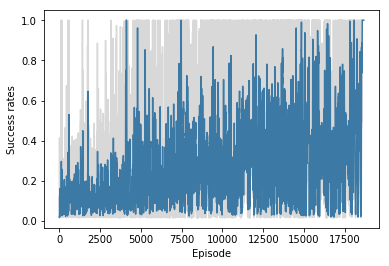

In [110]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

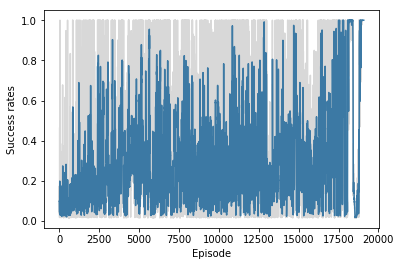

In [106]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

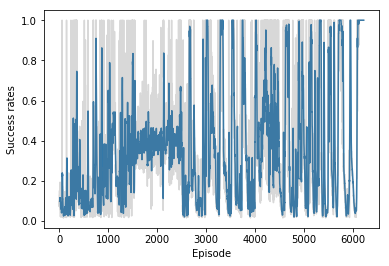

In [98]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

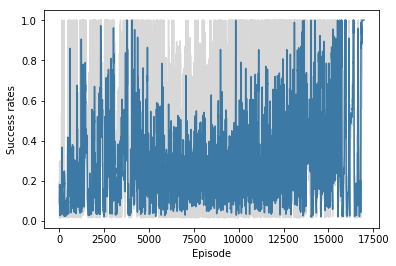

In [94]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

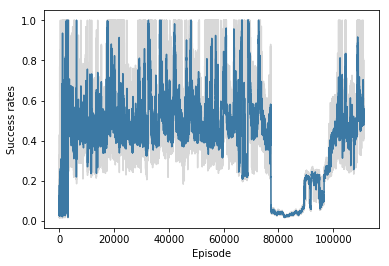

In [91]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

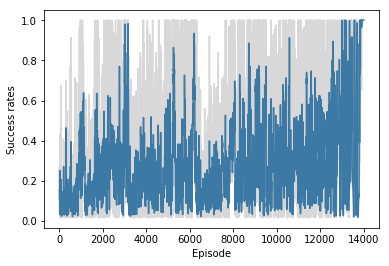

In [78]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

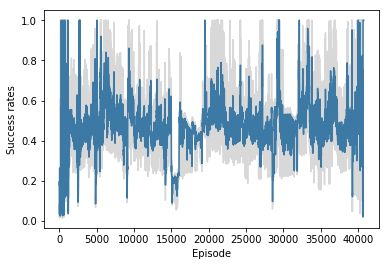

In [59]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Total rewards')

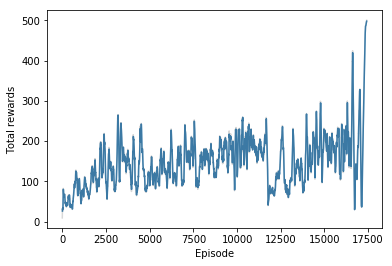

In [113]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

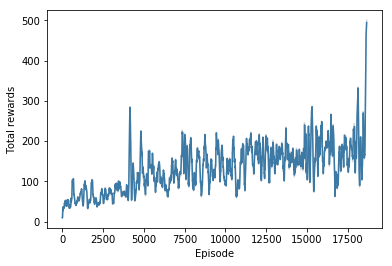

In [111]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

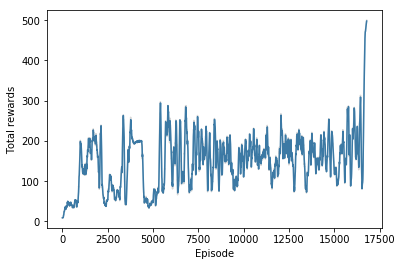

In [108]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

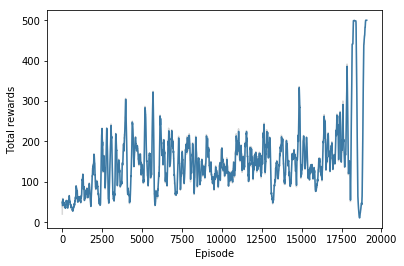

In [105]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

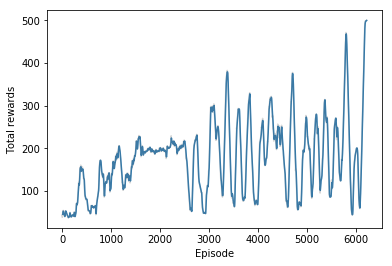

In [102]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

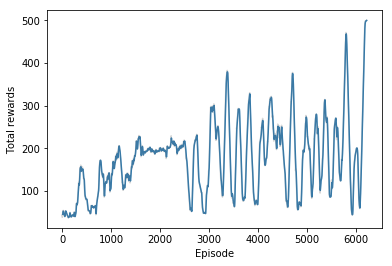

In [101]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

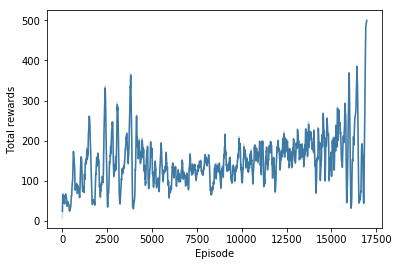

In [95]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

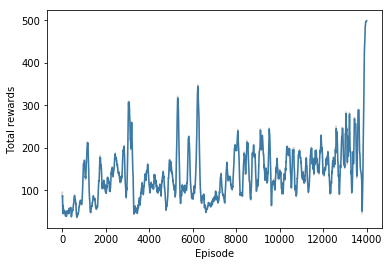

In [72]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

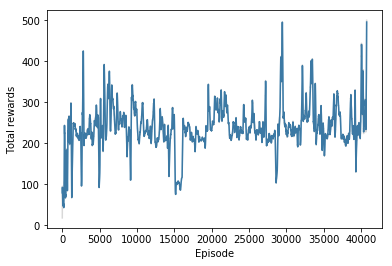

In [54]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

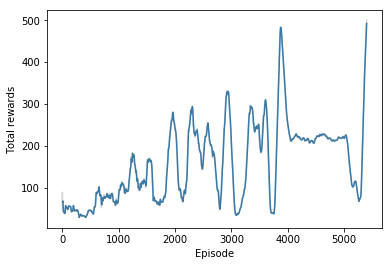

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

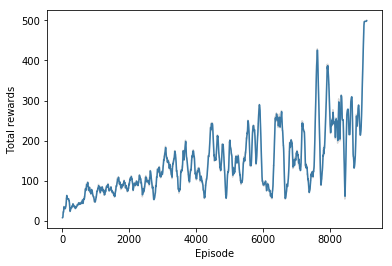

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

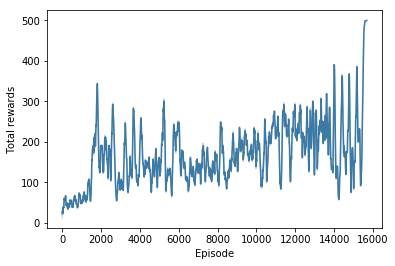

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

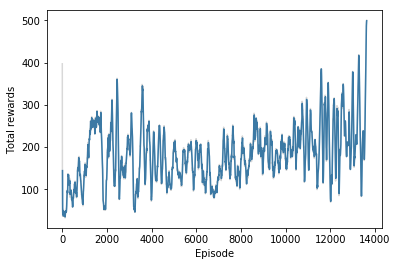

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

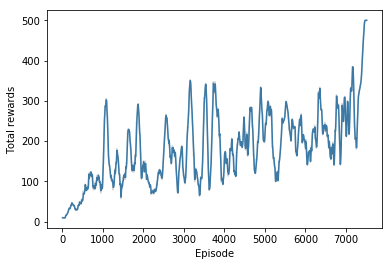

Text(0,0.5,'G losses')

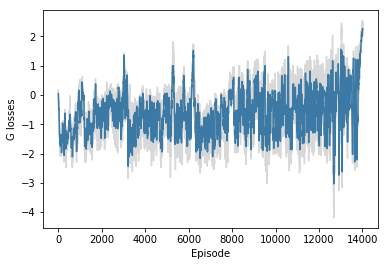

In [73]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

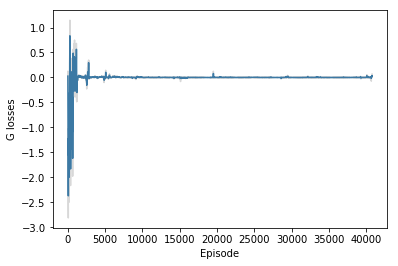

In [55]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

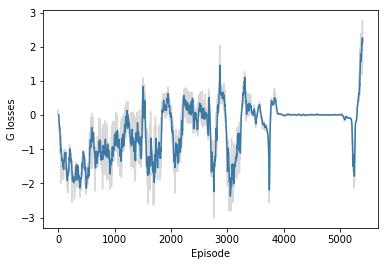

In [28]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

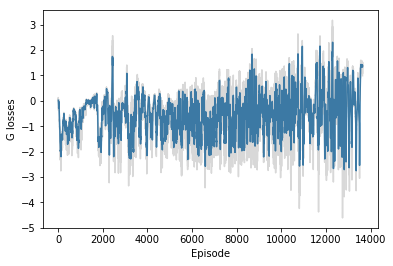

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

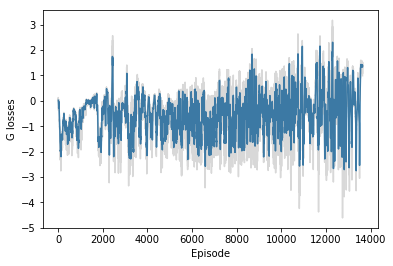

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

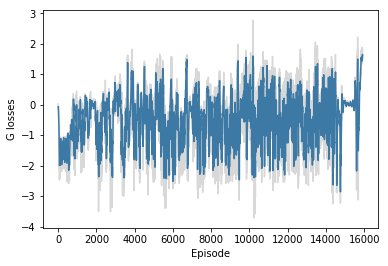
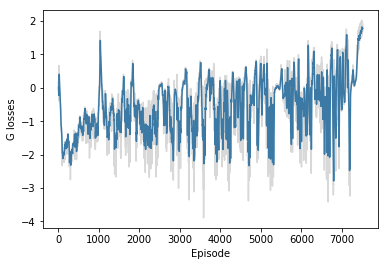

Text(0,0.5,'D losses')

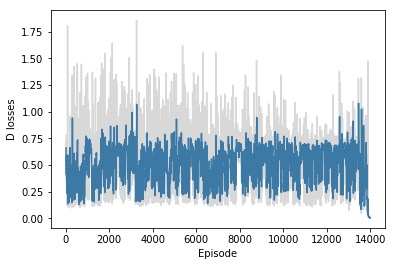

In [74]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

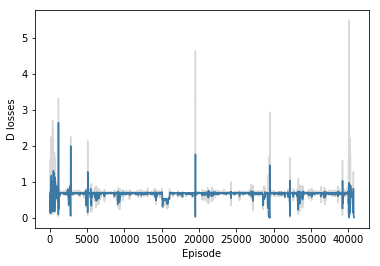

In [56]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

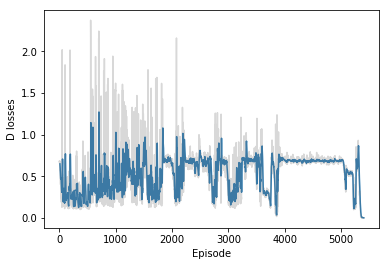

In [29]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

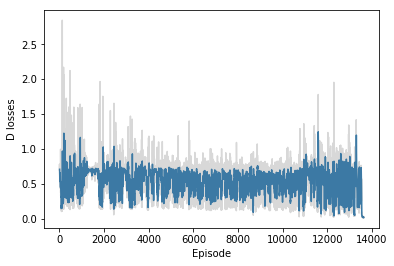

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

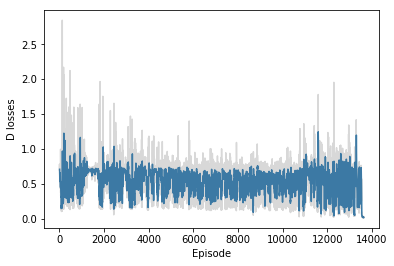

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

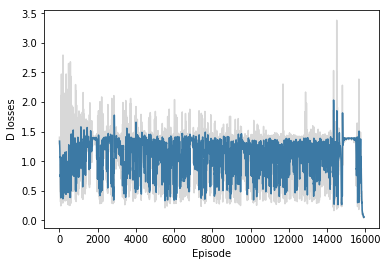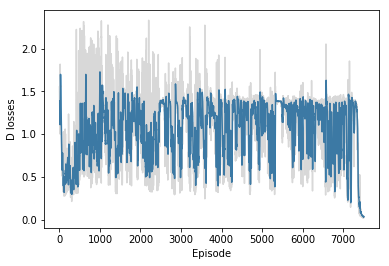

Text(0,0.5,'D losses R')

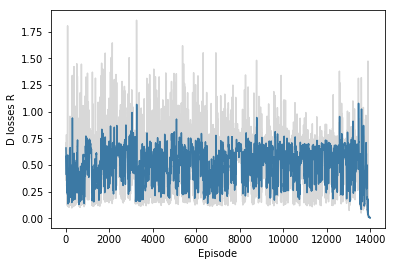

In [75]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

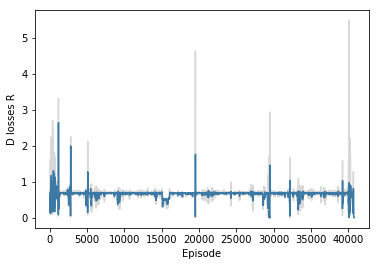

In [57]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

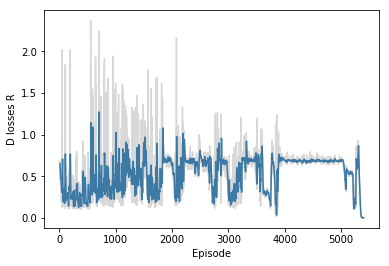

In [31]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

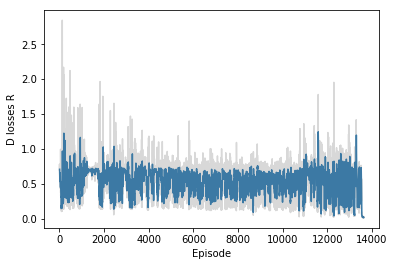

In [35]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

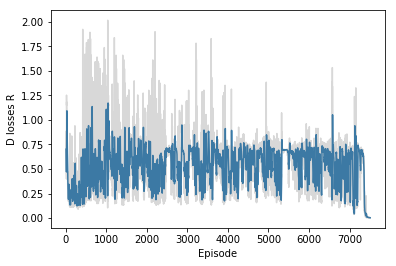

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

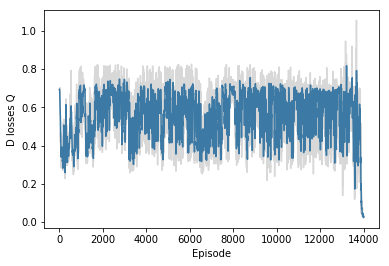

In [76]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

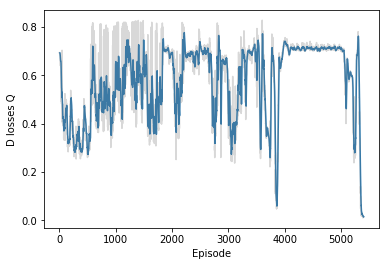

In [32]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

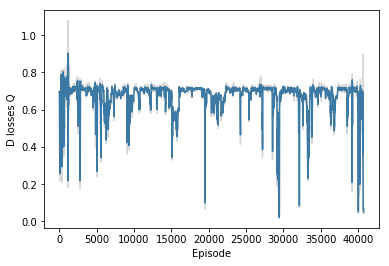

In [58]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

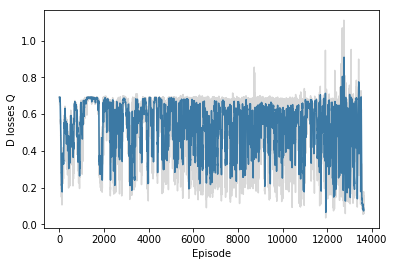

In [36]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

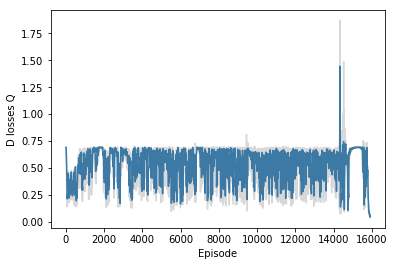

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

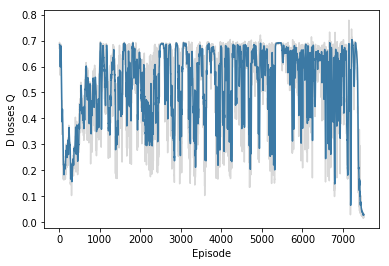

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.